# Exploratory Data Analysis on US Traffic Incidents

<center><img src="https://raw.githubusercontent.com/anjakuchenbecker/eda_on_traffic_incidents/main/analysis_areas_figure.jpg" alt="Drawing" style="width:1200px;"/></center>

## <a id="toc"></a>🧾 Table of contents

- [Introduction](#introduction)
- [Notebook Setup](#chapter-2)
- [Task 1: Gathering data](#chapter-3)
  - [Data requirements](#chapter-3-requirements)
  - [Raw data loading](#chapter-3-load)
  - [Rad data preview](#chapter-3-preview)
- [Task 2: Describing data](#chapter-4)
  - [Raw Feature Descriptions](#chapter-4-features)
  - [Summary](#chapter-4-summary)
- [Task 3: Preprocess data](#chapter-5)
  - [Setup](#chapter-5-setup)
  - [Convert data types](#chapter-5-convert)
  - [Drop features](#chapter-5-drop)
  - [Remove leading and trailing spaces](#chapter-5-spaces)
  - [Handle missing values](#chapter-5-missing)
  - [Handle outliers](#chapter-5-outliers)
  - [Derive new features](#chapter-5-new)
  - [Finalize Preprocessing](#chapter-5-finalize)
  - [Summary](#chapter-5-summary)
- [Task 4: Finding Insights](#chapter-6)
  - [Analysis Area 1: Impact Analysis](#analysis-1)
  - [Analysis Area 2: Location Analysis](#analysis-2)
  - [Analysis Area 3: Time Analysis](#analysis-3)
  - [Analysis Area 4: Trend Analysis](#analysis-4)
  - [Analysis Area 5: Environment Analysis](#analysis-5)
  - [Analysis Area 6: Weather Analysis](#analysis-6)
  - [Analysis Area 7: Relationship Analysis](#analysis-7)
- [Task 5: Communicate the Story](#chapter-7)
- [Task 6: Perform Modeling](#chapter-8)
- [Task 7: Perform Model Evaluation](#chapter-9)
- [Appendix](#chapter-10)
  - [Acknowledgements](#acknowledgements)
  - [Bibliography](#bibliography)

# <a id="introduction"></a>Introduction

The aim of this notebook is to demonstrate how a data set can be explored by support of descriptive statistics and visualizations based on design principles in order to getting familiar with the data set and gain insights. The goal is to analyze what has happened so far to discover meaningful insights from the data.

It represents how exploratory data analysis can be performed in a very structured way by support of pre-defined process steps each with a dedicated scope, input and output based on a large data set with nearly 3 million observations and 47 features about traffic incidents within the United States from 2016 to 2021, namely the [US Accidents (2016 - 2021) data set](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents), provided by Sobhan Moosavi on Kaggle. 

In addition, interesting insights are revealed, and meaningful visualizations are presented as well in different areas such as impact, location, time, trend, environment, weather, and relationship analysis.

The results of this notebook can be used as blueprint for approaching exploratory data analysis in general and to understand traffic incidents better in order to utilize this knowledge for real world applications that can answer what is going to happen to predict future events and scenarios based on this data.

In case if you are only interested on the insights and not on the source code and the way how the insights have been discovered, you can directly go to the [Communicate the Story](#chapter-7) chapter where you can find a PDF handout that contains all analysis results in condensed form.

The Jupyter notebook itself and the attachments can be found on
- Kaggle: https://www.kaggle.com/code/anjakuchenbecker/eda-on-us-traffic-incidents/
- GitHub: https://github.com/anjakuchenbecker/eda_on_traffic_incidents

*Go to [TOC](#toc)*

# <a id="chapter-2"></a>Notebook Setup

*Go to [TOC](#toc)*

## Python imports and general settings

In [2]:
# Imports
import pandas as pd
import numpy as np
import urllib.request
import zipfile
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import skew
import statistics
from scipy import stats
from IPython.display import IFrame

# General settings
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)

# Define sets to track information for summaries
# Classification
class_text_features = set()
class_unique_identifier_features = set()
class_ordinal_features = set()
class_nominal_features = set()
class_num_ratio_scaled_features = set()
class_num_interval_scaled_features = set()
class_date_time_features = set()
# Next steps 
features_to_convert = set()
features_to_drop = set()
features_to_drop_after_deriving_new_features = set()
features_to_preprocess = set()
features_for_deriving_new_features = set()
features_new_created = set()
features_no_action = set()
observations_to_drop = set()

## Helper functions

In [3]:
def data_info_text_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))
    mode = data[feature].mode()[0]
    mode_frequency = len(data[data[feature] == mode])
    print("Mode:", mode)
    print("Mode frequency:", mode_frequency)

def data_info_nominal_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))
    print("Number of levels:", len(data[feature].dropna().unique()))
    print("Levels (first 100):", sorted(data[feature].dropna().unique())[:100])
    mode = data[feature].mode()[0]
    mode_frequency = len(data[data[feature] == mode])
    print("Mode:", mode)
    print("Mode frequency:", mode_frequency)

def data_info_ordinal_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Min:", data[feature].min())
    print("Max:", data[feature].max())
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))
    mode = data[feature].mode()[0]
    mode_frequency = len(data[data[feature] == mode])
    print("Mode:", mode)
    print("Mode frequency:", mode_frequency)

def data_info_num_interval_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Min:", data[feature].min())
    print("Max:", data[feature].max())
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))
    check_for_outliers(data, feature)

def data_info_num_ratio_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Min:", data[feature].min())
    print("Max:", data[feature].max())
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))
    check_for_outliers(data, feature)

def data_info_date_time_attribute(data, feature):
    print("Type:", type(data[feature].dtype))
    print("Min:", pd.to_datetime(data[feature]).min())
    print("Max:", pd.to_datetime(data[feature]).max())
    print("Missing absolute (#):", data[feature].isnull().sum())
    print("Missing relative (%):", round(data[feature].isnull().sum() / len(data) * 100))

def check_for_outliers(data, feature):
    q1_value = data[feature].quantile(0.25)
    q3_value = data[feature].quantile(0.75)
    iqr_value = q3_value - q1_value

    outlier_lower_bound = q1_value - 1.5 * iqr_value
    outlier_upper_bound = q3_value + 1.5 * iqr_value

    # Calculate length of filtered values between Q1-(1.5*IQR) and Q3+(1.5*IQR)
    len_filtered_without_outlier_lower_bound = len(data[data[feature] >= outlier_lower_bound])
    len_filtered_without_outlier_upper_bound = len(data[data[feature] <= outlier_upper_bound])

    absolute_amount_outlier_lower = len(data) - data[feature].isnull().sum() - len_filtered_without_outlier_lower_bound
    relative_amount_outlier_lower = round(absolute_amount_outlier_lower / len(data) * 100, 4)

    absolute_amount_outlier_upper = len(data) - data[feature].isnull().sum() - len_filtered_without_outlier_upper_bound
    relative_amount_outlier_upper = round(absolute_amount_outlier_upper / len(data) * 100, 4)

    total_absolute_amount_outlier = absolute_amount_outlier_lower + absolute_amount_outlier_upper
    total_relative_amount_outlier = relative_amount_outlier_lower + relative_amount_outlier_upper

    print(f"potential outlier when {feature} <=", outlier_lower_bound, "- values #:", absolute_amount_outlier_lower, "/ %:", relative_amount_outlier_lower)
    print(f"potential outlier when {feature} >=", outlier_upper_bound, "- values #:", absolute_amount_outlier_upper, "/ %:", relative_amount_outlier_upper)
    print("potential total outlier values #:", total_absolute_amount_outlier, "/ %:", total_relative_amount_outlier)

def check_distribution_type(data, feature):
    result = skew(data[feature])

    if result > 1:
        dist_type = "Non-symmetric highly right-skewed distribution"
    if (result < -1):
        dist_type = "Non-symmetric highly left-skewed distribution"
    if (result >= 0.5) and (result <= 1):
        dist_type = "Non-symmetric moderately right-skewed distribution"
    if (result >= -1) and (result <= -0.5):
        dist_type = "Non-symmetric moderately left-skewed distribution"
    if (result > -0.5) and (result < 0.5):
        dist_type = "Approximately symmetric distribution"
    
    return dist_type + f" (skewness: {round(result, 5)})"

def outlier_keep_drop_less(data, feature, val):
    # Perform calculations
    total_observations = data.shape[0]

    absolute = data[data[feature] < val].shape[0]
    relative = round((absolute / total_observations) * 100, 2)

    dropped_absolute = total_observations - absolute
    dropped_relative = round(100 - relative, 2)

    print("Keep: #", absolute, "/" , relative, " %")
    print("Drop: #", dropped_absolute, "/", dropped_relative, " %")

    # Track observations to drop
    index = data[data[feature] >= val].index
    observations_to_drop.update(index)

def outlier_keep_drop_range(data, feature, val_low, val_high):
    # Perform calculations
    total_observations = data.shape[0]

    absolute = data[
        (data[feature] >= val_low) &
        (data[feature] < val_high)
    ].shape[0]
    relative = round((absolute / total_observations) * 100, 2)

    dropped_absolute = total_observations - absolute
    dropped_relative = round(100 - relative, 2)

    print("Keep: #", absolute, "/" , relative, " %")
    print("Drop: #", dropped_absolute, "/", dropped_relative, " %")

    # Track observations to drop
    index = data[
        (data[feature] < val_low) |
        (data[feature] >= val_high)
    ].index
    observations_to_drop.update(index)

## Stylings

In [9]:
%%html
<style>
table {align:left;display:block}
</style>

# <a id="chapter-3"></a>Task 1: Gathering data

*Go to [TOC](#toc)*

## <a id="chapter-3-requirements"></a>Data requirements

-	The data set must be open source respectively free of charge
-	Downloading the data set must be easy: account creation can be a prerequisite but without the need to provide more personal information than email address, password and optionally name
-	Must be CSV file format, as this can be easily load and processed when working with the pandas library
-	Must not be a well-known data set that is overused in literature (e.g., titanic, iris, Boston housing) or provided by python libraries per default, in order to increase the learning effect
-	The data set must be not artificial and can be used in real word applications, it must have been collected from official APIs respectively provided by companies or official institutions
-	In order to facing real world complexity, the data set must have at between 30 to 50 columns and 1.5 million observations minimum but not more than 4 million observations (due to hardware limitations when using a physical machine for analysis without permanent internet connection)
-	The meta data of the data set must be available in good detail as it is expected that specific domain knowledge must be acquired in addition via research

Perfect match candidate: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents

Finally, the selected data set must be loaded and can be basically eyeballed.

## <a id="chapter-3-load"></a>Raw data loading

In [10]:
# Load the raw data set
us_accidents_raw = pd.read_csv("US_Accidents_Dec21_updated.csv")

## <a id="chapter-3-preview"></a>Raw data preview

In [11]:
# Show basic information of the raw data set
us_accidents_raw.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845342 entries, 0 to 2845341
Data columns (total 47 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     2845342 non-null  object 
 1   Severity               2845342 non-null  int64  
 2   Start_Time             2845342 non-null  object 
 3   End_Time               2845342 non-null  object 
 4   Start_Lat              2845342 non-null  float64
 5   Start_Lng              2845342 non-null  float64
 6   End_Lat                2845342 non-null  float64
 7   End_Lng                2845342 non-null  float64
 8   Distance(mi)           2845342 non-null  float64
 9   Description            2845342 non-null  object 
 10  Number                 1101431 non-null  float64
 11  Street                 2845340 non-null  object 
 12  Side                   2845342 non-null  object 
 13  City                   2845205 non-null  object 
 14  County            

In [12]:
# Show total number of missing values
print("Total number of missing values:", us_accidents_raw.isnull().sum().sum())

Total number of missing values: 3414349


In [13]:
# Show first five observations
us_accidents_raw.head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.23000,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.10000,36.10000,58.00000,29.76000,10.00000,SW,10.40000,0.00000,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.74700,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.90000,NaN,91.00000,29.68000,10.00000,Calm,NaN,0.02000,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.05500,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.00000,NaN,97.00000,29.70000,10.00000,Calm,NaN,0.02000,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.06213,-81.53784,41.06217,-81.53547,0.12300,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.00000,NaN,55.00000,29.65000,10.00000,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.17239,-84.49279,39.17048,-84.50180,0.50000,At Mitchell Ave/Exit 6 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45217,US,US/Eastern,KLUK,2016-02-08 07:53:00,37.00000,29.80000,93.00000,29.69000,10.00000,WSW,10.40000,0.01000,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [14]:
# Show last five observations
us_accidents_raw.tail(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
2845337,A-2845338,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.00248,-117.37936,33.99888,-117.37094,0.54300,At Market St - Accident.,NaN,Pomona Fwy E,R,Riverside,Riverside,CA,92501,US,US/Pacific,KRAL,2019-08-23 17:53:00,86.00000,86.00000,40.00000,28.92000,10.00000,W,13.00000,0.00000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2845338,A-2845339,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.76696,-117.14806,32.76555,-117.15363,0.33800,At Camino Del Rio/Mission Center Rd - Accident.,NaN,I-8 W,R,San Diego,San Diego,CA,92108,US,US/Pacific,KMYF,2019-08-23 18:53:00,70.00000,70.00000,73.00000,29.39000,10.00000,SW,6.00000,0.00000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2845339,A-2845340,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.77545,-117.84779,33.77740,-117.85727,0.56100,At Glassell St/Grand Ave - Accident. in the ri...,NaN,Garden Grove Fwy,R,Orange,Orange,CA,92866,US,US/Pacific,KSNA,2019-08-23 18:53:00,73.00000,73.00000,64.00000,29.74000,10.00000,SSW,10.00000,0.00000,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2845340,A-2845341,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.99246,-118.40302,33.98311,-118.39565,0.77200,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,NaN,San Diego Fwy S,R,Culver City,Los Angeles,CA,90230,US,US/Pacific,KSMO,2019-08-23 18:51:00,71.00000,71.00000,81.00000,29.62000,10.00000,SW,8.00000,0.00000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2845341,A-2845342,2,2019-08-23 18:52:06,2019-08-23 19:21:31,34.13393,-117.23092,34.13736,-117.23934,0.53700,At Highland Ave/Arden Ave - Accident.,NaN,CA-210 W,R,Highland,San Bernardino,CA,92346,US,US/Pacific,KSBD,2019-08-23 20:50:00,79.00000,79.00000,47.00000,28.63000,7.00000,SW,7.00000,0.00000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


# <a id="chapter-4"></a>Task 2: Describing data

👉🏼 __Goal__

After data loading the data must be generally described forming the data description report. The following sub sections depict the features of the raw data set in detail including an initial assessment and the next steps that have to be taken. 

📋 __What actions have to be taken?__

- For each feature the following action is performed and the result is documented per feature:
  - Describe feature purpose
    - if meaning is unclear: check meaning
    - if there is a lack of domain knowledge (e.g., min/max values): perform research
  - Determine type of feature (String, Integer (Discrete), Float (Continuous)
  - Classify features (Unique identifier, Text-, Date / Time, nominal-, ordinal-, numerical interval-scaled or numerical ratio-scaled attribute)
  - Check range (from/to or levels)
  - Check for missing values (absolute / relative) for all features classes
  - Check for outliers (absolute / relative) for numerical feature classes
  - Decide to drop feature, reasons
    - Unique identifier (makes no sense as a predictor)
    - Has no relationship (makes no sense as a predictor)
    - Many missing values (above 50% - poor data quality)
    - All cases have the same value (does not vary)
    - Other feature has been derived / calculated based on given feature
  - Decide to keep feature but preprocessing is necessary
  - Decide to derive new feature(s) based on given feature
  - Decide to keep feature as it is for further analysis (no action necessary)
  - Create a raw data summary figure to summarize the main information of the raw data set
- Summarize your decisions

🧷 __Note__

Potential outliers are calculated using IQR (Lower bound is determined by *Q1 - 1.5 * IQR* and upper bound by *Q3 - 1.5 * IQR*

*Go to [TOC](#toc)*

## <a id="chapter-4-features"></a>Raw Feature Descriptions

### [ID] Feature

| Summary | Comment |
| :-: | :-: | 
| Description | <div style="width:800px">Unique identifier of the accident record.</div> |
| Type | String |
| Classification | Unique identifier |
| Range | NA |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Unique identifier (makes no sense as a predictor).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [15]:
# Show info
data_info_text_attribute(us_accidents_raw, "ID")

# Track information
class_unique_identifier_features.add("ID")
features_to_drop.add("ID")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Mode: A-1
Mode frequency: 1


### [Severity] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the severity of the accident, a number impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay). </div>|
| Type | Integer (Discrete)|
| Classification | Ordinal |
| Range | 1 <--> 4 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Severity can be used as dependent variable.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [16]:
# Show info
data_info_ordinal_attribute(us_accidents_raw, "Severity")

# Track information
class_ordinal_features.add("Severity")
features_no_action.add("Severity")

Type: <class 'numpy.dtype[int64]'>
Min: 1
Max: 4
Missing absolute (#): 0
Missing relative (%): 0
Mode: 2
Mode frequency: 2532991


### [Start_Time] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the start time of the accident in local time zone.</div>|
| Type | String |
| Classification | Date and Time |
| Range | 2016-01-14 20:18:33 <--> 2021-12-31 23:30:00 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but it makes sense to separate the date and time information for better understanding and comparison. Besides that its quite interesting how long the duration of an accident is.</div> |
| Next Steps | <div style="width:800px">Convert to *datetime64[s]* without possible microseconds and split *Date_Time* feature into separate new nominal features (*Year*, *Month*, *Day*, *Weekday*, *Hour*, *Minute*, *Second*). Create together with *End_Time* a new ratio-scaled feature *Duration(h)*. Finally, drop this feature.</div> |

In [17]:
# Show info
data_info_date_time_attribute(us_accidents_raw, "Start_Time")

# Track information
class_date_time_features.add("Start_Time")
features_to_convert.add("Start_Time")
features_for_deriving_new_features.add("Start_Time")
features_to_drop_after_deriving_new_features.add("Start_Time")
features_new_created.add("Year")
features_new_created.add("Month")
features_new_created.add("Day")
features_new_created.add("Weekday")
features_new_created.add("Hour")
features_new_created.add("Minute")
features_new_created.add("Second")
features_new_created.add("Duration(h)")

Type: <class 'numpy.dtype[object_]'>
Min: 2016-01-14 20:18:33
Max: 2021-12-31 23:30:00
Missing absolute (#): 0
Missing relative (%): 0


### [End_Time] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the end time of the accident in local time zone. End time here refers to when the impact of accident on traffic flow was dismissed.</div>|
| Type | String |
| Classification | Date and Time |
| Range | 2016-02-08 06:37:08 <--> 2022-01-01 00:00:00 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Its quite interesting how long the duration of an accident is.</div> |
| Next Steps | <div style="width:800px">Convert to *datetime64[s]* without possible microseconds and create together with *Start_Time* a new ratio-scaled feature *Duration(h)*. Finally, drop this feature.</div> |


In [18]:
# Show info
data_info_date_time_attribute(us_accidents_raw, "End_Time")

# Track information
class_date_time_features.add("End_Time")
features_to_convert.add("End_Time")
features_for_deriving_new_features.add("End_Time")
features_to_drop_after_deriving_new_features.add("End_Time")
features_new_created.add("Duration(h)")

Type: <class 'numpy.dtype[object_]'>
Min: 2016-02-08 06:37:08
Max: 2022-01-01 00:00:00
Missing absolute (#): 0
Missing relative (%): 0


### [Start_Lat] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows latitude in GPS coordinate of the start point. Feature is used as input to derive the feature *Distance(mi)*.</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 24.566027 <--> 49.00058 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | <= 23.372570500000002 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 50.2328465 / 0 / 0 |
| Pot. Outlier total (#/%) | 0 / 0 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [19]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Start_Lat")

# Track information
class_num_ratio_scaled_features.add("Start_Lat")
features_no_action.add("Start_Lat")

Type: <class 'numpy.dtype[float64]'>
Min: 24.566027
Max: 49.00058
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Start_Lat <= 23.372570500000002 - values #: 0 / %: 0.0
potential outlier when Start_Lat >= 50.2328465 - values #: 0 / %: 0.0
potential total outlier values #: 0 / %: 0.0


### [Start_Lng] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows longitude in GPS coordinate of the start point. Feature is used as input to derive the feature *Distance(mi)*.</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | -124.548074 <--> -67.113167 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | <= -174.52413475 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= -23.881408750000013 / 0 / 0 |
| Pot. Outlier total (#/%) | 0 / 0 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [20]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Start_Lng")

# Track information
class_num_ratio_scaled_features.add("Start_Lng")
features_no_action.add("Start_Lng")

Type: <class 'numpy.dtype[float64]'>
Min: -124.548074
Max: -67.113167
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Start_Lng <= -174.52413475 - values #: 0 / %: 0.0
potential outlier when Start_Lng >= -23.881408750000013 - values #: 0 / %: 0.0
potential total outlier values #: 0 / %: 0.0


### [End_Lat] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows latitude in GPS coordinate of the end point. Feature is used as input to derive the feature *Distance(mi)*.</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 24.566013 <--> 49.075 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | <= 23.37412112499999 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 50.23320612500001 / 0 / 0 |
| Pot. Outlier total (#/%) | 0 / 0 |
| Assessment | <div style="width:800px">*Distance(mi)* has been derived / calculated based on this feature, so this feature is no longer needed.</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [21]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "End_Lat")

# Track information
class_num_ratio_scaled_features.add("End_Lat")
features_to_drop.add("End_Lat")

Type: <class 'numpy.dtype[float64]'>
Min: 24.566013
Max: 49.075
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when End_Lat <= 23.37412112499999 - values #: 0 / %: 0.0
potential outlier when End_Lat >= 50.23320612500001 - values #: 0 / %: 0.0
potential total outlier values #: 0 / %: 0.0


### [End_Lng] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows longitude in GPS coordinate of the end point. Feature is used as input to derive the feature *Distance(mi)*.</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | -124.545748 <--> -67.10924200000001 |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | <= -174.52325237500006 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= -23.883461374999932 / 0 / 0 |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">*Distance(mi)* has been derived / calculated based on this feature, so this feature is no longer needed.</diV> |
| Next Steps | <div style="width:800px">Drop</div> |

In [22]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "End_Lng")

# Track information
class_num_ratio_scaled_features.add("End_Lng")
features_to_drop.add("End_Lng")

Type: <class 'numpy.dtype[float64]'>
Min: -124.545748
Max: -67.10924200000001
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when End_Lng <= -174.52325237500006 - values #: 0 / %: 0.0
potential outlier when End_Lng >= -23.883461374999932 - values #: 0 / %: 0.0
potential total outlier values #: 0 / %: 0.0


### [Distance(mi)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">The length of the road extent affected by the accident. Calculated based on the straight line distance between Start_Lat/End_Lng-pair and End_Lat/End_Lng-Pair.</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 0.0 <--> 155.186 |
| Missing (#/%) | 0.0 / 0 |
| Pot. Outlier lower (value/#/%) | <= -1.016 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 1.832 / 279790 / 9.8333 |
| Pot. Outlier total (#/%) | 279790 / 9.8333 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but the max. value of 155.86 miles is very high for a single accident. In addition there are 279.790 / 9.8333 % potential outliers, indicator that raw distribution of feature is skewed.</div> |
| Next Steps | <div style="width:800px">Keep. Handle potential outliers.</div> |

In [23]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Distance(mi)")

# Track information
class_num_ratio_scaled_features.add("Distance(mi)")
features_to_preprocess.add("Distance(mi)")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 155.186
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Distance(mi) <= -1.016 - values #: 0 / %: 0.0
potential outlier when Distance(mi) >= 1.832 - values #: 279790 / %: 9.8333
potential total outlier values #: 279790 / %: 9.8333


### [Description] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows a human provided description of the accident.</div>|
| Type | String |
| Classification | Text |
| Range | NA |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Has no relationship (makes no sense as a predictor).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [24]:
# Show info
data_info_text_attribute(us_accidents_raw, "Description")

# Track information
class_text_features.add("Description")
features_to_drop.add("Description")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Mode: A crash has occurred causing no to minimum delays. Use caution.
Mode frequency: 7978


### [Number] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the street number in address field.</div>|
| Type | Integer (Discrete) |
| Classification | Numeric, interval-scales |
| Range | 0.0 <-> 9999997.0 |
| Missing (#/%) | 1743911 / 61 |
| Pot. Outlier lower (value/#/%) | <= -11175.5 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 22012.5 / 82547 / 2.9011|
| Pot. Outlier total (#/%) | 82547 / 2.9011 |
| Assessment | <div style="width:800px">Many missing values, 61% (above 50%- poor data quality). In addition, has no relationship (makes no sense as a predictor).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [25]:
# Show info
data_info_num_interval_attribute(us_accidents_raw, "Number")

# Track information
class_num_interval_scaled_features.add("Number")
features_to_drop.add("Number")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 9999997.0
Missing absolute (#): 1743911
Missing relative (%): 61
potential outlier when Number <= -11175.5 - values #: 0 / %: 0.0
potential outlier when Number >= 22012.5 - values #: 82547 / %: 2.9011
potential total outlier values #: 82547 / %: 2.9011


### [Street] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the street name in address field.<br/>Street types: https://www.vox.com/2016/11/14/13275486/streets-roads-avenues-names-reasons</div>|
| Type | String |
| Classification | Nominal |
| Range | NA |
| Missing (#/%) | 2 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but there are missing values and it seems that there are leading spaces. Besides to get knowledge which streets have the most accidents, it seems reasonable to create a new nominal feature in addition based on the street type that is encoded within.</div> |
| Next Steps | <div style="width:800px">Keep. Remove leading spaces and handle missing values. Finally create new ordinal feature *Street_Type*.</div> |

In [26]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Street")

# Track information
class_nominal_features.add("Street")
features_to_preprocess.add("Street")
features_for_deriving_new_features.add("Street")
features_new_created.add("Street_Type")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 2
Missing relative (%): 0
Number of levels: 159651
Levels (first 100): [' 1 1/2 Ave', ' 1 Mile Rd', ' 1/2 Ave', ' 1/2 Ave NW', ' 1/2 Ave SE', ' 1/2 Mile Rd', ' 1/2 Rd', ' 1/4 Ave', ' 10 Mile Rd', ' 10 Mile Rd NE', ' 10000 E', ' 100th Ave', ' 100th Ave N', ' 100th Ave SE', ' 100th Pl', ' 100th St', ' 100th St E', ' 100th St NE', ' 100th St NW', ' 100th St SE', ' 100th St W', ' 100th Way N', ' 101st Ave', ' 101st Ave N', ' 101st Pt', ' 101st Rd', ' 101st St', ' 101st St E', ' 101st St W', ' 102nd Ave', ' 102nd Ave N', ' 102nd St', ' 102nd St E', ' 102nd St NW', ' 102nd St W', ' 102nd Ter N', ' 103rd Ave', ' 103rd Ave N', ' 103rd Dr NW', ' 103rd St', ' 103rd St E', ' 103rd Street Ct W', ' 104th Ave', ' 104th Ave E', ' 104th Ave NE', ' 104th Ave SE', ' 104th St', ' 104th Way NE', ' 105th Ave', ' 105th Ave NE', ' 105th Ave SE', ' 105th Dr', ' 105th St', ' 105th St E', ' 105th St NE', ' 105th St NW', ' 105th St SW', ' 106th Ave', ' 1

### [Side] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the relative side of the street (Right/Left) in address field.</div>|
| Type | String |
| Classification | Nominal |
| Range | 3 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Meta description states that there are two levels but there are three: R, L and N. Maybe *N* indicates NaN. Only 1 observation has side equal to *N*, so it will be defined as missing value that must be handled (it can imputed with the mode value).</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values.</div> |

In [27]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Side")

# Check counts for level "N"
print("Observations with side equal to N:", len(us_accidents_raw[us_accidents_raw["Side"] == "N"]))

# Track information
class_nominal_features.add("Side")
features_to_preprocess.add("Side")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 3
Levels (first 100): ['L', 'N', 'R']
Mode: R
Mode frequency: 2353309
Observations with side equal to N: 1


### [City] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the city in address field. Over 19.000 incorporated places exist according to United States Census Bureau (https://www.census.gov/content/dam/Census/data/developers/understandingplace.pdf). </div>|
| Type | String |
| Classification | Nominal |
| Range | 11681 levels |
| Missing (#/%) | 137 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but there are missing values that must be handled.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values.</div> |

In [28]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "City")

# Track information
class_nominal_features.add("City")
features_to_preprocess.add("City")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 137
Missing relative (%): 0
Number of levels: 11681
Levels (first 100): ['Aaronsburg', 'Abbeville', 'Abbotsford', 'Abbottstown', 'Aberdeen', 'Aberdeen Proving Ground', 'Abernathy', 'Abilene', 'Abingdon', 'Abington', 'Abrams', 'Absarokee', 'Absecon', 'Acampo', 'Accident', 'Accokeek', 'Accomac', 'Accord', 'Ackerman', 'Ackworth', 'Acme', 'Acoma', 'Acosta', 'Acra', 'Acton', 'Acworth', 'Ada', 'Adah', 'Adair', 'Adair Village', 'Adairsville', 'Adairville', 'Adams', 'Adams Center', 'Adams Run', 'Adamsburg', 'Adamstown', 'Adamsville', 'Addis', 'Addison', 'Addy', 'Addyston', 'Adel', 'Adelanto', 'Adell', 'Adelphi', 'Adena', 'Adin', 'Adkins', 'Adrian', 'Advance', 'Afton', 'Agate', 'Agawam', 'Agency', 'Agoura Hills', 'Aguanga', 'Aguila', 'Aguilar', 'Ahoskie', 'Ahwahnee', 'Aiken', 'Ailey', 'Ainsworth', 'Airmont', 'Airville', 'Airway Heights', 'Aitkin', 'Ajo', 'Akeley', 'Akron', 'Alabaster', 'Alachua', 'Alameda', 'Alamo', 'Alamogordo', 'Alamo

### [County] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the county in address field. Over 3.000 counties exist according to United States Census Bureau (https://en.wikipedia.org/wiki/County_(United_States))</div>|
| Type | String |
| Classification | Nominal |
| Range | 1707 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [29]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "County")

# Track information
class_nominal_features.add("County")
features_no_action.add("County")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 1707
Levels (first 100): ['Abbeville', 'Acadia', 'Accomack', 'Ada', 'Adair', 'Adams', 'Addison', 'Aiken', 'Aitkin', 'Alachua', 'Alamance', 'Alameda', 'Alamosa', 'Albany', 'Albemarle', 'Alcona', 'Alcorn', 'Alexander', 'Alexandria', 'Alexandria City', 'Alger', 'Allamakee', 'Allegan', 'Allegany', 'Alleghany', 'Allegheny', 'Allen', 'Allendale', 'Alpena', 'Alpine', 'Amador', 'Amelia', 'Amherst', 'Amite', 'Anderson', 'Andrew', 'Andrews', 'Androscoggin', 'Angelina', 'Anne Arundel', 'Anoka', 'Anson', 'Antelope', 'Antrim', 'Apache', 'Appanoose', 'Appling', 'Appomattox', 'Arapahoe', 'Archer', 'Archuleta', 'Arenac', 'Arkansas', 'Arlington', 'Armstrong', 'Aroostook', 'Ascension', 'Ashe', 'Ashland', 'Ashley', 'Ashtabula', 'Asotin', 'Assumption', 'Atascosa', 'Atchison', 'Athens', 'Atkinson', 'Atlantic', 'Atoka', 'Attala', 'Audrain', 'Audubon', 'Auglaize', 'Augusta', 'Aurora', 'Austin', 'Autauga', '

### [State] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the state (ANSI Code) in address field. 50 states exist according to the United States Census Bureau (https://en.wikipedia.org/wiki/U.S._state). </br>List of state abbreviations: https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations </div>|
| Type | String |
| Classification | Nominal |
| Range | 49 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. 50 states exits but only 49 levels are found. There are no observations for State *Alaska (AK)*.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [30]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "State")

# Track information
class_nominal_features.add("State")
features_no_action.add("State")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 49
Levels (first 100): ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Mode: CA
Mode frequency: 795868


### [Zipcode] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the zip code in address field. Over 40.000 zip code exist according to USPS (https://facts.usps.com/42000-zip-codes/).<br/>Format: https://pe.usps.com/archive/html/dmmarchive20030810/A010.htm.<br/>Lookup for zip codes: https://tools.usps.com/zip-code-lookup.htm </div>|
| Type | String |
| Classification | Nominal |
| Range | 363085 levels |
| Missing (#/%) | 1319 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but there are missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values.</div> |

In [31]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Zipcode")

# Track information
class_nominal_features.add("Zipcode")
features_to_preprocess.add("Zipcode")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 1319
Missing relative (%): 0
Number of levels: 363085
Levels (first 100): ['01001', '01005-9392', '01007-9524', '01007-9725', '01008', '01008-9615', '01010', '01010-9506', '01010-9672', '01011-9652', '01011-9688', '01013', '01020', '01020-5000', '01020-5032', '01026-9633', '01038', '01039-9739', '01040', '01040-2713', '01050-9784', '01056', '01056-3340', '01057-9791', '01060', '01060-2421', '01069', '01069-9314', '01071', '01082-9740', '01083', '01085', '01088', '01089', '01089-2713', '01089-4566', '01089-4606', '01092', '01095', '01096-9799', '01098-9767', '01103', '01104', '01104-2820', '01104-3321', '01104-3324', '01104-3413', '01105', '01106', '01107', '01108', '01201-9201', '01223', '01226', '01226-1217', '01230', '01237', '01238', '01238-9322', '01247-3767', '01255', '01257', '01257-9696', '01262', '01266', '01270', '01301', '01330-9753', '01331', '01331-2112', '01331-2131', '01337', '01342', '01344-9732', '01354-9709', '

### [Country] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the country in address field.</div>|
| Type | String |
| Classification | Nominal |
| Range | 1 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Data has scope to US data, so all cases have the same value *US* (does not vary).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [32]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Country")

# Track information
class_nominal_features.add("Country")
features_to_drop.add("Country")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 1
Levels (first 100): ['US']
Mode: US
Mode frequency: 2845342


### [Timezone] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows timezone based on the location of the accident (eastern, central, etc.) More information about time zones in us: https://en.wikipedia.org/wiki/Time_in_the_United_States.</div>|
| Type | String |
| Classification | Nominal |
| Range | 4 levels |
| Missing (#/%) | 3659 / 0 |
| Outlier lower (value/#/%) | NA |
| Outlier upper (value/#/%) | NA |
| Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but there are missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values.</div> |

In [33]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Timezone")

# Track information
class_nominal_features.add("Timezone")
features_to_preprocess.add("Timezone")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 3659
Missing relative (%): 0
Number of levels: 4
Levels (first 100): ['US/Central', 'US/Eastern', 'US/Mountain', 'US/Pacific']
Mode: US/Eastern
Mode frequency: 1221927


### [Airport_Code] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Denotes an airport-based weather station which is the closest one to location of accident.</div>|
| Type | String |
| Classification | Nominal |
| Range | 2004 levels |
| Missing (#/%) | 9549 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Has no relationship (makes no sense as a predictor).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [34]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Airport_Code")

# Track information
class_nominal_features.add("Airport_Code")
features_to_drop.add("Airport_Code")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 9549
Missing relative (%): 0
Number of levels: 2004
Levels (first 100): ['K01M', 'K04V', 'K04W', 'K06D', 'K08D', 'K0A9', 'K0CO', 'K0E0', 'K0F2', 'K0J4', 'K0VG', 'K11R', 'K12N', 'K14Y', 'K19A', 'K1A5', 'K1A6', 'K1F0', 'K1H2', 'K1II', 'K1J0', 'K1M4', 'K1P1', 'K1R7', 'K1V4', 'K1V6', 'K1YT', 'K20U', 'K20V', 'K21D', 'K27A', 'K2C8', 'K2D5', 'K2DP', 'K2G4', 'K2I0', 'K2J9', 'K2V5', 'K2W6', 'K33V', 'K36U', 'K3A1', 'K3A6', 'K3DU', 'K3HT', 'K3I2', 'K3J7', 'K3LF', 'K3MW', 'K3R7', 'K3T5', 'K3TH', 'K40J', 'K42J', 'K46D', 'K48I', 'K4A6', 'K4A9', 'K4BL', 'K4BM', 'K4CR', 'K4HV', 'K4I3', 'K4M9', 'K4MR', 'K4O4', 'K4SL', 'K54J', 'K5C1', 'K5H4', 'K5M9', 'K5SM', 'K5T6', 'K5W8', 'K65S', 'K6A1', 'K6A2', 'K6B0', 'K6R3', 'K6R6', 'K77M', 'K79J', 'K7L2', 'K7R3', 'K82V', 'K87Q', 'K8A0', 'K8D3', 'K8S0', 'K9A1', 'K9A4', 'K9BB', 'K9D7', 'K9L2', 'K9MN', 'K9V9', 'KAAA', 'KAAF', 'KAAO', 'KAAT']
Mode: KCQT
Mode frequency: 52790


### [Weather_Timestamp] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the timestamp of weather observation record (in local time).</div>|
| Type | String |
| Classification | Date and Time |
| Range | 2016-01-14 19:51:00 <-> 2021-12-31 23:53:00 |
| Missing (#/%) | 50736 / 2 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Has no relationship (makes no sense as a predictor).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [35]:
# Show info
data_info_date_time_attribute(us_accidents_raw, "Weather_Timestamp")

# Track information
class_date_time_features.add("Weather_Timestamp")
features_to_drop.add("Weather_Timestamp")

Type: <class 'numpy.dtype[object_]'>
Min: 2016-01-14 19:51:00
Max: 2021-12-31 23:53:00
Missing absolute (#): 50736
Missing relative (%): 2


### [Temperature(F)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the temperature (in Fahrenheit).<br/>Average annual temperature for each US state: https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php.<br/>Hottest states: https://www.currentresults.com/Weather-Extremes/US/hottest.php <br/> Coldest states: https://www.currentresults.com/Weather-Extremes/US/coldest.php</div>|
| Type | Float (Continuous) |
| Classification | Numeric, interval-scaled |
| Range | -89.0 <-> 196.0 |
| Missing (#/%) | 69274 / 2 |
| Pot. Outlier lower (value/#/%) | <= 11.0 / 21937 / 0.771 |
| Pot. Outlier upper (value/#/%) | >= 115.0 / 56 / 0.002 |
| Pot. Outlier total (#/%) | 21993 / 0.773 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. But the min value -89 F (-67 °C) and max value 196 (91 °C) seems erroneous. In addition there are potential outliers and missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Handle potential outliers and missing values.</div> |

In [36]:
# Show info
data_info_num_interval_attribute(us_accidents_raw, "Temperature(F)")

# Check counts for some potential erroneous temperature values 
print("Observations with temp <= -85 F / -65 °C:", len(us_accidents_raw[us_accidents_raw["Temperature(F)"] <= -85]))
print("Observations with temp >= 131 F / 55 °C:", len(us_accidents_raw[us_accidents_raw["Temperature(F)"] >= 131]))

# Track information
class_num_interval_scaled_features.add("Temperature(F)")
features_to_preprocess.add("Temperature(F)")

Type: <class 'numpy.dtype[float64]'>
Min: -89.0
Max: 196.0
Missing absolute (#): 69274
Missing relative (%): 2
potential outlier when Temperature(F) <= 11.0 - values #: 21937 / %: 0.771
potential outlier when Temperature(F) >= 115.0 - values #: 56 / %: 0.002
potential total outlier values #: 21993 / %: 0.773
Observations with temp <= -85 F / -65 °C: 2
Observations with temp >= 131 F / 55 °C: 8


### [Wind_Chill(F)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the wind chill, difference between real- and feels-like temperature (in Fahrenheit). <br/>Detailed information: https://www.weather.gov/safety/cold-faqs<br/>Thermal sensation classification: https://de.wikipedia.org/wiki/Gef%C3%BChlte_Temperatur</div>|
| Type | Float (Continuous) |
| Classification | Numeric, interval-scaled |
| Range | -89.0 <-> 196.0 |
| Missing (#/%) | 469643 / 17 |
| Pot. Outlier lower (value/#/%) | <= 1.0 / 22427 / 0.7882 |
| Pot. Outlier upper (value/#/%) | >= 121.0 / 6 / 0.0002 |
| Pot. Outlier total (#/%) | 22433 / 0.7884 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. But the min value -89 F (-67 °C) and max value 196 (91 °C) seems erroneous. In addition there are potential outliers and missing values. Create new ordinal feature *Thermal_Sensation* based on thermal sensation classification.</div> |
| Next Steps | <div style="width:800px">Keep. Handle potential outliers and missing values. Create new ordinal feature *Thermal_Sensation* and finally drop this feature.</div> |

In [37]:
# Show info
data_info_num_interval_attribute(us_accidents_raw, "Wind_Chill(F)")

# Track information
class_num_interval_scaled_features.add("Wind_Chill(F)")
features_to_preprocess.add("Wind_Chill(F)")
features_for_deriving_new_features.add("Wind_Chill(F)")
features_to_drop_after_deriving_new_features.add("Wind_Chill(F)")
features_new_created.add("Thermal_Sensation")

Type: <class 'numpy.dtype[float64]'>
Min: -89.0
Max: 196.0
Missing absolute (#): 469643
Missing relative (%): 17
potential outlier when Wind_Chill(F) <= 1.0 - values #: 22427 / %: 0.7882
potential outlier when Wind_Chill(F) >= 121.0 - values #: 6 / %: 0.0002
potential total outlier values #: 22433 / %: 0.7884


### [Humidity(%)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the humidity (in percentage).</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 1.0 <-> 100.0 |
| Missing (#/%) | 73092 / 3 |
| Pot. Outlier lower (value/#/%) | <= -4.5 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 135.5 / 0 / 0 |
| Pot. Outlier total (#/%) | 0 / 0 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. There are missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values.</div> |

In [38]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Humidity(%)")

# Track information
class_num_ratio_scaled_features.add("Humidity(%)")
features_to_preprocess.add("Humidity(%)")

Type: <class 'numpy.dtype[float64]'>
Min: 1.0
Max: 100.0
Missing absolute (#): 73092
Missing relative (%): 3
potential outlier when Humidity(%) <= -4.5 - values #: 0 / %: 0.0
potential outlier when Humidity(%) >= 135.5 - values #: 0 / %: 0.0
potential total outlier values #: 0 / %: 0.0


### [Pressure(in)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the barometric pressure (in inches).<br/>Common pressure values: https://www.thoughtco.com/how-to-read-a-barometer-3444043.<br/>Normal pressure range: https://www.masterclass.com/articles/how-barometric-pressure-works#what-is-barometric-pressure</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 0.0 <-> 58.9 |
| Missing (#/%) | 59200 / 2 |
| Pot. Outlier lower (value/#/%) | <= 28.259999999999994 / 187962 / 6.606 |
| Pot. Outlier upper (value/#/%) | >= 31.060000000000006 / 22 / 0.0008 |
| Pot. Outlier total (#/%) | 187984 / 6.6068 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. But the min value 0 and max value 58.9 seems erroneous. In addition there are potential outliers and missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Handle potential outliers and missing values.</div> |

In [39]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Pressure(in)")

# Check counts for some potential erroneous temperature values 
print("Observations with pressure >= 40:", len(us_accidents_raw[us_accidents_raw["Pressure(in)"] >= 45]))

# Track information
class_num_ratio_scaled_features.add("Pressure(in)")
features_to_preprocess.add("Pressure(in)")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 58.9
Missing absolute (#): 59200
Missing relative (%): 2
potential outlier when Pressure(in) <= 28.259999999999994 - values #: 187962 / %: 6.606
potential outlier when Pressure(in) >= 31.060000000000006 - values #: 22 / %: 0.0008
potential total outlier values #: 187984 / %: 6.6068
Observations with pressure >= 40: 11


### [Visibility(mi)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows visbility (in mile).<br/>Details: https://de.wikipedia.org/wiki/Sichtweite</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 0.0 <-> 140.0 |
| Missing (#/%) | 70546 / 2 |
| Pot. Outlier lower (value/#/%) | <= 10.0 / 533368 / 18.7453 |
| Pot. Outlier upper (value/#/%) | >= 10.0 / 11152 / 0.3919 |
| Pot. Outlier total (#/%) | 544520 / 19.1372 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights but there are missing values. In additon, it seems an option to map such numeric feature to a new ordinal feature *Visibility* with levels *excellent(5)* (> 31), *good(4)* (> 12 <= 31), *fair(3)* (> 6 <= 12), *poor(2)* (> 1 <= 6), *bad(1)* (<= 1).</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and create new ordinal feature *Visibity*. Finally, drop this feature.</div> |

In [40]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Visibility(mi)")

# Track information
class_num_ratio_scaled_features.add("Visibility(mi)")
features_to_preprocess.add("Visibility(mi)")
features_for_deriving_new_features.add("Visibility(mi)")
features_to_drop_after_deriving_new_features.add("Visibility(mi)")
features_new_created.add("Visibility")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 140.0
Missing absolute (#): 70546
Missing relative (%): 2
potential outlier when Visibility(mi) <= 10.0 - values #: 533368 / %: 18.7453
potential outlier when Visibility(mi) >= 10.0 - values #: 11152 / %: 0.3919
potential total outlier values #: 544520 / %: 19.1372


### [Wind_Direction] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows wind direction.<br/> Details of common levels: https://www.researchgate.net/figure/Classification-of-wind-directions-in-a-four-sectors-b-eight-sectors-c-sixteen_fig1_221914541.<br/> Variable Wind: https://forecast.weather.gov/glossary.php?word=variable%20wind. <br/>Calm Wind: https://forecast.weather.gov/glossary.php?word=wind%20direction#:~:text=North%20is%20360%20degrees.,used%20when%20wind%20is%20calm.</div>|
| Type | String |
| Classification | Nominal |
| Range | 24 levels |
| Missing (#/%) | 73775 / 3 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but it seams reasonable to reduce the amount of levels (e.g., *Variable* equal to *VAR* and *W* equal to *West*). In addition there are missing values.</div> |
| Next Steps | <div style="width:800px">Keep. Reduce amount of of levels and handling missing values.</div> |

In [41]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Wind_Direction")

# Track information
class_nominal_features.add("Wind_Direction")
features_to_preprocess.add("Wind_Direction")
features_new_created.add("Wind_Direction")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 73775
Missing relative (%): 3
Number of levels: 24
Levels (first 100): ['CALM', 'Calm', 'E', 'ENE', 'ESE', 'East', 'N', 'NE', 'NNE', 'NNW', 'NW', 'North', 'S', 'SE', 'SSE', 'SSW', 'SW', 'South', 'VAR', 'Variable', 'W', 'WNW', 'WSW', 'West']
Mode: CALM
Mode frequency: 433622


### [Wind_Speed(mph)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows wind speed (in miles per hour).<br/>Wind speed classification: https://www.rmets.org/metmatters/beaufort-scale<br/>Max. wind speed recorded: https://www.thoughtco.com/fast-wind-speed-recorded-3444498</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 0.0 <-> 1087.0 |
| Missing (#/%) | 157944 / 6 |
| Pot. Outlier lower (value/#/%) | <= -6.25 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 19.75 / 70834 / 2.4895 |
| Pot. Outlier total (#/%) | 70834 / 2.4895 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but max. value 1087 mph (1749 km/h) seems erroneous. In addition there are missing values and potential outliers. Create a new ordinal feature *Wind_Force*.</div> |
| Next Steps | <div style="width:800px">Keep. Handle potential outliers and missing values. Create new feature *Wind_Force* and finally drop this feature.</div> |

In [42]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Wind_Speed(mph)")

# Track information
class_num_ratio_scaled_features.add("Wind_Speed(mph)")
features_to_preprocess.add("Wind_Speed(mph)")
features_for_deriving_new_features.add("Wind_Speed(mph)")
features_to_drop_after_deriving_new_features.add("Wind_Speed(mph)")
features_new_created.add("Wind_Force")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 1087.0
Missing absolute (#): 157944
Missing relative (%): 6
potential outlier when Wind_Speed(mph) <= -6.25 - values #: 0 / %: 0.0
potential outlier when Wind_Speed(mph) >= 19.75 - values #: 70834 / %: 2.4895
potential total outlier values #: 70834 / %: 2.4895


### [Precipitation(in)] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows precipitation amount in inches, if there is any.<br/>Details: https://www.baranidesign.com/faq-articles/2020/1/19/rain-rate-intensity-classification</div>|
| Type | Float (Continuous) |
| Classification | Numeric, ratio-scaled |
| Range | 0.0 <-> 24.0 |
| Missing (#/%) | 549458 / 19 |
| Pot. Outlier lower (value/#/%) | <= 0.0 / 0 / 0 |
| Pot. Outlier upper (value/#/%) | >= 0.0 / 191642 / 6.7353 |
| Pot. Outlier total (#/%) | 191642 / 6.7353 |
| Assessment | <div style="width:800px">Interesting feature to gain more insights, but there are missing values. It seems an option to map such numeric feature to a new ordinal feature *Rainfall* with levels *none(0)* (equal to 0), *light(1)* (greather than 0 and less than 0.10), *moderate(2)* (at least 0.10 to less than 0.30) and *heavy(3)* (at least 0.30)</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and create new ordinal feature *Rainfall*. Finally, drop this feature.</div> |

In [43]:
# Show info
data_info_num_ratio_attribute(us_accidents_raw, "Precipitation(in)")

# Track information
class_num_ratio_scaled_features.add("Precipitation(in)")
features_to_preprocess.add("Precipitation(in)")
features_for_deriving_new_features.add("Precipitation(in)")
features_to_drop_after_deriving_new_features.add("Precipitation(in)")
features_new_created.add("Rainfall")

Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 24.0
Missing absolute (#): 549458
Missing relative (%): 19
potential outlier when Precipitation(in) <= 0.0 - values #: 0 / %: 0.0
potential outlier when Precipitation(in) >= 0.0 - values #: 191642 / %: 6.7353
potential total outlier values #: 191642 / %: 6.7353


### [Weather_Condition] Feature

| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the weather condition (rain, snow, thunderstorm, fog, etc.).<br/> Details: https://ops.fhwa.dot.gov/weather/q1_roadimpact.htm</div>|
| Type | String |
| Classification | Nominal |
| Range | 127 levels |
| Missing (#/%) | 70636 / 2 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Unfortunately there are many levels and an option is to reduce the amounts of levels by creating new nominal features *Rain*, *Fog* and *Snow* representing the main important weather conditions. Missing values must not be handled beforehand due to when there is no explicit weather condition information all new boolean features are set to *false*.</div> |
| Next Steps | <div style="width:800px">Keep. Reduce amount of levels by creating new nominal features *Rain*, *Fog* and *Snow*. Finally, drop this feature.</div> |

In [44]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Weather_Condition")

# Track information
class_nominal_features.add("Weather_Condition")
features_for_deriving_new_features.add("Weather_Condition")
features_to_drop_after_deriving_new_features.add("Weather_Condition")
features_new_created.add("Rain")
features_new_created.add("Fog")
features_new_created.add("Snow")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 70636
Missing relative (%): 2
Number of levels: 127
Levels (first 100): ['Blowing Dust', 'Blowing Dust / Windy', 'Blowing Sand', 'Blowing Snow', 'Blowing Snow / Windy', 'Blowing Snow Nearby', 'Clear', 'Cloudy', 'Cloudy / Windy', 'Drifting Snow', 'Drizzle', 'Drizzle / Windy', 'Drizzle and Fog', 'Dust Whirls', 'Duststorm', 'Fair', 'Fair / Windy', 'Fog', 'Fog / Windy', 'Freezing Drizzle', 'Freezing Rain', 'Freezing Rain / Windy', 'Funnel Cloud', 'Hail', 'Haze', 'Haze / Windy', 'Heavy Blowing Snow', 'Heavy Drizzle', 'Heavy Freezing Drizzle', 'Heavy Freezing Rain', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain / Windy', 'Heavy Rain Shower', 'Heavy Rain Shower / Windy', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Snow', 'Heavy Snow / Windy', 'Heavy Snow with Thunder', 'Heavy T-Storm', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Rain', 'Heavy Thunderstorms and Snow', 'Heavy Thunderstorms with Small Hail', 'Ice Pellets', 'Light 

### [Amenity] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of amenity in a nearby location.<br> Details https://wiki.openstreetmap.org/wiki/Key:amenity</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [45]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Amenity")

# Track information
class_nominal_features.add("Amenity")
features_no_action.add("Amenity")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2817352


### [Bump] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of speed bump or hump in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Tag:traffic_calming%3Dbump</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [46]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Bump")

# Track information
class_nominal_features.add("Bump")
features_no_action.add("Bump")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2844321


### [Crossing] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of crossing in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:crossing</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [47]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Crossing")

# Track information
class_nominal_features.add("Crossing")
features_no_action.add("Crossing")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2645130


### [Give_Way] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of give_way in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Tag:highway%3Dgive_way</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [48]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Give_Way")

# Track information
class_nominal_features.add("Give_Way")
features_no_action.add("Give_Way")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2838474


### [Junction] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of junction in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:junction</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [49]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Junction")

# Track information
class_nominal_features.add("Junction")
features_no_action.add("Junction")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2554837


### [No_Exit] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of no_exit in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:noexit</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [50]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "No_Exit")

# Track information
class_nominal_features.add("No_Exit")
features_no_action.add("No_Exit")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2841048


### [Railway] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of railway in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:railway</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [51]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Railway")

# Track information
class_nominal_features.add("Railway")
features_no_action.add("Railway")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2822711


### [Roundabout] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of roundabout in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Tag:junction%3Droundabout</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [52]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Roundabout")

# Track information
class_nominal_features.add("Roundabout")
features_no_action.add("Roundabout")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2845219


### [Station] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of station in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:station</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [53]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Station")

# Track information
class_nominal_features.add("Station")
features_no_action.add("Station")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2777347


### [Stop] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of stop in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:stop</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [54]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Stop")

# Track information
class_nominal_features.add("Stop")
features_no_action.add("Stop")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2794942


### [Traffic_Calming] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of traffic calming in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Key:traffic_calming</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [55]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Traffic_Calming")

# Track information
class_nominal_features.add("Traffic_Calming")
features_no_action.add("Traffic_Calming")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2843630


### [Traffic_Signal] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of traffic signal in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Tag:highway%3Dtraffic_signals</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights.</div> |
| Next Steps | <div style="width:800px">Keep. Perform further analysis.</div> |

In [56]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Traffic_Signal")

# Track information
class_nominal_features.add("Traffic_Signal")
features_no_action.add("Traffic_Signal")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2580079


### [Turning_Loop] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">A POI annotation which indicates presence of turning loop in a nearby location.<br/>Details: https://wiki.openstreetmap.org/wiki/Tag:highway%3Dturning_loop</div>|
| Type | Bool |
| Classification | Nominal |
| Range | 1 level |
| Missing (#/%) | 0 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">All cases have the same value *False* (does not vary).</div> |
| Next Steps | <div style="width:800px">Drop</div> |

In [57]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Turning_Loop")

# Track information
class_nominal_features.add("Turning_Loop")
features_to_drop.add("Turning_Loop")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 1
Levels (first 100): [False]
Mode: False
Mode frequency: 2845342


### [Sunrise_Sunset] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the period of day (i.e. day or night) based on sunrise/sunset.</div>|
| Type | String |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 2867 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Missing values can be handled based on *Start_Time* and input and rough thresholds for day and night as the proportion is very low. It makes sense to create single nominal feature that represents the position of the sun: *day*, *civil_twilight*, *nautical_twilight*, *astronomical_twilight*, and *night*.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and derive new nominal feature *Sun_Position* based on feature *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twiligt* and *Astronomical_Twilight*. Finally, drop this feature.</div> |

In [58]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Sunrise_Sunset")

# Track information
class_nominal_features.add("Sunrise_Sunset")
features_to_preprocess.add("Sunrise_Sunset")
features_for_deriving_new_features.add("Sunrise_Sunset")
features_to_drop_after_deriving_new_features.add("Sunrise_Sunset")
features_new_created.add("Sun_Position")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 2867
Missing relative (%): 0
Number of levels: 2
Levels (first 100): ['Day', 'Night']
Mode: Day
Mode frequency: 1811935


### [Civil_Twilight] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the period of day (i.e. day or night) based on civil twilight.<br/>Details: https://www.youtube.com/watch?v=FX1slLeJRPg</div>|
| Type | String |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 2867 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Missing values can be handled by setting them to *Night* as the proportion is very low and we define that no information results in expectation of rather *Night* than *Day*. It makes sense to create single nominal feature that represents the position of the sun: *day*, *civil_twilight*, *nautical_twilight*, *astronomical_twilight*, and *night*.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and derive new nominal feature *Sun_Position* based on feature *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twiligt* and *Astronomical_Twilight*. Finally, drop this feature. </div> |

In [59]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Civil_Twilight")

# Track information
class_nominal_features.add("Civil_Twilight")
features_to_preprocess.add("Civil_Twilight")
features_for_deriving_new_features.add("Civil_Twilight")
features_to_drop_after_deriving_new_features.add("Civil_Twilight")
features_new_created.add("Sun_Position")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 2867
Missing relative (%): 0
Number of levels: 2
Levels (first 100): ['Day', 'Night']
Mode: Day
Mode frequency: 1929103


### [Nautical_Twilight] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the period of day (i.e. day or night) based on nautical twilight.<br/>Details: https://www.youtube.com/watch?v=FX1slLeJRPg</div>|
| Type | String |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 2867 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Missing values can be handled by setting them to *Night* as the proportion is very low and we define that no information results in expectation of rather *Night* than *Day*. It makes sense to create single nominal feature that represents the position of the sun: *day*, *civil_twilight*, *nautical_twilight*, *astronomical_twilight*, and *night*.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and derive new nominal feature *Sun_Position* based on feature *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twiligt* and *Astronomical_Twilight*. Finally, drop this feature.</div> |

In [60]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Nautical_Twilight")

# Track information
class_nominal_features.add("Nautical_Twilight")
features_to_preprocess.add("Nautical_Twilight")
features_for_deriving_new_features.add("Nautical_Twilight")
features_to_drop_after_deriving_new_features.add("Nautical_Twilight")
features_new_created.add("Sun_Position")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 2867
Missing relative (%): 0
Number of levels: 2
Levels (first 100): ['Day', 'Night']
Mode: Day
Mode frequency: 2063472


### [Astronomical_Twilight] Feature
| Summary | Comment|
| :-: | :-: | 
| Description | <div style="width:800px">Shows the period of day (i.e. day or night) based on astronomical twilight.<br/>Details: https://www.youtube.com/watch?v=FX1slLeJRPg</div>|
| Type | String |
| Classification | Nominal |
| Range | 2 levels |
| Missing (#/%) | 2867 / 0 |
| Pot. Outlier lower (value/#/%) | NA |
| Pot. Outlier upper (value/#/%) | NA |
| Pot. Outlier total (#/%) | NA |
| Assessment | <div style="width:800px">Interesting feature to gain more insights. Missing values can be handled by setting them to *Night* as the proportion is very low and we define that no information results in expectation of rather *Night* than *Day*. It makes sense to create single nominal feature that represents the position of the sun: *day*, *civil_twilight*, *nautical_twilight*, *astronomical_twilight*, and *night*.</div> |
| Next Steps | <div style="width:800px">Keep. Handle missing values and derive nominal new feature *Sun_Position* based on feature *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twiligt* and *Astronomical_Twilight*. Finally, drop this feature.</div>|

In [61]:
# Show info
data_info_nominal_attribute(us_accidents_raw, "Astronomical_Twilight")

# Track information
class_nominal_features.add("Astronomical_Twilight")
features_to_preprocess.add("Astronomical_Twilight")
features_for_deriving_new_features.add("Astronomical_Twilight")
features_to_drop_after_deriving_new_features.add("Astronomical_Twilight")
features_new_created.add("Sun_Position")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 2867
Missing relative (%): 0
Number of levels: 2
Levels (first 100): ['Day', 'Night']
Mode: Day
Mode frequency: 2176983


## <a id="chapter-4-summary"></a>Summary

The following main information have been discovered after describing each feature of the raw data set

<center><img src="raw_data_summary_figure.jpg" alt="Drawing" style="width:800px;"/></center>

### Decision: ♻️ Features to convert
__2 Features__ must be converted to new data type:

'Start_Time', 'End_Time'

### Decision: ❌ Features to drop
__9 features__ are dropped directly and are not considered for further analysis: 

'Airport_Code', 'Country', 'Description', 'End_Lat', 'End_Lng', 'ID', 'Number', 'Turning_Loop', 'Weather_Timestamp'

__11 features__ will be dropped after deriving of new features:

'Astronomical_Twilight', 'Civil_Twilight', 'End_Time', 'Nautical_Twilight', 'Precipitation(in)', 'Start_Time', 'Sunrise_Sunset', 'Visibility(mi)', 'Weather_Condition', 'Wind_Chill(F)', 'Wind_Speed(mph)'

### Decision: 🧹 Features to preprocess
__18 features__ must be preprocessed before further analysis can take place: 

'Astronomical_Twilight', 'City', 'Civil_Twilight', 'Distance(mi)', 'Humidity(%)', 'Nautical_Twilight', 'Precipitation(in)', 'Pressure(in)', 'Side', 'Street', 'Sunrise_Sunset', 'Temperature(F)', 'Timezone', 'Visibility(mi)', 'Wind_Chill(F)', 'Wind_Direction', 'Wind_Speed(mph)', 'Zipcode'

### Decision: 🏭 Features for deriving new feature(s)
__12 features__ serve as input for deriving new features:

'Astronomical_Twilight', 'Civil_Twilight', 'End_Time', 'Nautical_Twilight', 'Precipitation(in)', 'Start_Time', 'Street', 'Sunrise_Sunset', 'Visibility(mi)', 'Weather_Condition', 'Wind_Chill(F)', 'Wind_Speed(mph)'

__18 features__ will be newly created:

'Day', 'Duration(h)', 'Fog', 'Hour', 'Minute', 'Month', 'Rain', 'Rainfall', 'Second', 'Snow', 'Street_Type', 'Sun_Position', 'Thermal_Sensation', 'Visibility', 'Weekday', 'Wind_Direction', 'Wind_Force', 'Year'

### Decision: ✔️ Features no action
__17 features__ are used directly for further analysis:

'Amenity', 'Bump', 'County', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Severity', 'Start_Lat', 'Start_Lng', 'State', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal'

In [62]:
# Print tracking information
print("#### Classification info ####")
print(f"Text features ({len(class_text_features)}):\n", sorted(class_text_features))
print(f"Unique identifier features ({len(class_unique_identifier_features)}):\n", sorted(class_unique_identifier_features))
print(f"Ordinal features ({len(class_ordinal_features)}):\n", sorted(class_ordinal_features))
print(f"Nominal features ({len(class_nominal_features)}):\n", sorted(class_nominal_features))
print(f"Numeric ratio-scaled features ({len(class_num_ratio_scaled_features)}):\n", sorted(class_num_ratio_scaled_features))
print(f"Numeric interval-scaled features ({len(class_num_interval_scaled_features)}):\n", sorted(class_num_interval_scaled_features))
print(f"Date / Time features ({len(class_date_time_features)}):\n", sorted(class_date_time_features))
print("\n")
print("#### Next steps info ####")
print(f"Convert ({len(features_to_convert)}):\n", sorted(features_to_convert))
print(f"Drop ({len(features_to_drop)}):\n", sorted(features_to_drop))
print(f"Drop after deriving new features ({len(features_to_drop_after_deriving_new_features)}):\n", sorted(features_to_drop_after_deriving_new_features))
print(f"Preprocess ({len(features_to_preprocess)}):\n", sorted(features_to_preprocess))
print(f"Derive new features based on ({len(features_for_deriving_new_features)}):\n", sorted(features_for_deriving_new_features))
print(f"New features ({len(features_new_created)}):\n", sorted(features_new_created))
print(f"No action ({len(features_no_action)}):\n", sorted(features_no_action))

#### Classification info ####
Text features (1):
 ['Description']
Unique identifier features (1):
 ['ID']
Ordinal features (1):
 ['Severity']
Nominal features (28):
 ['Airport_Code', 'Amenity', 'Astronomical_Twilight', 'Bump', 'City', 'Civil_Twilight', 'Country', 'County', 'Crossing', 'Give_Way', 'Junction', 'Nautical_Twilight', 'No_Exit', 'Railway', 'Roundabout', 'Side', 'State', 'Station', 'Stop', 'Street', 'Sunrise_Sunset', 'Timezone', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Weather_Condition', 'Wind_Direction', 'Zipcode']
Numeric ratio-scaled features (10):
 ['Distance(mi)', 'End_Lat', 'End_Lng', 'Humidity(%)', 'Precipitation(in)', 'Pressure(in)', 'Start_Lat', 'Start_Lng', 'Visibility(mi)', 'Wind_Speed(mph)']
Numeric interval-scaled features (3):
 ['Number', 'Temperature(F)', 'Wind_Chill(F)']
Date / Time features (3):
 ['End_Time', 'Start_Time', 'Weather_Timestamp']


#### Next steps info ####
Convert (2):
 ['End_Time', 'Start_Time']
Drop (9):
 ['Airport_Code', 'Count

# <a id="chapter-5"></a>Task 3: Preprocess data

👉🏼 __Goal__

In this phase the decisions coming from task 2 have to be applied to raw data set. Features with no value have to be filter out, interesting features with quality issues must be preprocessed and new features are created. Output of this phase is a new data set containing the preprocessed data.

📋 __What actions have to be taken?__

- Convert data types
- Drop features that has been selected for deletion
- Handle missing values, decide to 
  - Impute missing values or 
  - Drop observations with missing values
- Handle outliers, decide to 
  - Keep outlier values or
  - Keep but impute outlier values or 
  - Keep but transform outlier values or 
  - Drop observations with outliers
- Derive new features
  - Split Date and Time feature into separate features (e.g., Year, Month, Day, Weekday,Hour, Minute, Seconds)
  - Reduce amount of levels for nominal features with many levels: inline
  - Reduce amount of levels for nominal features with many levels: create dedicated new features
  - Transform numeric feature to ordinal or nominal feature based on numerical thresholds
- Create processed data summary figure

*Go to [TOC](#toc)*

## <a id="chapter-5-setup"></a>Setup

In [63]:
# Create separate preprocessing data set 
us_accidents_preprocessed = us_accidents_raw.copy()

## <a id="chapter-5-convert"></a>Convert data types

Affects following features: *Start_Time*, *End_Time*

### [Start_Time] Feature

*Start_Time* feature is defined as string and must be converted to datetime for further processing. Fractional part of seconds (microsecond) is not needed, so it is cut off (via support of astype *datetime64[s]* instead of *datetime64[ns]*).

🧷 __Note__

Nevertheless dtype will be *datetime64[ns]*

In [64]:
# Convert
us_accidents_preprocessed["Start_Time"] = us_accidents_preprocessed["Start_Time"].astype('datetime64[s]')
# Track information
features_to_convert.remove("Start_Time")

### [End_Time] Feature

*End_Time* feature is defined as string and must be converted to datetime for further processing. Fractional part of seconds (microsecond) is not needed, it is cut off (via support of astype *datetime64[s]* instead of *datetime64[ns]*).

🧷 __Note__

Nevertheless dtype will be *datetime64[ns]*

In [65]:
# Convert
us_accidents_preprocessed["End_Time"] = us_accidents_preprocessed["End_Time"].astype('datetime64[s]')
# Track information
features_to_convert.remove("End_Time")

## <a id="chapter-5-drop"></a>Drop features

Affects folowing features: *Airport_Code*, *Country*, *Description*, *End_Lat*, *End_Lng*, *ID*, *Number*, *Turning_Loop* and *Weather_Timestamp*. 

🧷 __Note__

Reasoning of exclusion is mentioned in related feature section in chapter *Task 2: Describing data*.

In [66]:
# Drop features
us_accidents_preprocessed.drop(columns=features_to_drop, inplace=True, errors="ignore")
# Ensure that features have been dropped
assert features_to_drop not in (set(us_accidents_preprocessed.columns))

# Track information
features_to_drop.clear()
class_nominal_features.remove("Airport_Code")
class_nominal_features.remove("Country")
class_text_features.remove("Description")
class_num_ratio_scaled_features.remove("End_Lat")
class_num_ratio_scaled_features.remove("End_Lng")
class_unique_identifier_features.remove("ID")
class_num_interval_scaled_features.remove("Number")
class_nominal_features.remove("Turning_Loop")
class_date_time_features.remove("Weather_Timestamp")

## <a id="chapter-5-spaces"></a>Remove leading and trailling spaces

Affects following features: *Street*

🧷 __Note__

Details are mentioned in related feature section in chapter *Task 2: Describing data*.

### [Street] Feature

In [67]:
# Remove leading and trailing spaces
us_accidents_preprocessed["Street"] = us_accidents_preprocessed["Street"].str.strip()
# Ensure that there are no leading spaces
assert us_accidents_preprocessed[us_accidents_preprocessed["Street"].str[0].eq(" ")].shape[0] == 0
# Ensure that there are no trailling spaces
assert us_accidents_preprocessed[us_accidents_preprocessed["Street"].str[-1].eq(" ")].shape[0] == 0

## <a id="chapter-5-missing"></a>Handle missing values

Affects following features: *Street*, *Astronomical_Twilight*, *Civil_Twilight*, *Nautical_Twilight*, *Zipcode*, *Timezone*, *Humidity(%)*, *Precipitation(in)*, *Pressure(in)*, *Temperature(F)*, *Visibility(mi)*, *Wind_Chill(F)*, *Wind_Direction*, *Wind_Speed(mph)*, *City*, *Sunrise_Sunset*

### [Street] Feature

After further inspection of the observations with missing street values it turns out that one could be fixed with information from google maps based on given *Start_Lat* and *Start_Lng*:

https://www.google.com/maps/place/34%C2%B038'05.7%22N+82%C2%B031'36.3%22W/@34.6348696,-82.5270573,19.33z/data=!4m5!3m4!1s0x0:0xbda6c99f80b2fb8e!8m2!3d34.63492!4d-82.52674

The last observation looks erroneous regarding *Start_Time*, *End_Time* and lot of *NaN* in other columns. This is also the single observation where *Side* is equal to *N* where the initial plan was to replace the missing value with the mode. But after further eyeballing it makes sense to delete this observation.

In [68]:
# Show observations with missing values for street
us_accidents_preprocessed[us_accidents_preprocessed["Street"].isnull()]

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Zipcode,Timezone,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
522562,2,2021-10-13 16:52:39,2021-10-13 18:10:10,34.63492,-82.52674,0.03000,NaN,R,Williamston,Anderson,SC,29697,US/Eastern,81.00000,81.00000,54.00000,29.01000,10.00000,W,6.00000,0.00000,Fair,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1084708,2,2021-10-10 03:28:00,2021-10-10 05:41:53,36.19813,-118.76470,1.16600,NaN,N,Springville-Johnsondale,Tulare,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night


In [69]:
# Modify observation
us_accidents_preprocessed.at[522562, "Street"] = "Chippewa Ln"
# Drop observation (suppress error and only existing labels are dropped)
us_accidents_preprocessed.drop(index=1084708, inplace=True, errors="ignore")
# Ensure that preprocessing for Street feature is completed
assert us_accidents_preprocessed[us_accidents_preprocessed["Street"].isnull()].shape[0] == 0
# Track information
features_to_preprocess.remove("Street")

### [Side] Feature

Missing value (was one single observation) has been fixed during the course of fixing missing values for feature *Street*.

In [70]:
# Track info
features_to_preprocess.remove("Side")

### [Astronomical_Twilight] Feature

All missing values are set to fixed value *Night*.

🧷 __Note__

Reasoning why fixed value is used is mentioned in related feature section in chapter *Task 2: Describing data*.

In [71]:
# Set all missing values to fixed value
us_accidents_preprocessed["Astronomical_Twilight"].fillna("Night", inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Astronomical_Twilight"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Astronomical_Twilight")

### [Civil_Twilight] Feature

All missing values are set to fixed value *Night*.

🧷 __Note__

Reasoning why fixed value is used is mentioned in related feature section in chapter *Task 2: Describing data*.

In [72]:
# Set all missing values to fixed value
us_accidents_preprocessed["Civil_Twilight"].fillna("Night", inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Civil_Twilight"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Civil_Twilight")

### [Nautical_Twilight] Feature

All missing values are set to fixed value *Night*.

🧷 __Note__

Reasoning why fixed value is used is mentioned in related feature section in chapter *Task 2: Describing data*.

In [73]:
# Set all missing values to fixed value
us_accidents_preprocessed["Nautical_Twilight"].fillna("Night", inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Nautical_Twilight"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Nautical_Twilight")

### [Zipcode] Feature

Missing values are replaced with an approximately zip code based on the first digits of given coordinates (*Start_Lat* and *Start_Lng*). 

Lookup is performed against a text file coming from GeoNames (http://www.geonames.org). This file contains zip codes and their related coordinates amongs other information.


🧷 __Note__

Link: http://download.geonames.org/export/zip/

File: `US.zip`

In [74]:
# Download and unzip file
urllib.request.urlretrieve("http://www.geonames.org/export/zip/US.zip", "US.zip")
with zipfile.ZipFile("US.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Read US.txt file coming from http://download.geonames.org/export/zip/
colnames = ["country code", "postal code", "place name", "admin name1","admin code1","admin name2","admin code2","admin name3","admin code3","latitude","longitude","accuracy"]
zip_by_lat_lng = pd.read_csv("US.txt", sep="\t", dtype={"postal code": object, "latitude": object, "longitude": object}, names=colnames)

# Handle each observation with missing zip code
for observation in us_accidents_preprocessed[us_accidents_preprocessed["Zipcode"].isnull()].iterrows():
    # Use only first 3 digits from Start_Lat feature
    lat = str(observation[1]["Start_Lat"])[:3]
    # Use only first 5 respectively 4 digits from Start_Lng feature
    if observation[1]["Start_Lng"] <= -100:
        lng = str(observation[1]["Start_Lng"])[:5]
    else:
        lng = str(observation[1]["Start_Lng"])[:4]
    # Filter by truncated latitude and longitude
    result = zip_by_lat_lng[
        (zip_by_lat_lng["latitude"].str.startswith(lat)) &
        (zip_by_lat_lng["longitude"].str.startswith(lng))
    ]
    # Define first result item as target zip code
    if result.shape[0] > 0:
        zip_code_approx = result.iloc[0]["postal code"]
    # Replace NaNs with approximately zip code
    us_accidents_preprocessed.at[observation[0], "Zipcode"] = zip_code_approx

# Ensure that there are no missing values
assert us_accidents_preprocessed["Zipcode"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Zipcode")

### [Timezone] Feature

Missing values are replaced with an approximately timezone based on observations where *State* and *Timezone* values are given.

Lookup is performed against preprocessed data set itself.

In [75]:
# Get states with missing timezone
states_with_missing_timezone = pd.DataFrame(us_accidents_preprocessed[us_accidents_preprocessed["Timezone"].isnull()]["State"].value_counts())
states_with_missing_timezone.reset_index(inplace=True)
states_with_missing_timezone.columns = ["State", "Counts"]

# Handle each state with missing timezone
for observation in states_with_missing_timezone.iterrows():
    # Get state
    state = observation[1][0]

    # Filter by state and get unique values as a state can have multiple timezones 
    result = us_accidents_preprocessed[
    (us_accidents_preprocessed["Timezone"].isnull() == False) &
    (us_accidents_preprocessed["State"] == state)
    ]["Timezone"].unique()

    # Define first result item as target timezone
    if result.shape[0] > 0:
        timezone_approx = result[0]
    
    # Replace NaNs with approximately timezone
    us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Timezone"].isnull() == True) &
    (us_accidents_preprocessed["State"] == state)
    , "Timezone"] = timezone_approx

# Ensure that there are no missing values
assert us_accidents_preprocessed["Timezone"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Timezone")

### [Humidity(%)] Feature

All missing values are replaced by the median of *Humidity(%)* feature.

In [76]:
# Set all missing values to median value
humidity_median = us_accidents_preprocessed["Humidity(%)"].median()
us_accidents_preprocessed["Humidity(%)"].fillna(humidity_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Humidity(%)"].isnull().sum() == 0
# Track info
features_to_preprocess.remove("Humidity(%)")

### [Precipitation(in)] Feature

All missing values are replaced by the median of *Precipitation(in)* feature.

In [77]:
# Set all missing values to median value
precipitation_median = us_accidents_preprocessed["Precipitation(in)"].median()
us_accidents_preprocessed["Precipitation(in)"].fillna(precipitation_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Precipitation(in)"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Precipitation(in)")

### [Pressure(in)] Feature

All missing values are replaced by the median of *Pressure(in)* feature.

In [78]:
# Set all missing values to median value
pressure_median = us_accidents_preprocessed["Pressure(in)"].median()
us_accidents_preprocessed["Pressure(in)"].fillna(pressure_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Pressure(in)"].isnull().sum() == 0

### [Temperature(F)] Feature

Missing values are replaced by separately calculated median values for each season (winter, spring, summer and autumn months) based on given observations derived from *Start_Time* feature.

🧷 __Note__
- Winter: Month 1-2 and 12
- Spring: Month 4-5
- Summer: Month 6-8
- Autumn: Month 9-11

In [79]:
# Calculate median for winter months
temperature_median_winter = us_accidents_preprocessed[
    (
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 1) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 3)
    ) 
    |
    (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month == 12)
]["Temperature(F)"].median()

# Calculate median for spring months
temperature_median_spring = us_accidents_preprocessed[
    (
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 4) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 5)
    ) 
]["Temperature(F)"].median()

# Calculate median for summer months
temperature_median_summer = us_accidents_preprocessed[
    (
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 6) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 8)
    ) 
]["Temperature(F)"].median()

# Calculate median for autumn months
temperature_median_autumn = us_accidents_preprocessed[
    (
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 9) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 11)
    ) 
]["Temperature(F)"].median()

# Replace NaNs in winter months with winter median value 
us_accidents_preprocessed.loc[
    (
        (us_accidents_preprocessed["Temperature(F)"].isnull() == True)
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 1) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 3)
    ) 
    |
    (
        (us_accidents_preprocessed["Temperature(F)"].isnull() == True)
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month == 12)
    
    )       
, "Temperature(F)"] = temperature_median_winter

# Replace NaNs in spring months with spring median value 
us_accidents_preprocessed.loc[
    (
        (us_accidents_preprocessed["Temperature(F)"].isnull() == True)
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 4) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 5)
    ) 
, "Temperature(F)"] = temperature_median_spring

# Replace NaNs in summer months with summer median value 
us_accidents_preprocessed.loc[
    (
        (us_accidents_preprocessed["Temperature(F)"].isnull() == True)
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 6) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 8)
    ) 
, "Temperature(F)"] = temperature_median_summer

# Replace NaNs in autumn months with autumn median value 
us_accidents_preprocessed.loc[
    (
        (us_accidents_preprocessed["Temperature(F)"].isnull() == True)
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month >= 9) 
    &
        (pd.to_datetime(us_accidents_preprocessed["Start_Time"]).dt.month <= 11)
    ) 
, "Temperature(F)"] = temperature_median_autumn

# Ensure that there are no missing values
assert us_accidents_preprocessed["Temperature(F)"].isnull().sum() == 0

### [Visibility(mi)] Feature

All missing values are replaced by the median of *Visibility(mi)* feature.

In [80]:
# Set all missing values to median value
visibility_median = us_accidents_preprocessed["Visibility(mi)"].median()
us_accidents_preprocessed["Visibility(mi)"].fillna(visibility_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Visibility(mi)"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Visibility(mi)")

### [Wind_Chill(F)] Feature

All missing values are replaced by the median of *Wind_Chill(F)* feature.

In [81]:
# Set all missing values to median value
wind_chill_median = us_accidents_preprocessed["Wind_Chill(F)"].median()
us_accidents_preprocessed["Wind_Chill(F)"].fillna(wind_chill_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Wind_Chill(F)"].isnull().sum() == 0

### [Wind_Direction] Feature

All missing values are replaced by the mode of *Wind_Direction* feature.

In [82]:
# Set all missing values to mode value
wind_direction_mode = us_accidents_preprocessed["Wind_Direction"].mode()[0]
us_accidents_preprocessed["Wind_Direction"].fillna(wind_direction_mode, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Wind_Direction"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Wind_Direction")

### [Wind_Speed(mph)] Feature

All missing values are replaced by the median of *Wind_Speed(mph)* feature.

In [83]:
# Set all missing values to median value
wind_speed_median = us_accidents_preprocessed["Wind_Speed(mph)"].mode()[0]
us_accidents_preprocessed["Wind_Speed(mph)"].fillna(wind_speed_median, inplace=True)
# Ensure that there are no missing values
assert us_accidents_preprocessed["Wind_Speed(mph)"].isnull().sum() == 0

### [City] Feature

Two approaches are applied to replace missing values within *City* feature.

Approach 1: If available missing city values are replaced by derived city information coming from other observations based on the same *Zipcode* feature value.

Approach 2: If city cannot be derived then given *Zipcode* and *State* feature values are used to derive city information from `US.txt` file.

In [84]:
no_city_approx = []

# Approach 1: Try to derive city information from other obervations
for observation in us_accidents_preprocessed[us_accidents_preprocessed["City"].isnull()].iterrows():
    index = observation[0]
    zipcode = observation[1][11]

    # Retrieve cities from other observations with same zip code
    result = us_accidents_preprocessed[us_accidents_preprocessed["Zipcode"] == zipcode]["City"].dropna().unique()

    # Replace NaN value with approximated city
    if len(result) > 0 :
        # Define first city item as target city
        city_approx = result[0]
        # Replace NaN value with derived city
        us_accidents_preprocessed.at[index, "City"] = city_approx
    else:
        # Track obersavtions where approach cannot be applied
        no_city_approx.append(index)

# Approach 2: Try to derive city information from UC.txt file
for observation in no_city_approx:
    zipcode = us_accidents_preprocessed.iloc[observation]["Zipcode"]
    state = us_accidents_preprocessed.iloc[observation]["State"]

    # Filter by zipcode and state
    result = zip_by_lat_lng[
        (zip_by_lat_lng["postal code"] == zipcode)
        &
        (zip_by_lat_lng["admin code1"] == state)
    ]

    # Replace NaN value with approximated city 
    if len(result) > 0:
        us_accidents_preprocessed.at[observation, "City"] = result
        no_city_approx.remove(observation)
    
# Ensure that there are no missing values
assert us_accidents_preprocessed["City"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("City")

### [Sunrise_Sunset] Feature

Missing values are replaced based on related *Start_Time* feature value with support of two thresholds representing *Day* and *Night* indicator.

🧷 __Note__
- Day: hour >= 6 and <= 19
- Night: hour <= 5 and >= 20 

In [85]:
# Handle each observation where sunrise / sunset indicator is missing
for observation in us_accidents_preprocessed[us_accidents_preprocessed["Sunrise_Sunset"].isnull()].iterrows():
    index = observation[0]
    hour = observation[1][1].hour

    if (hour >= 6) and (hour <= 19):
        value_approx = "Day"
    else:
        valvalue_approxue = "Night"

    # Replace NaN value with approximated value  
    us_accidents_preprocessed.at[index, "Sunrise_Sunset"] = value_approx

# Ensure that there are no missing values
assert us_accidents_preprocessed["Sunrise_Sunset"].isnull().sum() == 0
# Track information
features_to_preprocess.remove("Sunrise_Sunset")

## <a id="chapter-5-outliers"></a>Handle outliers

For some features outliers have been detected in the course of the 1.5-IQR rule check during the data description phase (Task1). Such features must be analyzed in further details in order to decide whether outliers can remain within the data set or can be excluded.

Affects the following features:

*Distance(mi)*, *Precipitation(in)*, *Temperature(F)*, *Wind_Chill(F)*, *Wind_Speed(mph)*

__❌ Drop an outlier__
- You respectively the domain experts know whats wrong
- You have a lot of data
- 🔧 Possible actions
  - Trim the data set
  - Replace outliers with the nearest "good" data
  - Replace outliers with imputed values (mean or median)

__✔️ Keep an outlier__
- Your results are critical
- There are a lot of outliers (something interesting is within the data)
- 🔧 Possible actions
  - Run and publish two analysis
  - Separate the outliers from your data and run different analysis (when outliers are grouped)
  - Transform the data
  - Run more rigorous forms of analysis that are more resistant to outliers

### [Distance(mi)] Feature

According to the first check during data description phase (Task 1) there was an indicator that the *Distance(mi)* feature is disproportionally distributed and as a result skewed.

#### Step 1: Check distribution type

It turns out that the *Distance(mi)* feature has the following characteristics:

__Shape__

Non-symmetric right-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~0.70, but less accurate (due to skewness)
- Median is 0.244 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~1.56, but less accurate (due to skewness)
- IQR is 0.712 and more accurate 

In [86]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Distance(mi)"].mean()
median_distance = us_accidents_preprocessed["Distance(mi)"].median()
std_distance = us_accidents_preprocessed["Distance(mi)"].std()
q1_distance = us_accidents_preprocessed["Distance(mi)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Distance(mi)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Distance(mi)"))

mean: 0.7026777317727156
median: 0.244
std: 1.5603610753489658
iqr: 0.712
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 16.67082)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Distance(mi)* feature is a non-symmetric right-skewed distribution. 

__🔎 Analysis Result__

The majority (~98 %) of distances are less than 5 miles.

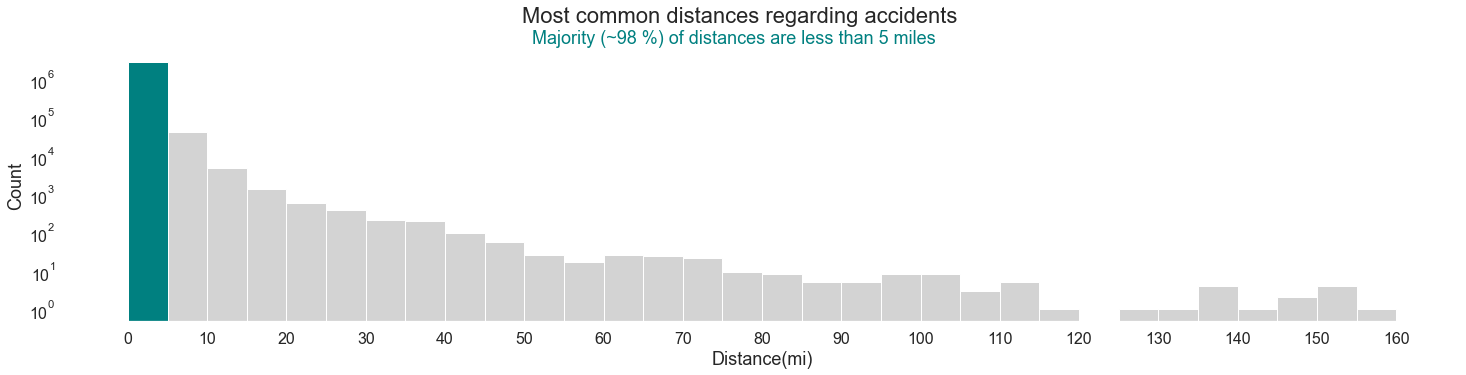

Rectangle(xy=(0, 0), width=5, height=2.79732e+06, angle=0) -> 98.31 %
Rectangle(xy=(5, 0), width=5, height=40226, angle=0) -> 1.41 %
Rectangle(xy=(10, 0), width=5, height=4730, angle=0) -> 0.17 %
Rectangle(xy=(15, 0), width=5, height=1357, angle=0) -> 0.05 %
Rectangle(xy=(20, 0), width=5, height=585, angle=0) -> 0.02 %
Rectangle(xy=(25, 0), width=5, height=374, angle=0) -> 0.01 %
Rectangle(xy=(30, 0), width=5, height=215, angle=0) -> 0.01 %
Rectangle(xy=(35, 0), width=5, height=200, angle=0) -> 0.01 %
Rectangle(xy=(40, 0), width=5, height=95, angle=0) -> 0.0 %
Rectangle(xy=(45, 0), width=5, height=56, angle=0) -> 0.0 %
Rectangle(xy=(50, 0), width=5, height=25, angle=0) -> 0.0 %
Rectangle(xy=(55, 0), width=5, height=17, angle=0) -> 0.0 %
Rectangle(xy=(60, 0), width=5, height=25, angle=0) -> 0.0 %
Rectangle(xy=(65, 0), width=5, height=24, angle=0) -> 0.0 %
Rectangle(xy=(70, 0), width=5, height=21, angle=0) -> 0.0 %
Rectangle(xy=(75, 0), width=5, height=9, angle=0) -> 0.0 %
Rectangle(xy=(

In [87]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (25,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Distance(mi)", kde=False, binwidth=5)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(10))

# Add and format description text
plt.suptitle("Most common distances regarding accidents", y=1, fontsize=22)
plt.title("Majority (~98 %) of distances are less than 5 miles", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Distance(mi)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() < 5:
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

As there are lot of observations, the decision is to keep only observations with *Distance(mi)* feature value is less than 5 miles and exclude the other ones.

__❌ Drop__

48.016  / 1.69  % (where distance >= 5)

__✔️ Keep__ 

2.797.325  / 98.31  % (where distance < 5)




In [88]:
# Perform calculations and track observations to drop
outlier_keep_drop_less(us_accidents_preprocessed, "Distance(mi)", 5)
# Track information
features_to_preprocess.remove("Distance(mi)")

Keep: # 2797325 / 98.31  %
Drop: # 48016 / 1.69  %


### [Pressure(in)] Feature

According to the first check during data description phase (Task 1) there was an indicator that the *Pressure(in)* feature is disproportionally distributed and as a result skewed.

In addition to that the min. value of 0.0 and max. value of 58.9 seems erroneous after research of the normal range of barometric pressure, that is denoted between 29 and 31.

🧷 __Note__

- Source 1: https://www.masterclass.com/articles/how-barometric-pressure-works#what-is-barometric-pressure
- Source 2: https://www.thoughtco.com/how-to-read-a-barometer-3444043
- Source 3: https://www.guinnessworldrecords.com/world-records/lowest-barometric-pressure
- Source 4: https://www.guinnessworldrecords.com/world-records/highest-barometric-pressure-


#### Step 1: Check distribution type

It turns out that the *Pressure(in)* feature has the following characteristics:

__Shape__

Non-symmetric left-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~29.48, but less accurate (due to skewness)
- Median is 29.82 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~1.04, but less accurate (due to skewness)
- IQR is 0.68 and more accurate 

In [89]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Pressure(in)"].mean()
median_distance = us_accidents_preprocessed["Pressure(in)"].median()
std_distance = us_accidents_preprocessed["Pressure(in)"].std()
q1_distance = us_accidents_preprocessed["Pressure(in)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Pressure(in)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Pressure(in)"))


mean: 29.479577562034265
median: 29.82
std: 1.0355450282834755
iqr: 0.6800000000000033
Distribution type: Non-symmetric highly left-skewed distribution (skewness: -3.3008)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Pressure(in)* feature is a non-symmetric left-skewed distribution. 

__🔎 Analysis Result__

The majority (~94 %) of barometic pressures are between 28 and less than 32

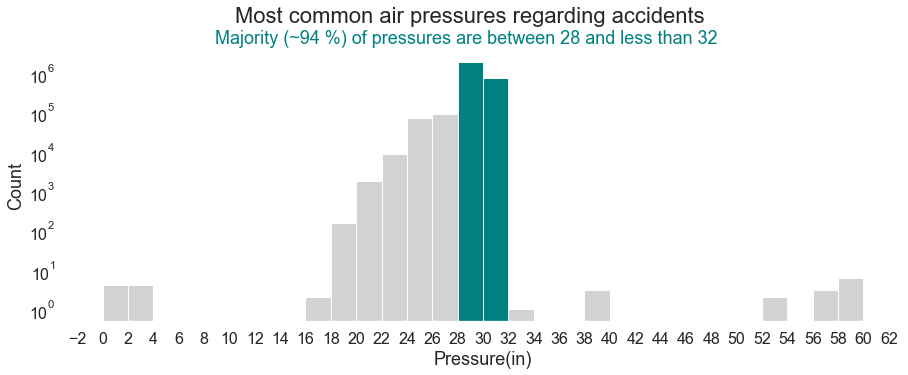

Rectangle(xy=(0, 0), width=2, height=4, angle=0) -> 0.0 %
Rectangle(xy=(2, 0), width=2, height=4, angle=0) -> 0.0 %
Rectangle(xy=(4, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(6, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(8, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(10, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(12, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(14, 0), width=2, height=0, angle=0) -> 0.0 %
Rectangle(xy=(16, 0), width=2, height=2, angle=0) -> 0.0 %
Rectangle(xy=(18, 0), width=2, height=154, angle=0) -> 0.01 %
Rectangle(xy=(20, 0), width=2, height=1763, angle=0) -> 0.06 %
Rectangle(xy=(22, 0), width=2, height=8611, angle=0) -> 0.3 %
Rectangle(xy=(24, 0), width=2, height=72610, angle=0) -> 2.55 %
Rectangle(xy=(26, 0), width=2, height=92598, angle=0) -> 3.25 %
Rectangle(xy=(28, 0), width=2, height=1.9174e+06, angle=0) -> 67.39 %
Rectangle(xy=(30, 0), width=2, height=752180, angle=0) -> 26.44 %
Rectangle(xy=(32, 0), w

In [90]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Pressure(in)", kde=False, binwidth=2)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(2))

# Add and format description text
plt.suptitle("Most common air pressures regarding accidents", y=1, fontsize=22)
plt.title("Majority (~94 %) of pressures are between 28 and less than 32", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Pressure(in)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() >= 28 and rectangle.get_x() < 32 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

As there are lot of observations and all values that are not within the normal range for barometric pressure seems erroneous, the decision is to keep only observations with *Pressure(in)* feature values that are between 28 and less than 32 and exclude the other ones.

__❌ Drop__

175.761 / 6.18  % (where distance < 28 and >= 32)

__✔️ Keep__ 

2.669.580 / 93.82  % (where distance >= 28 and < 28)


In [91]:
# Perform calculations and track observations to drop
outlier_keep_drop_range(us_accidents_preprocessed,"Pressure(in)", 28, 32)
# Track information
features_to_preprocess.remove("Pressure(in)")

Keep: # 2669580 / 93.82  %
Drop: # 175761 / 6.18  %


### [Temperature(F)] Feature

According to the first check during data description phase (Task 1) there was an indicator that the *Temperature(F)* feature is disproportionally distributed and as a result skewed.

In addition to that the min. value of -89.0 and max. value of 196.0 seems erroneous after research of the normal range of temperature, that is denoted between 28 and 79 (average).

🧷 __Note__

- Source 1: https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php
- Source 2: https://www.currentresults.com/Weather-Extremes/US/hottest.php
- Source 3: https://www.currentresults.com/Weather-Extremes/US/coldest.php


#### Step 1: Check distribution type

It turns out that the *Temperature(F)* feature has the following characteristics:

__Shape__

Non-symmetric left-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~61.81, but less accurate (due to skewness)
- Median is 63.0 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~18.47, but less accurate (due to skewness)
- IQR is 26.0 and more accurate 

In [92]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Temperature(F)"].mean()
median_distance = us_accidents_preprocessed["Temperature(F)"].median()
std_distance = us_accidents_preprocessed["Temperature(F)"].std()
q1_distance = us_accidents_preprocessed["Temperature(F)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Temperature(F)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Temperature(F)"))


mean: 61.80961455938684
median: 64.0
std: 18.47097069649951
iqr: 26.0
Distribution type: Approximately symmetric distribution (skewness: -0.49209)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Temperature(F)* feature is a non-symmetric left-skewed distribution. 

__🔎 Analysis Result__

The majority (~91 %) of temperatures are between 31 and less than 91

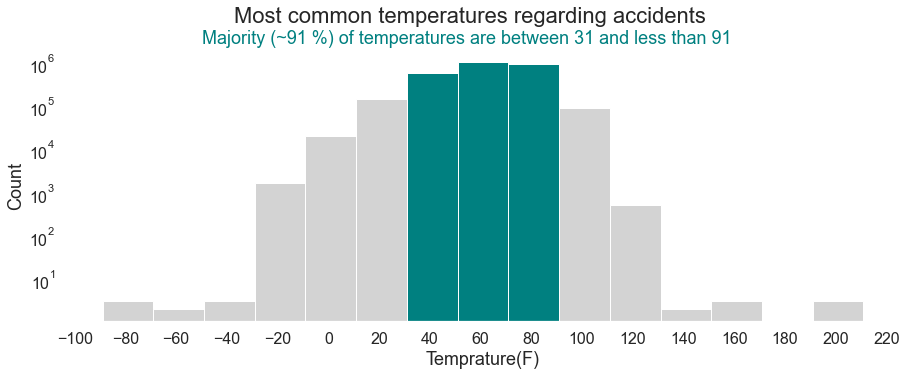

Rectangle(xy=(-89, 0), width=20, height=3, angle=0) -> 0.0 %
Rectangle(xy=(-69, 0), width=20, height=2, angle=0) -> 0.0 %
Rectangle(xy=(-49, 0), width=20, height=3, angle=0) -> 0.0 %
Rectangle(xy=(-29, 0), width=20, height=1665, angle=0) -> 0.06 %
Rectangle(xy=(-9, 0), width=20, height=20264, angle=0) -> 0.71 %
Rectangle(xy=(11, 0), width=20, height=146298, angle=0) -> 5.14 %
Rectangle(xy=(31, 0), width=20, height=596196, angle=0) -> 20.95 %
Rectangle(xy=(51, 0), width=20, height=1.05468e+06, angle=0) -> 37.07 %
Rectangle(xy=(71, 0), width=20, height=935793, angle=0) -> 32.89 %
Rectangle(xy=(91, 0), width=20, height=89921, angle=0) -> 3.16 %
Rectangle(xy=(111, 0), width=20, height=505, angle=0) -> 0.02 %
Rectangle(xy=(131, 0), width=20, height=2, angle=0) -> 0.0 %
Rectangle(xy=(151, 0), width=20, height=3, angle=0) -> 0.0 %
Rectangle(xy=(171, 0), width=20, height=0, angle=0) -> 0.0 %
Rectangle(xy=(191, 0), width=20, height=3, angle=0) -> 0.0 %


In [93]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Temperature(F)", kde=False, binwidth=20)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(20))

# Add and format description text
plt.suptitle("Most common temperatures regarding accidents", y=1, fontsize=22)
plt.title("Majority (~91 %) of temperatures are between 31 and less than 91", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Temprature(F)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)
plt.xticks(rotation=0)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() >= 31 and rectangle.get_x() < 91 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

As there are lot of observations and all values that are not within the 1.5-IQR rule seems erroneous, the decision is to keep only observations with *Temperature(F)* feature values that are between 11 and less than 115 and exclude the other ones.

__❌ Drop__

22.019 / 0.77 % (where distance < 11 and >= 115)

__✔️ Keep__ 

2.823.322 / 93.23 % (where distance >= 11 and < 115)


In [94]:
# Perform calculations and track observations to drop
outlier_keep_drop_range(us_accidents_preprocessed,"Temperature(F)", 11, 115)
# Track information
features_to_preprocess.remove("Temperature(F)")

Keep: # 2823322 / 99.23  %
Drop: # 22019 / 0.77  %


### [Wind_Chill(F)] Feature

According to the first check during data description phase (Task 1) there was an indicator that the *Wind_Chill(F)* feature is disproportionally distributed and as a result skewed.

In addition to that the min. value of -89.0 and max. value of 196.0 seems erroneous after research of wind chill.

🧷 __Note__

- Source 1: https://www.weather.gov/safety/cold-faqs
- Soruce 2: https://www.weatherbug.com/news/Science-of-Wind-Chill

#### Step 1: Check distribution type

It turns out that the *Wind_Chill(F)* feature has the following characteristics:

__Shape__

Non-symmetric left-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~60.21, but less accurate (due to skewness)
- Median is 63.0 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~19.38, but less accurate (due to skewness)
- IQR is 22.0 and more accurate 

In [95]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Wind_Chill(F)"].mean()
median_distance = us_accidents_preprocessed["Wind_Chill(F)"].median()
std_distance = us_accidents_preprocessed["Wind_Chill(F)"].std()
q1_distance = us_accidents_preprocessed["Wind_Chill(F)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Wind_Chill(F)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Wind_Chill(F)"))

mean: 60.209811583205955
median: 63.0
std: 19.3756407946604
iqr: 22.0
Distribution type: Non-symmetric moderately left-skewed distribution (skewness: -0.85494)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Wind_Chill(F)* feature is a non-symmetric left-skewed distribution. 

__🔎 Analysis Result__

The majority (~89 %) of wind chills are between 31 and less than 91

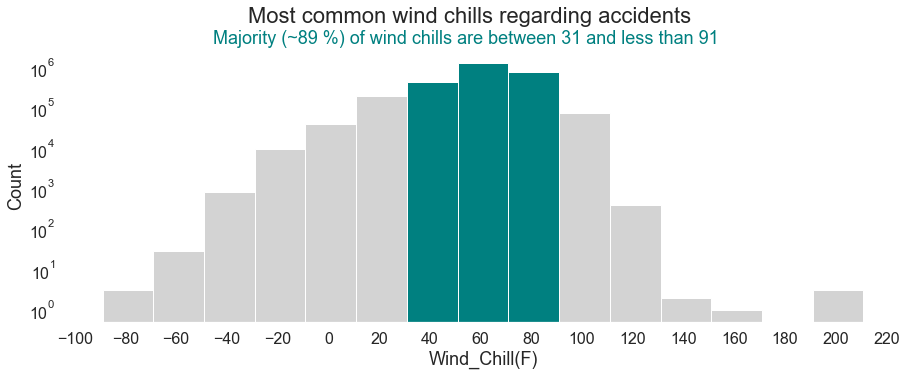

Rectangle(xy=(-89, 0), width=20, height=3, angle=0) -> 0.0 %
Rectangle(xy=(-69, 0), width=20, height=29, angle=0) -> 0.0 %
Rectangle(xy=(-49, 0), width=20, height=828, angle=0) -> 0.03 %
Rectangle(xy=(-29, 0), width=20, height=9444, angle=0) -> 0.33 %
Rectangle(xy=(-9, 0), width=20, height=38835, angle=0) -> 1.36 %
Rectangle(xy=(11, 0), width=20, height=200288, angle=0) -> 7.04 %
Rectangle(xy=(31, 0), width=20, height=436644, angle=0) -> 15.35 %
Rectangle(xy=(51, 0), width=20, height=1.31771e+06, angle=0) -> 46.31 %
Rectangle(xy=(71, 0), width=20, height=767912, angle=0) -> 26.99 %
Rectangle(xy=(91, 0), width=20, height=73257, angle=0) -> 2.57 %
Rectangle(xy=(111, 0), width=20, height=381, angle=0) -> 0.01 %
Rectangle(xy=(131, 0), width=20, height=2, angle=0) -> 0.0 %
Rectangle(xy=(151, 0), width=20, height=1, angle=0) -> 0.0 %
Rectangle(xy=(171, 0), width=20, height=0, angle=0) -> 0.0 %
Rectangle(xy=(191, 0), width=20, height=3, angle=0) -> 0.0 %


In [96]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Wind_Chill(F)", kde=False, binwidth=20)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(20))

# Add and format description text
plt.suptitle("Most common wind chills regarding accidents", y=1, fontsize=22)
plt.title("Majority (~89 %) of wind chills are between 31 and less than 91", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Wind_Chill(F)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() >= 31 and rectangle.get_x() < 91 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

As there are lot of observations and all values that are not within the 1.5-IQR rule seems erroneous, the decision is to keep only observations with *Wind_Chill(F)* feature values that are between 1 and less than 121 and exclude the other ones.

__❌ Drop__

22.433 / 0.79 % (where distance < 1 and >= 121)

__✔️ Keep__ 

2.822.908 / 99.21 % (where distance >= 1 and < 121)

In [97]:
# Perform calculations and track observations to drop
outlier_keep_drop_range(us_accidents_preprocessed,"Wind_Chill(F)", 1, 121)
# Track information
features_to_preprocess.remove("Wind_Chill(F)")

Keep: # 2822908 / 99.21  %
Drop: # 22433 / 0.79  %


### [Wind_Speed(mph)] Feature

According to the first check during data description phase (Task 1) there was an indicator that the *Wind_Speed(mph)* feature is disproportionally distributed and as a result skewed.

In addition to that max. value of 1087.0 seems erroneous after research of wind speed.

🧷 __Note__

- Source: https://www.thoughtco.com/fast-wind-speed-recorded-3444498

#### Step 1: Check distribution type

It turns out that the *Wind_Speed(mph)* feature has the following characteristics:

__Shape__

Non-symmetric right-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~6.98, but less accurate (due to skewness)
- Median is 6.9 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~5.63, but less accurate (due to skewness)
- IQR is 7.0 and more accurate 

In [98]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Wind_Speed(mph)"].mean()
median_distance = us_accidents_preprocessed["Wind_Speed(mph)"].median()
std_distance = us_accidents_preprocessed["Wind_Speed(mph)"].std()
q1_distance = us_accidents_preprocessed["Wind_Speed(mph)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Wind_Speed(mph)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Wind_Speed(mph)"))

mean: 6.984550182217663
median: 6.9
std: 5.632397433677373
iqr: 7.0
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 9.24306)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Wind_Speed(mph)* feature is a non-symmetric right-skewed distribution. 

__🔎 Analysis Result__

The majority (~100 %) of wind chills are less than 100

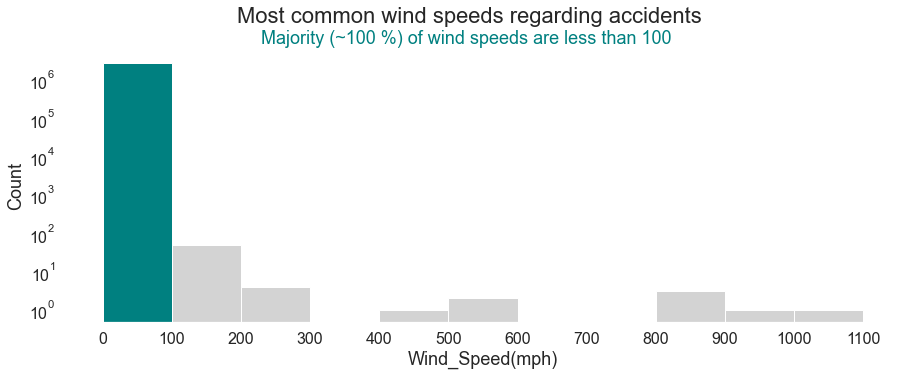

Rectangle(xy=(0, 0), width=100, height=2.84528e+06, angle=0) -> 100.0 %
Rectangle(xy=(100, 0), width=100, height=49, angle=0) -> 0.0 %
Rectangle(xy=(200, 0), width=100, height=4, angle=0) -> 0.0 %
Rectangle(xy=(300, 0), width=100, height=0, angle=0) -> 0.0 %
Rectangle(xy=(400, 0), width=100, height=1, angle=0) -> 0.0 %
Rectangle(xy=(500, 0), width=100, height=2, angle=0) -> 0.0 %
Rectangle(xy=(600, 0), width=100, height=0, angle=0) -> 0.0 %
Rectangle(xy=(700, 0), width=100, height=0, angle=0) -> 0.0 %
Rectangle(xy=(800, 0), width=100, height=3, angle=0) -> 0.0 %
Rectangle(xy=(900, 0), width=100, height=1, angle=0) -> 0.0 %
Rectangle(xy=(1000, 0), width=100, height=1, angle=0) -> 0.0 %


In [99]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Wind_Speed(mph)", kde=False, binwidth=100)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(100))

# Add and format description text
plt.suptitle("Most common wind speeds regarding accidents", y=1, fontsize=22)
plt.title("Majority (~100 %) of wind speeds are less than 100", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Wind_Speed(mph)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() < 100 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

As there are lot of observations the decision is to keep only observations with *Wind_Speed(mph)* feature values that are less than 100 and exclude the other ones.

__❌ Drop__

61 / 0.0 % (where distance < 100)

__✔️ Keep__ 

2.845.280 / 100.0 % (where distance >= 100)

In [100]:
# Perform calculations and track observations to drop
outlier_keep_drop_less(us_accidents_preprocessed, "Wind_Speed(mph)", 100)
# Track information
features_to_preprocess.remove("Wind_Speed(mph)")

Keep: # 2845280 / 100.0  %
Drop: # 61 / 0.0  %


## <a id="chapter-5-new"></a>Derive new features

New features are derived: *Year*, *Month*, *Day*, *Weekday*, *Hour*, *Second*, *Duration(h)*, *Sun_Position*, *Rainfall*, *Visibility*, *Street_Type*, *Rain*, *Fog* and *Snow*

After creation of new features the following feature are dropped: *Start_Time*, *End_Time*, *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twilight*, *Astronomical_Twilight*, *Precipitation(in)*, *Visibility(mi)* and *Weather_Condition*

### [Year] Feature

New ordinal feature reprecenting the year.

Based on feature
- Start_Time

Mapping rules
- Strip year from *Start_Time*

In [101]:
# Populate new column year with year
us_accidents_preprocessed["Year"] = us_accidents_preprocessed["Start_Time"].dt.year

# Ensure that mapping to new feature was successfull
assert "Year" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Year")

# Track information
class_ordinal_features.add("Year")
features_new_created.remove("Year")

Type: <class 'numpy.dtype[int64]'>
Min: 2016
Max: 2021
Missing absolute (#): 0
Missing relative (%): 0
Mode: 2021
Mode frequency: 1511744


### [Month] Feature

New ordinal feature reprecenting the month.

Based on feature
- *Start_Time*

Mapping rules
- Strip month from *Start_Time*

In [102]:
# Populate new column month with month
us_accidents_preprocessed["Month"] = us_accidents_preprocessed["Start_Time"].dt.month

# Ensure that mapping to new feature was successfull
assert "Month" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Month")

# Track information
class_ordinal_features.add("Month")
features_new_created.remove("Month")

Type: <class 'numpy.dtype[int64]'>
Min: 1
Max: 12
Missing absolute (#): 0
Missing relative (%): 0
Mode: 12
Mode frequency: 473943


### [Day] Feature

New ordinal feature reprecenting the day.

Based on feature
- *Start_Time*

Mapping rules
- Strip day from *Start_Time*

In [103]:
# Populate new column day with day
us_accidents_preprocessed["Day"] = us_accidents_preprocessed["Start_Time"].dt.day

# Ensure that mapping to new feature was successfull
assert "Day" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Day")

# Track information
class_ordinal_features.add("Day")
features_new_created.remove("Day")

Type: <class 'numpy.dtype[int64]'>
Min: 1
Max: 31
Missing absolute (#): 0
Missing relative (%): 0
Mode: 23
Mode frequency: 106831


### [Weekday] Feature

New ordinal feature reprecenting the day of week.

Based on feature
- *Start_Time*

Mapping rules
- Strip weekday from *Start_Time*
- Monday=0, Sunday=6

In [104]:
# Populate new column weekday with calculated day of week
us_accidents_preprocessed["Weekday"] = us_accidents_preprocessed["Start_Time"].dt.weekday

# Ensure that mapping to new feature was successfull
assert "Weekday" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Weekday")

# Track information
class_ordinal_features.add("Weekday")
features_new_created.remove("Weekday")

Type: <class 'numpy.dtype[int64]'>
Min: 0
Max: 6
Missing absolute (#): 0
Missing relative (%): 0
Mode: 4
Mode frequency: 492074


### [Hour] Feature

New ordinal feature reprecenting the hour.

Based on feature
- *Start_Time*

Mapping rules
- Strip hour from *Start_Time*

In [105]:
# Populate new column hour with hour
us_accidents_preprocessed["Hour"] = us_accidents_preprocessed["Start_Time"].dt.hour

# Ensure that mapping to new feature was successfull
assert "Hour" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Hour")

# Track information
class_ordinal_features.add("Hour")
features_new_created.remove("Hour")

Type: <class 'numpy.dtype[int64]'>
Min: 0
Max: 23
Missing absolute (#): 0
Missing relative (%): 0
Mode: 17
Mode frequency: 220358


### [Minute] Feature

New ordinal feature reprecenting the minute.

Based on feature
- *Start_Time*

Mapping rules
- Strip minute from *Start_Time*

In [106]:
# Populate new column hour with hour
us_accidents_preprocessed["Minute"] = us_accidents_preprocessed["Start_Time"].dt.minute

# Ensure that mapping to new feature was successfull
assert "Minute" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Minute")

# Track information
class_ordinal_features.add("Minute")
features_new_created.remove("Minute")

Type: <class 'numpy.dtype[int64]'>
Min: 0
Max: 59
Missing absolute (#): 0
Missing relative (%): 0
Mode: 45
Mode frequency: 49580


### [Second] Feature

New ordinal feature reprecenting the second.

Based on feature
- *Start_Time*

Mapping rules
- Strip second from *Start_Time*

In [107]:
# Populate new column seconds with seconds
us_accidents_preprocessed["Second"] = us_accidents_preprocessed["Start_Time"].dt.second

# Ensure that mapping to new feature was successfull
assert "Second" in us_accidents_preprocessed.columns

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Second")

# Track information
class_ordinal_features.add("Second")
features_new_created.remove("Second")

Type: <class 'numpy.dtype[int64]'>
Min: 0
Max: 59
Missing absolute (#): 0
Missing relative (%): 0
Mode: 0
Mode frequency: 1121211


### [Duration(h)] Feature

New numeric ratio-scaled feature showing the duration in hours meaning the impact due to the accident.

Based on feature
- *Start_Time* (dropped afterwards, assumption new *Year*, *Month*, *Day*, *Weekday*, *Hour*, *Minute* and *Second* features have been already created)
- *End_Time* (dropped afterwards)

In [108]:
# Populate new column duration with calculated duration in hours
us_accidents_preprocessed["Duration(h)"] = (pd.to_datetime(us_accidents_preprocessed["End_Time"]) - pd.to_datetime(us_accidents_preprocessed["Start_Time"]))
us_accidents_preprocessed["Duration(h)"] = round((us_accidents_preprocessed["Duration(h)"].dt.days * 24) + (us_accidents_preprocessed["Duration(h)"].dt.seconds / 3600),2)

# Drop Start_Time and End_Time feature
us_accidents_preprocessed.drop(columns=["Start_Time", "End_Time"], inplace=True, errors="ignore")

# Ensure that creation of new feature was successfull
assert "Duration(h)" in us_accidents_preprocessed.columns
assert "Start_Time" not in us_accidents_preprocessed.columns
assert "End_Time" not in us_accidents_preprocessed.columns

# Show info
data_info_num_ratio_attribute(us_accidents_preprocessed, "Duration(h)")

# Track information
class_num_ratio_scaled_features.add("Duration(h)")
class_date_time_features.remove("Start_Time")
class_date_time_features.remove("End_Time")
features_new_created.remove("Duration(h)")
features_to_drop_after_deriving_new_features.remove("Start_Time")
features_to_drop_after_deriving_new_features.remove("End_Time")

Type: <class 'numpy.dtype[float64]'>
Min: 0.03
Max: 28042.99
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Duration(h) <= -2.52 - values #: 0 / %: 0.0
potential outlier when Duration(h) >= 7.48 - values #: 139145 / %: 4.8903
potential total outlier values #: 139145 / %: 4.8903


#### Step 1: Check distribution type

It turns out that the *Duration(h)* feature has the following characteristics:

__Shape__

Non-symmetric right-skewed distribution.

__Central Tendency (Location Metrics)__

- Mean is ~5.92, but less accurate (due to skewness)
- Median is 2.00 and more accurate 

__Spread of Data (Variability Metrics)__

- Standard Deviation is ~155.55, but less accurate (due to skewness)
- IQR is 2.54 and more accurate 

In [109]:
# Perform calculations
mean_distance = us_accidents_preprocessed["Duration(h)"].mean()
median_distance = us_accidents_preprocessed["Duration(h)"].median()
std_distance = us_accidents_preprocessed["Duration(h)"].std()
q1_distance = us_accidents_preprocessed["Duration(h)"].quantile(0.25)
q3_distance = us_accidents_preprocessed["Duration(h)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
# Print information
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed, "Duration(h)"))

mean: 5.983841483318054
median: 2.0
std: 155.4986651673509
iqr: 2.5
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 64.61275)


#### Step 2: Visualize distribution

The histogram confirms the findings out of step 1: the *Duration(h)* feature is a non-symmetric right-skewed distribution. 

__🔎 Analysis Result__

- The majority (~99.96 %) of durations are less than ~1402
- The majority (~85.31 %) of durations are less than ~3 or between 5 and less ~6 

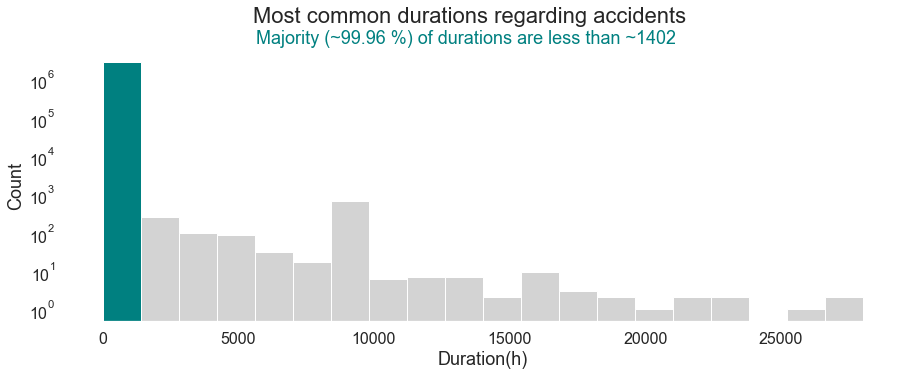

Rectangle(xy=(0.03, 0), width=1402.15, height=2.84416e+06, angle=0) -> 99.96 %
Rectangle(xy=(1402.18, 0), width=1402.15, height=254, angle=0) -> 0.01 %
Rectangle(xy=(2804.33, 0), width=1402.15, height=99, angle=0) -> 0.0 %
Rectangle(xy=(4206.47, 0), width=1402.15, height=88, angle=0) -> 0.0 %
Rectangle(xy=(5608.62, 0), width=1402.15, height=30, angle=0) -> 0.0 %
Rectangle(xy=(7010.77, 0), width=1402.15, height=17, angle=0) -> 0.0 %
Rectangle(xy=(8412.92, 0), width=1402.15, height=652, angle=0) -> 0.02 %
Rectangle(xy=(9815.07, 0), width=1402.15, height=6, angle=0) -> 0.0 %
Rectangle(xy=(11217.2, 0), width=1402.15, height=7, angle=0) -> 0.0 %
Rectangle(xy=(12619.4, 0), width=1402.15, height=7, angle=0) -> 0.0 %
Rectangle(xy=(14021.5, 0), width=1402.15, height=2, angle=0) -> 0.0 %
Rectangle(xy=(15423.7, 0), width=1402.15, height=9, angle=0) -> 0.0 %
Rectangle(xy=(16825.8, 0), width=1402.15, height=3, angle=0) -> 0.0 %
Rectangle(xy=(18228, 0), width=1402.15, height=2, angle=0) -> 0.0 %
Rec

In [110]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed, x="Duration(h)", kde=False, bins=20)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("Most common durations regarding accidents", y=1, fontsize=22)
plt.title("Majority (~99.96 %) of durations are less than ~1402", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Duration(h)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() < 1402 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

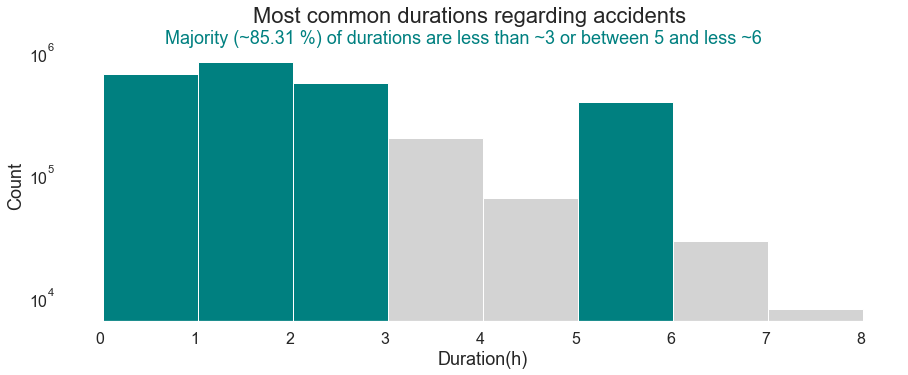

Rectangle(xy=(0.03, 0), width=1, height=651591, angle=0) -> 22.9 %
Rectangle(xy=(1.03, 0), width=1, height=821823, angle=0) -> 28.88 %
Rectangle(xy=(2.03, 0), width=1, height=550375, angle=0) -> 19.34 %
Rectangle(xy=(3.03, 0), width=1, height=194847, angle=0) -> 6.85 %
Rectangle(xy=(4.03, 0), width=1, height=63811, angle=0) -> 2.24 %
Rectangle(xy=(5.03, 0), width=1, height=387375, angle=0) -> 13.61 %
Rectangle(xy=(6.03, 0), width=1, height=28252, angle=0) -> 0.99 %
Rectangle(xy=(7.03, 0), width=1, height=7922, angle=0) -> 0.28 %


In [111]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Filter according to 1.5-IQR rule
filtered = us_accidents_preprocessed[ 
    us_accidents_preprocessed["Duration(h)"] < 7.48
]

# Generate histogram
hist = sns.histplot(data=filtered, x="Duration(h)", kde=False, binwidth=1)

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Add and format description text
plt.suptitle("Most common durations regarding accidents", y=1, fontsize=22)
plt.title("Majority (~85.31 %) of durations are less than ~3 or between 5 and less ~6 ", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Duration(h)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if (rectangle.get_x() < 3) | (rectangle.get_x() > 5) & (rectangle.get_x() < 6):
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### Step 3: Decide about exclusion of observations

According to the definition of a traffic event (https://arxiv.org/abs/1909.09638) that is represented within the data set, the following types have been considered: *Accident*, *Broken-Vehicle*, *Congestion*, *Construction*, *Event*, *Lane-blocked* and *Flow-incident* but unfortunately not represented as dedicated feature.

With that in mind also the max. value with 28.042,99 hours (over 3 years) are explainable by a long-running construction work and not an erroneous observation.

As there are a lot of observations the decision is to keep only observations with *Duration(h)* feature values that are less than 7.48 and exclude the other ones (that are not within the 1.5-IQR rule). 

The scope for the further analysis should be on observations that have only a short-term traffic impact and less long-running construction work.

__❌ Drop__

124.812 / 4.79 % (where distance < 7.48)

__✔️ Keep__ 

2.478.984 / 95.21 % (where distance >= 7.48)

In [112]:
# Perform calculations and track observations to drop
outlier_keep_drop_less(us_accidents_preprocessed, "Duration(h)", 7.48)

Keep: # 2705996 / 95.1  %
Drop: # 139345 / 4.9  %


### [Sun_Position] Feature

New nomimal feature with 4 levels representing the position of the sun.

Based on feature
- *Sunrise_Sunset* (dropped afterwards)
- *Civil_Twilight* (dropped afterwards)
- *Nautical_Twilight* (dropped afterwards)
- *Astronomical_Twilight* (dropped afterwards)

Mapping rules 
- Day: *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twilight*, *Astronomical_Twilight* equal to *Day*
- Night: *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twilight*, *Astronomical_Twilight* equal to *Night*
- Civil Twilight: 
  - *Sunrise_Sunset* equal to *Night* and 
  - *Civil_Twilight*, *Nautical_Twilight*, *Astronomical_Twilight* equal to *Day*
- Nautical Twilight: 
  - *Sunrise_Sunset*, *Civil_Twilight* equal to *Night* and
  - *Nautical_Twilight*, *Astronomical_Twilight* equal to *Day*
- Astronomical Twilight: 
  - *Sunrise_Sunset*, *Civil_Twilight*, *Nautical_Twilight* equal to *Night* and 
  - *Astronomical_Twilight* equal to *Day*


In [113]:
# Populate new column sun position with day level
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Day") &
    (us_accidents_preprocessed["Civil_Twilight"] == "Day") &
    (us_accidents_preprocessed["Nautical_Twilight"] == "Day") &
    (us_accidents_preprocessed["Astronomical_Twilight"] == "Day")
, "Sun_Position"] = "Day"

# Populate new column sun position with night level
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Night") &
    (us_accidents_preprocessed["Civil_Twilight"] == "Night") &
    (us_accidents_preprocessed["Nautical_Twilight"] == "Night") &
    (us_accidents_preprocessed["Astronomical_Twilight"] == "Night")
, "Sun_Position"] = "Night"

# Populate new column sun position with civil twilight level
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Night") &
    (us_accidents_preprocessed["Civil_Twilight"] == "Day") &
    (us_accidents_preprocessed["Nautical_Twilight"] == "Day") &
    (us_accidents_preprocessed["Astronomical_Twilight"] == "Day")
, "Sun_Position"] = "Civil Twilight"

# Populate new column sun position with civil twilight level
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Night") &
    (us_accidents_preprocessed["Civil_Twilight"] == "Night") &
    (us_accidents_preprocessed["Nautical_Twilight"] == "Day") &
    (us_accidents_preprocessed["Astronomical_Twilight"] == "Day")
, "Sun_Position"] = "Nautical Twilight"

# Populate new column sun position with Astronomical twilight level
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Night") &
    (us_accidents_preprocessed["Civil_Twilight"] == "Night") &
    (us_accidents_preprocessed["Nautical_Twilight"] == "Night") &
    (us_accidents_preprocessed["Astronomical_Twilight"] == "Day")
, "Sun_Position"] = "Astronomical Twilight"

# Populate new column sun position with day level, where original twilight values seems ambiguous
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sun_Position"].isnull()) &
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Day")
, "Sun_Position"] = "Day"

# Populate new column sun position with night level, where original twilight values seems ambiguous
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Sun_Position"].isnull()) &
    (us_accidents_preprocessed["Sunrise_Sunset"] == "Night")
, "Sun_Position"] = "Night"

# Drop Precipitation(in) feature
columns_to_drop = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
us_accidents_preprocessed.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
for item in columns_to_drop:
    assert item not in us_accidents_preprocessed.columns
assert "Sun_Position" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Sun_Position"].unique()) <= 5

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Sun_Position")

# Track information
class_nominal_features.add("Sun_Position")
features_new_created.remove("Sun_Position")
for item in columns_to_drop:
    class_nominal_features.remove(item)
    features_to_drop_after_deriving_new_features.remove(item)

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 5
Levels (first 100): ['Astronomical Twilight', 'Civil Twilight', 'Day', 'Nautical Twilight', 'Night']
Mode: Day
Mode frequency: 1814802


### [Rainfall] Feature

New ordinal feature with 4 levels (0-3) representing the grade of rainfall.

Based on feature
- *Precipitation(in)* (dropped afterwards)

Mapping rules
| Grade | Description | Precipitation(in) | 
| :-: | :-: | :-: | 
| 0 | No rain | = 0 |
| 1 | Light rain | > 0 and < 0.10 |
| 2 | Moderate rain | >= 0.10 and < 0.30 |
| 3 | Heady rain | >= 0.30 |


🧷 __Note__

Mapping rules based on
- Source 1: https://www.baranidesign.com/faq-articles/2020/1/19/rain-rate-intensity-classification

In [114]:
# Populate new column rainfall with no level (0)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Precipitation(in)"] == 0)
, "Rainfall"] = 0

# Populate new column rainfall with light level (1)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Precipitation(in)"] > 0) &
(us_accidents_preprocessed["Precipitation(in)"] < 0.1) 
, "Rainfall"] = 1

# Populate new column rainfall with moderate level (2)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Precipitation(in)"] >= 0.1) &
(us_accidents_preprocessed["Precipitation(in)"] < 0.3) 
, "Rainfall"] = 2

# Populate new column rainfall with heavy level (3)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Precipitation(in)"] >= 0.3)
, "Rainfall"] = 3

# Convert new feature to int values
us_accidents_preprocessed["Rainfall"] = us_accidents_preprocessed["Rainfall"].astype(int, errors="ignore")

# Drop Precipitation(in) feature
us_accidents_preprocessed.drop(columns=["Precipitation(in)"], inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
assert "Precipitation(in)" not in us_accidents_preprocessed.columns
assert "Rainfall" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Rainfall"].unique()) <= 4

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Rainfall")

# Track information
class_ordinal_features.add("Rainfall")
class_num_ratio_scaled_features.remove("Precipitation(in)")
features_new_created.remove("Rainfall")
features_to_drop_after_deriving_new_features.remove("Precipitation(in)")

Type: <class 'numpy.dtype[int32]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 4
Levels (first 100): [0, 1, 2, 3]
Mode: 0
Mode frequency: 2653699


### [Visibility] Feaure

New ordinal feature with 5 levels indicate the grade of visibility.

Based on feature
- *Visibility(mi)* (dropped afterwards)

Mapping rules

| Grade | Description | Visibility (mi) | 
| :-: | :-: | :-: | 
| 1 | Excellent visibility | > 31 |
| 2 | Good visibility | > 12 and <= 31 |
| 3 | Fair visibility | > 6 and <= 12 |
| 4 | Poor visibility | > 1 and <= 6 |
| 5 | Bad visibility | > 31 |

🧷 __Note__

Mapping rules based on
- Source 1: https://de.wikipedia.org/wiki/Sichtweite

In [115]:
# Populate new column visibility with excellent level (5)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Visibility(mi)"] > 31)
, "Visibility"] = 5

# Populate new column visibility with good level (4)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Visibility(mi)"] > 12) &
(us_accidents_preprocessed["Visibility(mi)"] <= 31) 
, "Visibility"] = 4

# Populate new column rainfall with fair level (3)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Visibility(mi)"] > 6) &
(us_accidents_preprocessed["Visibility(mi)"] <= 12) 
, "Visibility"] = 3

# Populate new column rainfall with poor level (2)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Visibility(mi)"] > 1) &
(us_accidents_preprocessed["Visibility(mi)"] <= 6) 
, "Visibility"] = 2

# Populate new column rainfall with bad level (1)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Visibility(mi)"] <= 1)
, "Visibility"] = 1

# Convert new feature to int values
us_accidents_preprocessed["Visibility"] = us_accidents_preprocessed["Visibility"].astype(int, errors="ignore")

# Drop Visibility feature
us_accidents_preprocessed.drop(columns=["Visibility(mi)"], inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
assert "Visibility(mi)" not in us_accidents_preprocessed.columns
assert "Visibility" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Visibility"].unique()) <= 5

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Visibility")

# Track information
class_ordinal_features.add("Visibility")
class_num_ratio_scaled_features.remove("Visibility(mi)")
features_new_created.remove("Visibility")
features_to_drop_after_deriving_new_features.remove("Visibility(mi)")

Type: <class 'numpy.dtype[int32]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 5
Levels (first 100): [1, 2, 3, 4, 5]
Mode: 3
Mode frequency: 2505416


### [Street_Type] Feature

New nominal feature with 32 levels representing the type of the street.

Based on feature
- *Street*

Mapping Rules
- Road: contains *Rd* or *Road*
- Street: contains *St* or *Avenue*
- Avenue: contains *Ave*
- Boulevard: contains *Blvd*
- Lane: contains *Ln*
- Drive: contains *Dr*
- Way: contains *Way*
- Court: contains *Ct*
- Plaza: contains *Plz*
- Terrace: contains *Ter*
- Place: contains *Pl*
- Frontage Road: contains *Fr*
- Highway: contains *Hwy* or *Highway*
- Interstate: contains *I-* or *Interstate*
- Turnpike: contains *Tpke* or *Pike*
- Freeway: contains *Fwy*
- Parkway: contains *Pkwy*
- Causeway: contains *Cswy*
- Beltway: contains *Bltwy* or *Beltway*
- Crescent: contains *Cres*
- Alley: contains *Aly*
- Esplanade: contains *Esp*
- Expressway: contains *Expy* or *Expressway*
- Bypass: contains *Byp*
- Tunnel: contains *Tunl* or *Tunnel*
- Tollway: contains *Tollway*
- Bridge: contains *Brg* or *Bridge*
- Trail: contains *Trl*
- Loop: contains *Loop*
- Throughway: contains *Trwy*
- Skyway: contains *Skwy*
- Other

🧷 __Note__

Mapping rules based on
- Source 1: https://www.vox.com/2016/11/14/13275486/streets-roads-avenues-names-reasons
- Source 2: https://pe.usps.com/text/pub28/28apc_002.htm
- Source 3: https://simplicable.com/new/streets

In [116]:
def street_type_conditions(value):
    if (" Rd" in value["Street"]) | ("Road" in value["Street"]):
        return "Road"
    elif "St" in value["Street"]:
        return "Street"
    elif (" Ave" in value["Street"]) | ("Avenue" in value["Street"]):
        return "Avenue"
    elif " Blvd" in value["Street"]:
        return "Boulevard"
    elif " Ln" in value["Street"]:
        return "Lane"
    elif " Dr" in value["Street"]:
        return "Drive"
    elif " Way" in value["Street"]:
        return "Way"
    elif " Ct" in value["Street"]:
        return "Court"
    elif " Plz" in value["Street"]:
        return "Plaza"
    elif " Ter" in value["Street"]:
        return "Terrace"
    elif " Pl" in value["Street"]:
        return "Place"
    elif " Fr" in value["Street"]:
        return "Frontage Road"
    elif (" Hwy" in value["Street"]) | ("Highway" in value["Street"]):
        return "Highway"
    elif (" Tpke" in value["Street"]) | ("Pike" in value["Street"]):
        return "Turnpike"
    elif " Fwy" in value["Street"]:
        return "Freeway"
    elif " Pkwy" in value["Street"]:
        return "Parkway"
    elif " Cswy" in value["Street"]:
        return "Causeway"
    elif (" Bltwy" in value["Street"]) | ("Beltway" in value["Street"]):
        return "Beltway"
    elif " Cres" in value["Street"]:
        return "Crescent"
    elif " Aly" in value["Street"]:
        return "Alley"
    elif " Esp" in value["Street"]:
        return "Esplanade"
    elif ("I-" in value["Street"]) | ("Interstate" in value["Street"]):
        return "Interstate"
    elif (" Expy" in value["Street"]) | ("Expressway" in value["Street"]):
        return "Expressway"
    elif " Byp" in value["Street"]:
        return "Bypass"
    elif (" Tunl" in value["Street"]) | ("Tunnel" in value["Street"]):
        return "Tunnel"
    elif "Tollway" in value["Street"]:
        return "Tollway"
    elif (" Brg" in value["Street"]) | ("Bridge" in value["Street"]):
        return "Bridge"
    elif " Trl" in value["Street"]:
        return "Trail"
    elif "Loop" in value["Street"]:
        return "Loop"
    elif " Trwy" in value["Street"]:
        return "Throughway"
    elif " Skwy" in value["Street"]:
        return "Skyway"
    else:
        return "Other"

# Populate new column with values according to conditions
us_accidents_preprocessed["Street_Type"] = us_accidents_preprocessed.apply(street_type_conditions, axis=1)

# Ensure that mapping to new feature was successfull
assert "Street_Type" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Street_Type"].unique()) <= 32

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Street_Type")

# Track information
class_nominal_features.add("Street_Type")
features_new_created.remove("Street_Type")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 32
Levels (first 100): ['Alley', 'Avenue', 'Beltway', 'Boulevard', 'Bridge', 'Bypass', 'Causeway', 'Court', 'Crescent', 'Drive', 'Esplanade', 'Expressway', 'Freeway', 'Frontage Road', 'Highway', 'Interstate', 'Lane', 'Loop', 'Other', 'Parkway', 'Place', 'Plaza', 'Road', 'Skyway', 'Street', 'Terrace', 'Throughway', 'Tollway', 'Trail', 'Tunnel', 'Turnpike', 'Way']
Mode: Interstate
Mode frequency: 789253


### [Rain] Feature

New nominal feature that indicates the existence of rain.

Based on feature
- *Weather_Condition*

Mapping rules
- True: contains *Rain*, *Drizzle* or *Thunderstorm*
- False: other

In [117]:
def rain_conditions(value):
    if ("Rain" in str(value["Weather_Condition"])) | ("Drizzle" in str(value["Weather_Condition"])) \
        | ("Thunderstorm" in str(value["Weather_Condition"])):
        return True
    else:
        return False

# Populate new column with values according to conditions
us_accidents_preprocessed["Rain"] = us_accidents_preprocessed.apply(rain_conditions, axis=1)

# Ensure that mapping to new feature was successfull
assert "Rain" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Rain"].unique()) <= 2

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Rain")

# Track information
class_nominal_features.add("Rain")
features_new_created.remove("Rain")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2649705


### [Fog] Feature

New nominal feature that indicates the existence of fog.

Based on feature
- *Weather_Condition*

Mapping rules
- True: contains *Fog*, *Haze*, *Mist*, *Smoke*, *Dust*, *Ash*, *Sand*
- False: other

In [118]:
def fog_conditions(value):
    if ("Fog" in str(value["Weather_Condition"])) | ("Haze" in str(value["Weather_Condition"])) \
    | ("Mist" in str(value["Weather_Condition"])) | ("Smoke" in str(value["Weather_Condition"])) \
    | ("Dust" in str(value["Weather_Condition"])) | ("Ash" in str(value["Weather_Condition"])) \
    | ("Sand" in str(value["Weather_Condition"])):
        return True
    else:
        return False

# Populate new column with values according to conditions
us_accidents_preprocessed["Fog"] = us_accidents_preprocessed.apply(fog_conditions, axis=1)

# Ensure that mapping to new feature was successfull
assert "Fog" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Fog"].unique()) <= 2

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Fog")

# Track information
class_nominal_features.add("Fog")
features_new_created.remove("Fog")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2755734


### [Snow] Feature

New nominal feature that indicates the existence of snow.

Based on feature
- *Weather_Condition* (dropped afterwards, assumption new *Rain* and *Fog* feature have been already created)

Mapping rules
- True: contains *Snow*, *Ice*, *Sleet*, *Hail*
- False: other

In [119]:
def snow_conditions(value):
    if ("Snow" in str(value["Weather_Condition"])) | ("Ice" in str(value["Weather_Condition"])) \
    | ("Sleet" in str(value["Weather_Condition"])) | ("Hail" in str(value["Weather_Condition"])):
        return True
    else:
        return False

# Populate new column with values according to conditions
us_accidents_preprocessed["Snow"] = us_accidents_preprocessed.apply(snow_conditions, axis=1)

# Drop Precipitation(in) feature
us_accidents_preprocessed.drop(columns=["Weather_Condition"], inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
assert "Weather_Condition" not in us_accidents_preprocessed.columns
assert "Snow" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Snow"].unique()) <= 2

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Snow")

# Track information
class_nominal_features.add("Snow")
features_new_created.remove("Snow")
features_to_drop_after_deriving_new_features.remove("Weather_Condition")

Type: <class 'numpy.dtype[bool_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 2
Levels (first 100): [False, True]
Mode: False
Mode frequency: 2791307


### [Wind_Direction] Feature

New nominal feature that indicates the wind direction, six levels (*WEST, NORTH, SOUTH, EAST, VARIABLE, CALM*).

Based on feature
- *Wind_Direction*

Mapping rules

- *WEST*: contains *WNW*, *W* or *WSW*
- *NORTH*: contains *NW*, *N*, *NE*, *NNW* or *NNE*
- *SOUTH*: contains *SW*, *S*, *SE* or *SSW*
- *EAST*: contains *ENE*, *E* or *ESE*
- *VARIABLE*: contains *VAR*
- *CALM*: contains *Calm*

(Source: https://www.researchgate.net/figure/Classification-of-wind-directions-in-a-four-sectors-b-eight-sectors-c-sixteen_fig1_221914541)

In [120]:
# Transform all values to upper case
us_accidents_preprocessed["Wind_Direction"] = us_accidents_preprocessed["Wind_Direction"].str.upper()

# Populate new column with reduce amount of west related values
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Direction"] == "WNW") |
    (us_accidents_preprocessed["Wind_Direction"] == "W") |
    (us_accidents_preprocessed["Wind_Direction"] == "WSW")
, "Wind_Direction"] = "WEST"

# Populate new column with reduce amount of north related values
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Direction"] == "NW") |
    (us_accidents_preprocessed["Wind_Direction"] == "N") |
    (us_accidents_preprocessed["Wind_Direction"] == "NE") |
    (us_accidents_preprocessed["Wind_Direction"] == "NNW") |
    (us_accidents_preprocessed["Wind_Direction"] == "NNE")
, "Wind_Direction"] = "NORTH"

# Populate new column with reduce amount of south related values
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Direction"] == "SW") |
    (us_accidents_preprocessed["Wind_Direction"] == "S") |
    (us_accidents_preprocessed["Wind_Direction"] == "SE") |
    (us_accidents_preprocessed["Wind_Direction"] == "SSW") |
    (us_accidents_preprocessed["Wind_Direction"] == "SSE")
, "Wind_Direction"] = "SOUTH"

# Populate new column with reduce amount of east related values
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Direction"] == "ENE") |
    (us_accidents_preprocessed["Wind_Direction"] == "E") |
    (us_accidents_preprocessed["Wind_Direction"] == "ESE")
, "Wind_Direction"] = "EAST"

# Populate new column with reduce amount of variable related values
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Direction"] == "VAR") 
, "Wind_Direction"] = "VARIABLE"

# Ensure that mapping to new feature was successfull
assert len(us_accidents_preprocessed["Wind_Direction"].unique()) <= 6

# Show info
data_info_nominal_attribute(us_accidents_preprocessed, "Wind_Direction")

# Track information
features_new_created.remove("Wind_Direction")

Type: <class 'numpy.dtype[object_]'>
Missing absolute (#): 0
Missing relative (%): 0
Number of levels: 6
Levels (first 100): ['CALM', 'EAST', 'NORTH', 'SOUTH', 'VARIABLE', 'WEST']
Mode: SOUTH
Mode frequency: 710198


### [Wind_Force] Feature

New ordinal feature that indicates the wind force, with level 0 to 12 (step 1).

Based on feature
- *Wind_Speed(mph)* (dropped afterwards)

Mapping rules

| Wind Force | Description | Wind Speed (mph) | 
| :-: | :-: | :-: | 
| 0 | Calm |  < 1 |
| 1 | Light Air | >= 1 and <= 3 |
| 2 | Light Breeze | >= 4 and <= 7 |
| 3 | Gentle Breeze | >= 8 and <= 12 |
| 4 | Moderate Breeze | >= 13 and <= 18 |
| 5 | Fresh Breeze | >= 19 and <= 24 |
| 6 | Strong Breeze | >= 25 and <= 31 |
| 7 | Near Gale | >= 32 and <= 38 |
| 8 | Gale | >= 39 and <= 46 |
| 9 | Strong Gale | >= 47 and <= 54 |
| 10 | Storm | >= 55 and <= 63 |
| 11 | Violent Storm | >= 64 and <= 72 |
| 12 | Hurricane | >= 73 |

(Source: https://de.wikipedia.org/wiki/Windgeschwindigkeit and https://www.rmets.org/metmatters/beaufort-scale)

In [121]:
# Populate new column with calm level (0)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Speed(mph)"] < 1.2)
, "Wind_Force"] = 0

# Populate new column with light air level (1)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 1.2) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 4.6) 
, "Wind_Force"] = 1

# Populate new column with light breeze level (2)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 4.6) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 8.1) 
, "Wind_Force"] = 2

# Populate new column with gentle breeze level (3)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 8.1) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 12.7) 
, "Wind_Force"] = 3

# Populate new column with moderate breeze level (4)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 12.7) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 18.4) 
, "Wind_Force"] = 4

# Populate new column with fresh breeze level (5)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 18.4) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 25.3) 
, "Wind_Force"] = 5

# Populate new column with strong breeze level (6)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 25.3) &
(us_accidents_preprocessed["Wind_Speed(mph)"] < 32.2) 
, "Wind_Force"] = 6

# Populate new column with near gale level (7)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 32.2) &
(us_accidents_preprocessed["Wind_Speed(mph)"] <= 39.1) 
, "Wind_Force"] = 7

# Populate new column with gale level (8)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 39.1) &
(us_accidents_preprocessed["Wind_Speed(mph)"] <= 47.2) 
, "Wind_Force"] = 8

# Populate new column with strong gale level (9)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 47.2) &
(us_accidents_preprocessed["Wind_Speed(mph)"] <= 55.2) 
, "Wind_Force"] = 9

# Populate new column with storm level (10)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 55.2) &
(us_accidents_preprocessed["Wind_Speed(mph)"] <= 64.4) 
, "Wind_Force"] = 10

# Populate new column with violent storm level (11)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 64.4) &
(us_accidents_preprocessed["Wind_Speed(mph)"] <= 73.6) 
, "Wind_Force"] = 11

# Populate new column with hurricane level (12)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Speed(mph)"] >= 73.6)
, "Wind_Force"] = 12

# Convert new feature to int values
us_accidents_preprocessed["Wind_Force"] = us_accidents_preprocessed["Wind_Force"].astype(int, errors="ignore")

# Drop Wind_Speed(mph) feature
us_accidents_preprocessed.drop(columns=["Wind_Speed(mph)"], inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
assert "Wind_Speed(mph)" not in us_accidents_preprocessed.columns
assert "Wind_Force" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Wind_Force"].unique()) <= 13

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Wind_Force")

# Track information
class_ordinal_features.add("Wind_Force")
features_new_created.remove("Wind_Force")
features_to_drop_after_deriving_new_features.remove("Wind_Speed(mph)")

Type: <class 'numpy.dtype[int32]'>
Min: 0
Max: 12
Missing absolute (#): 0
Missing relative (%): 0
Mode: 2
Mode frequency: 976673


### [Thermal_Sensation] Feature

New ordinal feature that indicates the thermal sensation, with level -4 to 4 (step 1).

Based on feature
- *Wind_Chill(F)* (dropped afterwards)

Mapping rules

| Level | Description | Feels-like Temperature (Fahrenheit) | 
| :-: | :-: | :-: | 
| -4 | very cold |  <= -38.2 |
| -3 | cold |  > -38.2 and <= -14.8  |
| -2 | cool |  > -14.8 and <= 8.6 |
| -1 | slightly cool | > 8.6 and <= 32 |
| 0 | comfortable | > 32 and <= 68 |
| 1 | slightly warm | > 68 and <= 78.8 |
| 2 | warm | > 78.8 and <= 89.6 |
| 3 | hot | > 89.6 and <= 100.4 |
| 4 | very hot | > 100.4 |

(Source: https://de.wikipedia.org/wiki/Gef%C3%BChlte_Temperatur)

In [122]:
# Populate new column with very cold level (-4)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Chill(F)"] <= -38.2)
, "Thermal_Sensation"] = -4

# Populate new column with cold level (-3)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > -38.2) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= -14.8) 
, "Thermal_Sensation"] = -3

# Populate new column with cool level (-2)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > -14.8) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 8.6) 
, "Thermal_Sensation"] = -2

# Populate new column with slighty cool level (-1)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > 8.6) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 32) 
, "Thermal_Sensation"] = -1

# Populate new column with comfortable level (0)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > 32) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 68) 
, "Thermal_Sensation"] = 0

# Populate new column with slighty warm level (1)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > 68) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 78.8) 
, "Thermal_Sensation"] = 1

# Populate new column with warm level (2)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > 78.8) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 89.6) 
, "Thermal_Sensation"] = 2

# Populate new column with hot level (3)
us_accidents_preprocessed.loc[
(us_accidents_preprocessed["Wind_Chill(F)"] > 89.6) &
(us_accidents_preprocessed["Wind_Chill(F)"] <= 100.4) 
, "Thermal_Sensation"] = 3

# Populate new column with very hot level (4)
us_accidents_preprocessed.loc[
    (us_accidents_preprocessed["Wind_Chill(F)"] > 100.4)
, "Thermal_Sensation"] = 4

# Convert new feature to int values
us_accidents_preprocessed["Thermal_Sensation"] = us_accidents_preprocessed["Thermal_Sensation"].astype(int, errors="ignore")

# Drop Wind_Chill(F) feature
us_accidents_preprocessed.drop(columns=["Wind_Chill(F)"], inplace=True, errors="ignore")

# Ensure that mapping to new feature was successfull
assert "Wind_Chill(F)" not in us_accidents_preprocessed.columns
assert "Thermal_Sensation" in us_accidents_preprocessed.columns
assert len(us_accidents_preprocessed["Thermal_Sensation"].unique()) <= 9

# Show info
data_info_ordinal_attribute(us_accidents_preprocessed, "Thermal_Sensation")

# Track information
class_ordinal_features.add("Thermal_Sensation")
features_new_created.remove("Thermal_Sensation")
features_to_drop_after_deriving_new_features.remove("Wind_Chill(F)")

Type: <class 'numpy.dtype[int32]'>
Min: -4
Max: 4
Missing absolute (#): 0
Missing relative (%): 0
Mode: 0
Mode frequency: 1632772


## <a id="chapter-5-finalize"></a>Finalize Preprocessing

To finalize the preprocessing phase observations must be dropped and the preprocessed data stored.

### Drop observations

After outlier analysis the marked observations are now dropped:

- Absolute: 366.357
- Relative: 12.88 %

In [123]:
# Save dropped outliers as csv file 
us_accidents_preprocessed.loc[list(observations_to_drop)].to_csv("US_Accidents_Dec21_updated_dropped_outlier_observations.csv", index=True, encoding="UTF-8")

# Drop observations coming from outlier analysis
us_accidents_preprocessed.drop(index=observations_to_drop, inplace=True, errors="ignore")

# Show info
absolute = len(observations_to_drop)
relative = round(len(observations_to_drop) / us_accidents_raw.shape[0] * 100, 2)
print("Dropped observations: #", absolute, "/ %", relative)

# Track information
observations_to_drop.clear()

Dropped observations: # 366357 / % 12.88


### Save preprocessed data

The final preprocessed data is stored in a csv-file in order to perform the further analysis ad-hoc without delay.

In [124]:
# Save final preprocessed data as csv file
us_accidents_preprocessed.to_csv("US_Accidents_Dec21_updated_preprocessed.csv", index=False, encoding="UTF-8")

### Ensure that all Todos are done

In [125]:
assert len(features_to_convert) == 0
assert len(features_to_drop) == 0
assert len(features_to_drop_after_deriving_new_features) == 0
assert len(features_to_preprocess) == 0
assert len(features_new_created) == 0
assert len(observations_to_drop) == 0
assert us_accidents_preprocessed.isnull().sum().sum() == 0

## <a id="chapter-5-summary"></a>Summary

The following main information can be provided of the preprocessed data set:

<center><img src="https://raw.githubusercontent.com/anjakuchenbecker/eda_on_traffic_incidents/main/processed_data_summary_figure.jpg" alt="Drawing" style="width: 800px;"/></center>

In [126]:
# Print tracking information
print("#### Classification info ####")
print(f"Text features ({len(class_text_features)}):\n", sorted(class_text_features))
print(f"Unique identifier features ({len(class_unique_identifier_features)}):\n", sorted(class_unique_identifier_features))
print(f"Ordinal features ({len(class_ordinal_features)}):\n", sorted(class_ordinal_features))
print(f"Nominal features ({len(class_nominal_features)}):\n", sorted(class_nominal_features))
print(f"Numeric ratio-scaled features ({len(class_num_ratio_scaled_features)}):\n", sorted(class_num_ratio_scaled_features))
print(f"Numeric interval-scaled features ({len(class_num_interval_scaled_features)}):\n", sorted(class_num_interval_scaled_features))
print(f"Date / Time features ({len(class_date_time_features)}):\n", sorted(class_date_time_features))

#### Classification info ####
Text features (0):
 []
Unique identifier features (0):
 []
Ordinal features (12):
 ['Day', 'Hour', 'Minute', 'Month', 'Rainfall', 'Second', 'Severity', 'Thermal_Sensation', 'Visibility', 'Weekday', 'Wind_Force', 'Year']
Nominal features (26):
 ['Amenity', 'Bump', 'City', 'County', 'Crossing', 'Fog', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Rain', 'Roundabout', 'Side', 'Snow', 'State', 'Station', 'Stop', 'Street', 'Street_Type', 'Sun_Position', 'Timezone', 'Traffic_Calming', 'Traffic_Signal', 'Weather_Condition', 'Wind_Direction', 'Zipcode']
Numeric ratio-scaled features (7):
 ['Distance(mi)', 'Duration(h)', 'Humidity(%)', 'Pressure(in)', 'Start_Lat', 'Start_Lng', 'Wind_Speed(mph)']
Numeric interval-scaled features (2):
 ['Temperature(F)', 'Wind_Chill(F)']
Date / Time features (0):
 []


In [127]:
# Show basic information of the processed data set
us_accidents_preprocessed.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478984 entries, 0 to 2845341
Data columns (total 44 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Severity           2478984 non-null  int64  
 1   Start_Lat          2478984 non-null  float64
 2   Start_Lng          2478984 non-null  float64
 3   Distance(mi)       2478984 non-null  float64
 4   Street             2478984 non-null  object 
 5   Side               2478984 non-null  object 
 6   City               2478984 non-null  object 
 7   County             2478984 non-null  object 
 8   State              2478984 non-null  object 
 9   Zipcode            2478984 non-null  object 
 10  Timezone           2478984 non-null  object 
 11  Temperature(F)     2478984 non-null  float64
 12  Humidity(%)        2478984 non-null  float64
 13  Pressure(in)       2478984 non-null  float64
 14  Wind_Direction     2478984 non-null  object 
 15  Amenity            2478984 non-n

In [128]:
# Show total number of missing values
print("Total number of missing values:", us_accidents_preprocessed.isnull().sum().sum())

Total number of missing values: 0


In [129]:
# Show first five observations
us_accidents_preprocessed.head(5)

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Zipcode,Timezone,Temperature(F),Humidity(%),Pressure(in),Wind_Direction,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Year,Month,Day,Weekday,Hour,Minute,Second,Duration(h),Sun_Position,Rainfall,Visibility,Street_Type,Rain,Fog,Snow,Wind_Force,Thermal_Sensation
0,3,40.10891,-83.09286,3.23000,Outerbelt E,R,Dublin,Franklin,OH,43017,US/Eastern,42.10000,58.00000,29.76000,SOUTH,False,False,False,False,False,False,False,False,False,False,False,False,2016,2,8,0,0,37,8,6.00000,Night,0,3,Other,True,False,False,3,0
1,2,39.86542,-84.06280,0.74700,I-70 E,R,Dayton,Montgomery,OH,45424,US/Eastern,36.90000,91.00000,29.68000,CALM,False,False,False,False,False,False,False,False,False,False,False,False,2016,2,8,0,5,56,20,6.00000,Night,1,3,Interstate,True,False,False,0,0
2,2,39.10266,-84.52468,0.05500,I-75 S,R,Cincinnati,Hamilton,OH,45203,US/Eastern,36.00000,97.00000,29.70000,CALM,False,False,False,False,True,False,False,False,False,False,False,False,2016,2,8,0,6,15,39,6.00000,Astronomical Twilight,1,3,Interstate,False,False,False,0,0
3,2,41.06213,-81.53784,0.12300,I-77 N,R,Akron,Summit,OH,44311,US/Eastern,39.00000,55.00000,29.65000,CALM,False,False,False,False,False,False,False,False,False,False,False,False,2016,2,8,0,6,51,45,6.00000,Nautical Twilight,0,3,Interstate,False,False,False,0,0
4,3,39.17239,-84.49279,0.50000,I-75 S,R,Cincinnati,Hamilton,OH,45217,US/Eastern,37.00000,93.00000,29.69000,WEST,False,False,False,False,False,False,False,False,False,False,False,False,2016,2,8,0,7,53,43,6.00000,Day,1,3,Interstate,True,False,False,3,-1


In [130]:
# Show last five observations
us_accidents_preprocessed.tail(5)

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Side,City,County,State,Zipcode,Timezone,Temperature(F),Humidity(%),Pressure(in),Wind_Direction,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Year,Month,Day,Weekday,Hour,Minute,Second,Duration(h),Sun_Position,Rainfall,Visibility,Street_Type,Rain,Fog,Snow,Wind_Force,Thermal_Sensation
2845337,2,34.00248,-117.37936,0.54300,Pomona Fwy E,R,Riverside,Riverside,CA,92501,US/Pacific,86.00000,40.00000,28.92000,WEST,False,False,False,False,False,False,False,False,False,False,False,False,2019,8,23,4,18,3,25,0.48000,Day,0,3,Freeway,False,False,False,4,2
2845338,2,32.76696,-117.14806,0.33800,I-8 W,R,San Diego,San Diego,CA,92108,US/Pacific,70.00000,73.00000,29.39000,SOUTH,False,False,False,False,False,False,False,False,False,False,False,False,2019,8,23,4,19,11,30,0.45000,Day,0,3,Interstate,False,False,False,2,1
2845339,2,33.77545,-117.84779,0.56100,Garden Grove Fwy,R,Orange,Orange,CA,92866,US/Pacific,73.00000,64.00000,29.74000,SOUTH,False,False,False,False,True,False,False,False,False,False,False,False,2019,8,23,4,19,0,21,0.47000,Day,0,3,Freeway,False,False,False,3,1
2845340,2,33.99246,-118.40302,0.77200,San Diego Fwy S,R,Culver City,Los Angeles,CA,90230,US/Pacific,71.00000,81.00000,29.62000,SOUTH,False,False,False,False,False,False,False,False,False,False,False,False,2019,8,23,4,19,0,21,0.49000,Day,0,3,Freeway,False,False,False,2,1
2845341,2,34.13393,-117.23092,0.53700,CA-210 W,R,Highland,San Bernardino,CA,92346,US/Pacific,79.00000,47.00000,28.63000,SOUTH,False,False,False,False,False,False,False,False,False,False,False,False,2019,8,23,4,18,52,6,0.49000,Day,0,3,Other,False,False,False,2,2


# <a id="chapter-6"></a>Task 4: Finding Insights

After data preprocessing the most interesting part begins in order to find insights, conclusions and which impact each feature has. Visualizations plays a key role during this phase.

By now the data is well-known but without asking and answering dedicated questions no further insights can be yield. In order to do so, seven different analysis areas are defined containing several questions which are investigated and answered:

<center><img src="https://raw.githubusercontent.com/anjakuchenbecker/eda_on_traffic_incidents/main/analysis_areas_figure.jpg" alt="Drawing" style="width:1200px;"/></center>

*Go to [TOC](#toc)*

In [4]:
# Load the preprocessed data set
us_accidents_preprocessed_insights = pd.read_csv("US_Accidents_Dec21_updated_preprocessed.csv")

## <a id="analysis-1"></a>🥊 Analysis Area 1: Impact Analysis

👉🏼 __Provides insights about the effects of traffic incidents.__

❓ The following questions will be investigated

- What is the most common severity of a traffic incident?
- What is the traffic incident duration to be expected in most cases?
- Does the distribution of the traffic incident duration differ with the severity of the incident?
- Which street length is affected in most cases?
- Does the distribution of affected road length differ with the severity of the incident?

### ❓ What is the most common severity of a traffic incident?

#### 🔎 Analysis

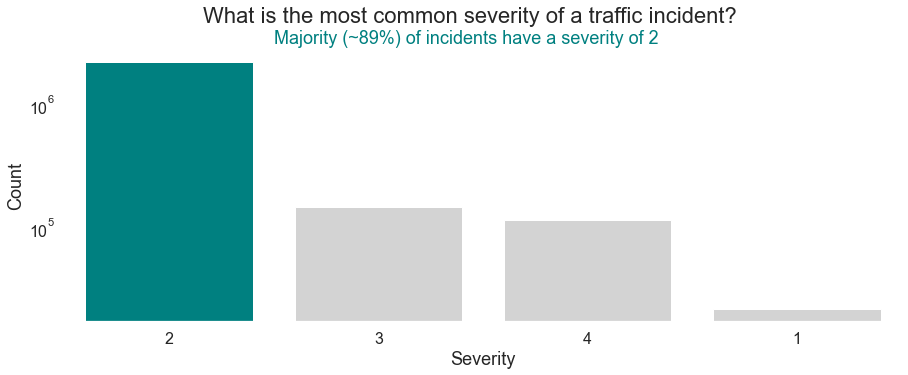

Rectangle(xy=(-0.4, 0), width=0.8, height=2.19946e+06, angle=0) -> 88.72 %
Rectangle(xy=(0.6, 0), width=0.8, height=144605, angle=0) -> 5.83 %
Rectangle(xy=(1.6, 0), width=0.8, height=113479, angle=0) -> 4.58 %
Rectangle(xy=(2.6, 0), width=0.8, height=21445, angle=0) -> 0.87 %


In [5]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Severity"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Severity", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("What is the most common severity of a traffic incident?", y=1, fontsize=22)
plt.title("Majority (~89%) of incidents have a severity of 2", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Severity", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

The typical severity is 2 in case of about 89% of all traffic incidents. Few incidents have a severity of 3 or 4 with about 10%. Very untypical is a severity of 1 with only 1% of all incidents.

### ❓ What is the traffic incident duration to be expected in most cases?

#### 🔎 Analysis

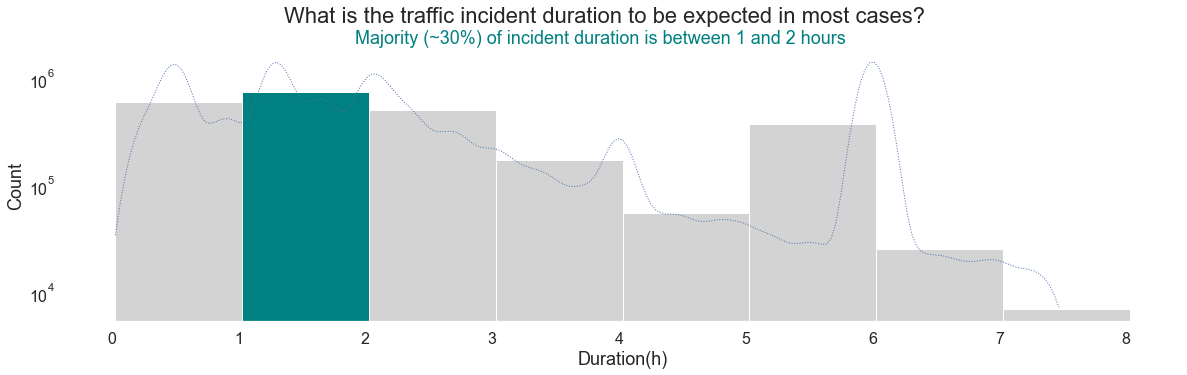

Rectangle(xy=(0.03, 0), width=1, height=598319, angle=0) -> 24.14 %
Rectangle(xy=(1.03, 0), width=1, height=741904, angle=0) -> 29.93 %
Rectangle(xy=(2.03, 0), width=1, height=508656, angle=0) -> 20.52 %
Rectangle(xy=(3.03, 0), width=1, height=171221, angle=0) -> 6.91 %
Rectangle(xy=(4.03, 0), width=1, height=54695, angle=0) -> 2.21 %
Rectangle(xy=(5.03, 0), width=1, height=372466, angle=0) -> 15.02 %
Rectangle(xy=(6.03, 0), width=1, height=24852, angle=0) -> 1.0 %
Rectangle(xy=(7.03, 0), width=1, height=6871, angle=0) -> 0.28 %
mean: 2.392235940213682
median: 1.9
std: 1.8593320551636658
iqr: 1.9000000000000001
Distribution type: Non-symmetric moderately right-skewed distribution (skewness: 0.99832)
Type: <class 'numpy.dtype[float64]'>
Min: 0.03
Max: 7.47
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Duration(h) <= -1.6900000000000002 - values #: 0 / %: 0.0
potential outlier when Duration(h) >= 5.91 - values #: 378450 / %: 15.2663
potential total outlier values

In [6]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed_insights, x="Duration(h)", kde=True, binwidth=1,
                line_kws={"lw": 1, "ls": ":"}
            )

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Add and format description text
plt.suptitle("What is the traffic incident duration to be expected in most cases?", y=1, fontsize=22)
plt.title("Majority (~30%) of incident duration is between 1 and 2 hours", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Duration(h)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if (rectangle.get_x() >= 1) & (rectangle.get_x() < 2):
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

# Calculate and show further information
mean_distance = us_accidents_preprocessed_insights["Duration(h)"].mean()
median_distance = us_accidents_preprocessed_insights["Duration(h)"].median()
std_distance = us_accidents_preprocessed_insights["Duration(h)"].std()
q1_distance = us_accidents_preprocessed_insights["Duration(h)"].quantile(0.25)
q3_distance = us_accidents_preprocessed_insights["Duration(h)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed_insights, "Duration(h)"))
data_info_num_ratio_attribute(us_accidents_preprocessed_insights, "Duration(h)")

#### 📌 __Result__

__Shape__ 

The distribution of the traffic incident duration is moderately skewed right and multimodal. Most accidents cause a lower and fewer a higher traffic incident duration. There are several peaks, the two highest traffic incident durations are concentrated around 1.25 and around 6 hours.

__Central Tendency (Location Metrics)__ 

- Mean is ~2.4, but less accurate (due to skewness)
- Median is 1.9 and more accurate 

The median duration is 1.9 hours, indicating that the typical traffic incident duration is about 1.9 hours.


__Spread of Data (Variability Metrics)__

- Standard Deviation is ~1.85, but less accurate (due to skewness)
- IQR is 1.9 and more accurate 

The distribution indicates with an IRQ of 1.9 hours that there is a variation in the traffic incident duration. It ranges from 0.03 to about 7.5 hours. Most (~75%) of the accidents have a traffic incident duration between 0.03 and about 2 hours, fewer (~25%) up to 7.5 hours, suggesting the large differences.

__Outliers__

There seem to be about 15% outliers according to the 1.5-IQR rule to the far right with a traffic incident duration higher than about 6 hours.


### ❓ Does the distribution of the traffic incident duration differ with the severity of the accident?

#### 🔎 Analysis

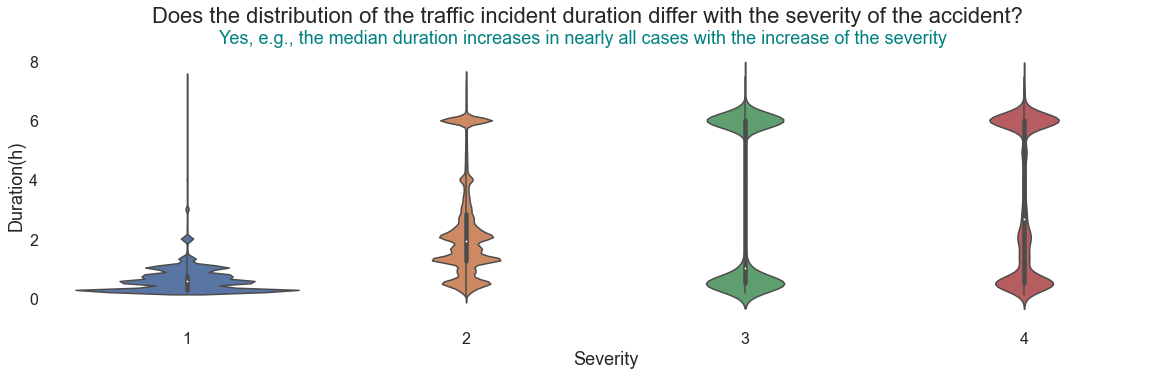

######### Duration(h) with Severity: 1
mean: 0.632762415481446
median: 0.58
std: 0.48915619259578785
iqr: 0.5
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 3.89693)
Type: <class 'numpy.dtype[float64]'>
Min: 0.25
Max: 7.45
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Duration(h) <= -0.5 - values #: 0 / %: 0.0
potential outlier when Duration(h) >= 1.5 - values #: 697 / %: 3.2502
potential total outlier values #: 697 / %: 3.2502
######### Duration(h) with Severity: 2
mean: 2.321422834297208
median: 1.92
std: 1.7276360463844962
iqr: 1.5699999999999998
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 1.13289)
Type: <class 'numpy.dtype[float64]'>
Min: 0.03
Max: 7.47
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Duration(h) <= -1.1049999999999995 - values #: 0 / %: 0.0
potential outlier when Duration(h) >= 5.174999999999999 - values #: 287478 / %: 13.0704
potential total outlier value

In [7]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate boxplot
vplot = sns.violinplot(data=us_accidents_preprocessed_insights, x="Severity", y="Duration(h)")

# Add and format description text
plt.suptitle("Does the distribution of the traffic incident duration differ with the severity of the accident?", y=1, fontsize=22)
plt.title("Yes, e.g., the median duration increases in nearly all cases with the increase of the severity", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Severity", fontsize=18)
plt.ylabel("Duration(h)", fontsize=18)
plt.tick_params(labelsize=16)

# Show figure
plt.show()

# Calculate and show further information
for severity in np.arange(1,5):
    print("######### Duration(h) with Severity:", severity)
    # Calculate and show further information
    filtered = us_accidents_preprocessed_insights[
        us_accidents_preprocessed_insights["Severity"] == severity
    ]
    mean_distance = filtered["Duration(h)"].mean()
    median_distance = filtered["Duration(h)"].median()
    std_distance = filtered["Duration(h)"].std()
    q1_distance = filtered["Duration(h)"].quantile(0.25)
    q3_distance = filtered["Duration(h)"].quantile(0.75)
    iqr_distance = q3_distance-q1_distance
    print("mean:", mean_distance)
    print("median:", median_distance)
    print("std:", std_distance)
    print("iqr:", iqr_distance)
    print("Distribution type:", check_distribution_type(filtered, "Duration(h)"))
    data_info_num_ratio_attribute(filtered, "Duration(h)")

#### 📌 __Result__

__Shape__ 

In case of severity 1 and 2 the distribution of the traffic incident duration is highly skewed right and multimodal. For severity 3 and 4 the distribution is approximately symmetric and bimodal for the first and multimodal for the latter.

__Central Tendency (Location Metrics)__ 

- Mean is ~6.3 (1) / ~2.3 (2) / ~3 (3)/ ~3.3 (4) but less accurate (due to skewness)
- Median is 0.58 (1) / 1.92 (2) / 1.0 (3) / 2.65 (4) and more accurate 

The median duration increases in nearly all cases with the increase of the severity. The typical traffic incident duration is about 0.58, 1.92, 1.0 and 2.65 hours regarding severity 1 to 4.


__Spread of Data (Variability Metrics)__

- Standard Deviation is ~0.5 (1) / ~1.7 (2) / ~2.7 (3) / ~2.5 (4), but less accurate (due to skewness)
- IQR is 0.5 (1) / ~1.6 (2) / ~5.5 (3) / 5.5 (4) and more accurate 

The variation in the traffic incident duration increases in nearly all cases with the increase of the severity. It ranges from 0.25, 0.03, 0.15 and 0.11 regarding severity 1 to 4 to about 7.5 hours for all severities.

__Outliers__

There seem to be about 3% and 13% outliers according to the 1.5-IQR rule to the far right with a traffic incident duration higher than about 1.5 and 5.2 hours regarding severity 1 and 2.

### ❓ Which street length is affected in most cases?

#### 🔎 Analysis

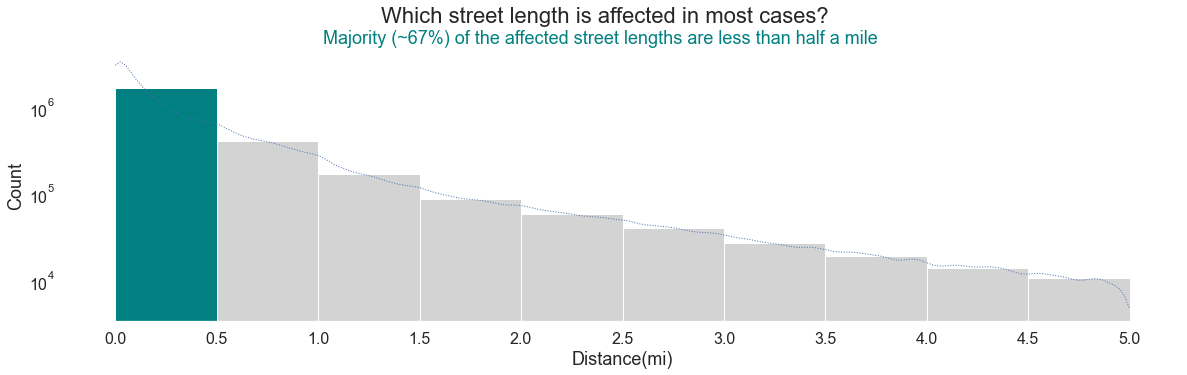

Rectangle(xy=(0, 0), width=0.5, height=1.65466e+06, angle=0) -> 66.75 %
Rectangle(xy=(0.5, 0), width=0.5, height=403900, angle=0) -> 16.29 %
Rectangle(xy=(1, 0), width=0.5, height=167011, angle=0) -> 6.74 %
Rectangle(xy=(1.5, 0), width=0.5, height=86479, angle=0) -> 3.49 %
Rectangle(xy=(2, 0), width=0.5, height=57929, angle=0) -> 2.34 %
Rectangle(xy=(2.5, 0), width=0.5, height=39736, angle=0) -> 1.6 %
Rectangle(xy=(3, 0), width=0.5, height=26408, angle=0) -> 1.07 %
Rectangle(xy=(3.5, 0), width=0.5, height=18937, angle=0) -> 0.76 %
Rectangle(xy=(4, 0), width=0.5, height=13618, angle=0) -> 0.55 %
Rectangle(xy=(4.5, 0), width=0.5, height=10311, angle=0) -> 0.42 %
mean: 0.5533149947719955
median: 0.2289999999999999
std: 0.8129662715027037
iqr: 0.6589999999999999
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 2.49307)
Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 4.999
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Distance(mi) <= -

In [8]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed_insights, x="Distance(mi)", kde=True, binwidth=0.5,
                line_kws={"lw": 1, "ls": ":"}
            )

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Add and format description text
plt.suptitle("Which street length is affected in most cases?", y=1, fontsize=22)
plt.title("Majority (~67%) of the affected street lengths are less than half a mile", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Distance(mi)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if rectangle.get_x() < 0.5:
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

# Calculate and show further information
mean_distance = us_accidents_preprocessed_insights["Distance(mi)"].mean()
median_distance = us_accidents_preprocessed_insights["Distance(mi)"].median()
std_distance = us_accidents_preprocessed_insights["Distance(mi)"].std()
q1_distance = us_accidents_preprocessed_insights["Distance(mi)"].quantile(0.25)
q3_distance = us_accidents_preprocessed_insights["Distance(mi)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed_insights, "Distance(mi)"))
data_info_num_ratio_attribute(us_accidents_preprocessed_insights, "Distance(mi)")

#### 📌 __Result__

__Shape__ 

The distribution of affected street length is highly skewed right and unimodal. Most accidents cause a lower and fewer a higher affected street length. There is one peek, concentrated around 0.03 miles (~48 meters).

__Central Tendency (Location Metrics)__ 

- Mean is ~0.6, but less accurate (due to skewness)
- Median is ~0.2 and more accurate 

The median affected street length is about 0.2, indicating that the typical affected street length is about 0.2 miles (~321 meters).


__Spread of Data (Variability Metrics)__

- Standard Deviation is ~0.8, but less accurate (due to skewness)
- IQR is ~0.7 and more accurate 

The distribution indicates with an IRQ of about 0.7 miles (~1127 meters) that there is a variation in the affected street length. It ranges from 0.0 to about 5 miles (~8047 meters). Most (~67%) of the accidents have an affected street length between 0.0 and less than 0.5 miles (~805 meters), fewer (~33%) up to about 5 miles (~8047 meters), suggesting the large differences.

__Outliers__

There seem to be about 9% outliers according to the 1.5-IQR rule to the far right with an affected street length higher than about 1.7 miles (~2736 meters).


### ❓ Does the distribution of affected road length differ with the severity of the incident?

#### 🔎 Analysis

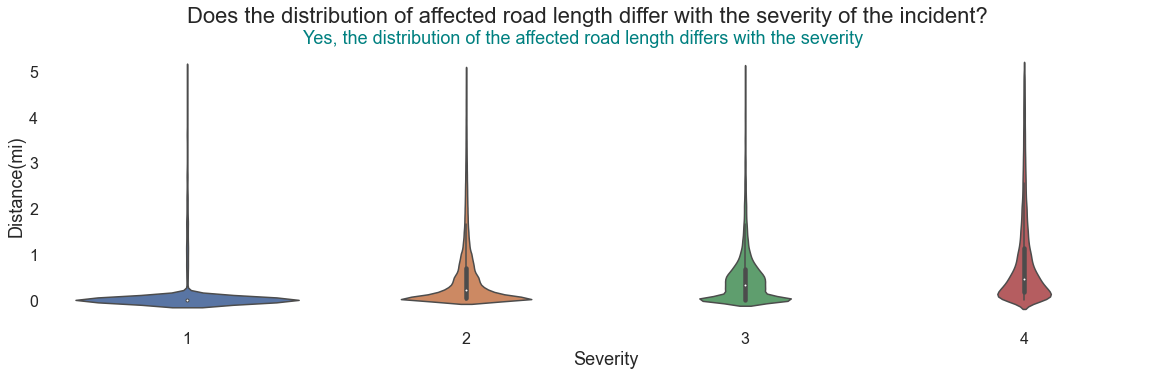

######### Distance(mi) with Severity: 1
mean: 0.14779370482630014
median: 0.0
std: 0.5920719467594916
iqr: 0.0
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 4.87102)
Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 4.997
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Distance(mi) <= 0.0 - values #: 0 / %: 0.0
potential outlier when Distance(mi) >= 0.0 - values #: 2312 / %: 10.7811
potential total outlier values #: 2312 / %: 10.7811
######### Distance(mi) with Severity: 2
mean: 0.5448203041207208
median: 0.217
std: 0.8070975114496057
iqr: 0.6479999999999999
Distribution type: Non-symmetric highly right-skewed distribution (skewness: 2.50802)
Type: <class 'numpy.dtype[float64]'>
Min: 0.0
Max: 4.999
Missing absolute (#): 0
Missing relative (%): 0
potential outlier when Distance(mi) <= -0.9249999999999998 - values #: 0 / %: 0.0
potential outlier when Distance(mi) >= 1.6669999999999998 - values #: 192033 / %: 8.7309
potential total ou

In [9]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate violinplot
vplot = sns.violinplot(data=us_accidents_preprocessed_insights, x="Severity", y="Distance(mi)")

# Add and format description text
plt.suptitle("Does the distribution of affected road length differ with the severity of the incident?", y=1, fontsize=22)
plt.title("Yes, the distribution of the affected road length differs with the severity", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Severity", fontsize=18)
plt.ylabel("Distance(mi)", fontsize=18)
plt.tick_params(labelsize=16)

# Show figure
plt.show()

# Calculate and show further information
for severity in np.arange(1,5):
    print("######### Distance(mi) with Severity:", severity)
    # Calculate and show further information
    filtered = us_accidents_preprocessed_insights[
        us_accidents_preprocessed_insights["Severity"] == severity
    ]
    mean_distance = filtered["Distance(mi)"].mean()
    median_distance = filtered["Distance(mi)"].median()
    std_distance = filtered["Distance(mi)"].std()
    q1_distance = filtered["Distance(mi)"].quantile(0.25)
    q3_distance = filtered["Distance(mi)"].quantile(0.75)
    iqr_distance = q3_distance-q1_distance
    print("mean:", mean_distance)
    print("median:", median_distance)
    print("std:", std_distance)
    print("iqr:", iqr_distance)
    print("Distribution type:", check_distribution_type(filtered, "Distance(mi)"))
    data_info_num_ratio_attribute(filtered, "Distance(mi)")

#### 📌 __Result__

__Shape__ 

The affected street length is highly skewed right and unimodal for all severities.

__Central Tendency (Location Metrics)__ 

- Mean is ~0.2 (1) / ~0.5 (2) / ~0.5 (3)/ ~0.8 (4) but less accurate (due to skewness)
- Median is ~0 (1) / ~0.2 (2) / ~0.3 (3) / ~0.5 (4) and more accurate 

The median duration increases in all cases with the increase of the severity. The typical affected street length is about 0, 0.2, 0.3 and 0.5 miles regarding severity 1 to 4.


__Spread of Data (Variability Metrics)__

- Standard Deviation is ~0.6 (1) / ~0.8 (2) / ~0.7 (3) / ~1 (4), but less accurate (due to skewness)
- IQR is 0 (1) / ~0.6 (2) / ~0.7 (3) / ~1 (4) and more accurate 

The variation in the traffic incident duration increases in all cases with the increase of the severity. It ranges from 0 to about 5 miles for all severities.

__Outliers__

There seem to be about 11%, 9%, 6% and 8% outliers according to the 1.5-IQR rule to the far right with an affected street length higher than about 0, 1.7, 1.7 and 2.6 miles regarding severity 1 to 4.

## <a id="analysis-2"></a>🌎 Analysis Area 2: Location Analysis

👉🏼 __Provides insights about the geographical distribution of traffic incidents.__

❓ The following questions will be investigated
- Which places have the most traffic incidents (Top 3)?
- Which states have the least traffic incidents (Top 3)?
- What street type is affected in most cases (Top 5)?
- How are traffic incidents geographically distributed regarding their severity?


### ❓ Which places have the most traffic incidents (Top 3)?

#### 🔎 Analysis

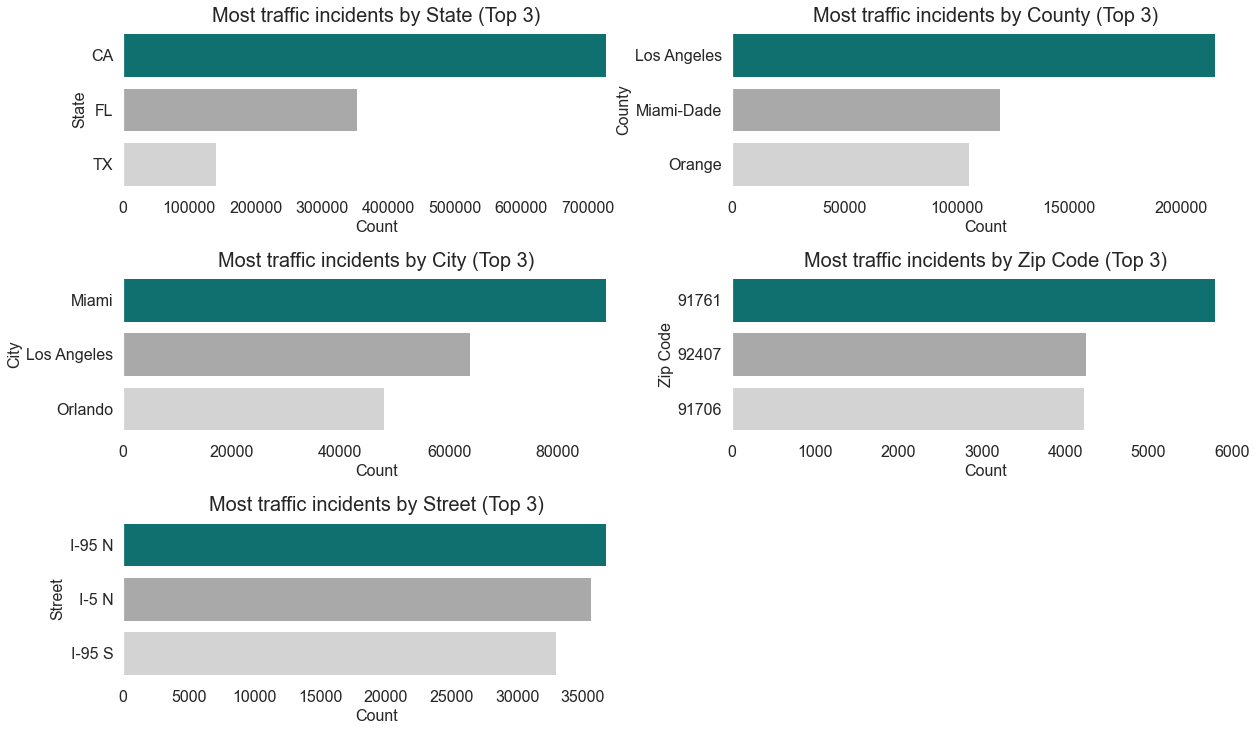

########## Most traffic incidents by State (Top 3)
Rectangle(xy=(0, -0.4), width=727526, height=0.8, angle=0) -> 29.35 %
Rectangle(xy=(0, 0.6), width=351955, height=0.8, angle=0) -> 14.2 %
Rectangle(xy=(0, 1.6), width=140019, height=0.8, angle=0) -> 5.65 %
########## Most traffic incidents by County (Top 3)
Rectangle(xy=(0, -0.4), width=214812, height=0.8, angle=0) -> 8.67 %
Rectangle(xy=(0, 0.6), width=119539, height=0.8, angle=0) -> 4.82 %
Rectangle(xy=(0, 1.6), width=105485, height=0.8, angle=0) -> 4.26 %
########## Most traffic incidents by City (Top 3)
Rectangle(xy=(0, -0.4), width=88859, height=0.8, angle=0) -> 3.58 %
Rectangle(xy=(0, 0.6), width=63765, height=0.8, angle=0) -> 2.57 %
Rectangle(xy=(0, 1.6), width=47962, height=0.8, angle=0) -> 1.93 %
########## Most traffic incidents by Zip Code (Top 3)
Rectangle(xy=(0, -0.4), width=5796, height=0.8, angle=0) -> 0.23 %
Rectangle(xy=(0, 0.6), width=4253, height=0.8, angle=0) -> 0.17 %
Rectangle(xy=(0, 1.6), width=4222, height=0.8, 

In [10]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,12),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Define colors
palette = ["teal", "darkgray", "lightgray"]

# Create figure with subplots
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Fill subplots
ax1.set_title("Most traffic incidents by State (Top 3)", fontsize=20)
order = us_accidents_preprocessed_insights["State"].value_counts()[0:3].index
sns.countplot(data=us_accidents_preprocessed_insights, y="State", order=order, ax=ax1, palette=palette)
ax1.set_xlabel("Count", fontsize=16)
ax1.set_ylabel("State", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=16)

ax2.set_title("Most traffic incidents by County (Top 3)", fontsize=20)
order = us_accidents_preprocessed_insights["County"].value_counts()[0:3].index
sns.countplot(data=us_accidents_preprocessed_insights, y="County", order=order, ax=ax2, palette=palette)
ax2.set_xlabel("Count", fontsize=16)
ax2.set_ylabel("County", fontsize=16)
ax2.tick_params(axis="both", which="major", labelsize=16)

ax3.set_title("Most traffic incidents by City (Top 3)", fontsize=20)
order = us_accidents_preprocessed_insights["City"].value_counts()[0:3].index
sns.countplot(data=us_accidents_preprocessed_insights, y="City", order=order, ax=ax3, palette=palette)
ax3.set_xlabel("Count", fontsize=16)
ax3.set_ylabel("City", fontsize=16)
ax3.tick_params(axis="both", which="major", labelsize=16)

ax4.set_title("Most traffic incidents by Zip Code (Top 3)", fontsize=20)
order = us_accidents_preprocessed_insights["Zipcode"].value_counts()[0:3].index
sns.countplot(data=us_accidents_preprocessed_insights, y="Zipcode", order=order, ax=ax4, palette=palette)
ax4.set_xlabel("Count", fontsize=16)
ax4.set_ylabel("Zip Code", fontsize=16)
ax4.tick_params(axis="both", which="major", labelsize=16)

ax5.set_title("Most traffic incidents by Street (Top 3)", fontsize=20)
order = us_accidents_preprocessed_insights["Street"].value_counts()[0:3].index
sns.countplot(data=us_accidents_preprocessed_insights, y="Street", order=order, ax=ax5, palette=palette)
ax5.set_xlabel("Count", fontsize=16)
ax5.set_ylabel("Street", fontsize=16)
ax5.tick_params(axis="both", which="major", labelsize=16)

# Show figure
plt.show()

# Show details
axes = [ax1, ax2, ax3, ax4, ax5]
for ax in axes:
    print("##########", ax.get_title())
    for bar in ax.patches:
        percentage = round(bar.get_width() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
        print(bar, "->", percentage, "%")

#### 📌 __Result__


__State__

Most traffic incidents regarding states occur in *California* with about 30%, followed by *Los Angeles* and *Orlando* with about 14% and 6% respectively.

__County__

Most traffic incidents regarding counties occur in *Los Angeles* with about 9%, followed by *Miami-Dade* and *Orange* with about 5% and 4% respectively.

__City__

Most traffic incidents regarding cities occur in *Miami* with about 4%, followed by *Los Angeles* and *Orlando* with about 3% and 2% respectively.

__Zip Code__

Most traffic incidents regarding zip codes occur in *91761 (Ontario, California)* with about 0.2%, followed by *92407 (San Bernardino, California)* and *91706 (Baldwin Park, California)* with about 3 % and 2 % respectively.

__Street__

Most traffic incidents regarding streets occur on the *I-95 N* with about 2%, followed by *I-5 N* and *I-95 S* with about 1% and 1% respectively.

### ❓ Which states have the least traffic incidents (Top 3)?

#### 🔎 Analysis

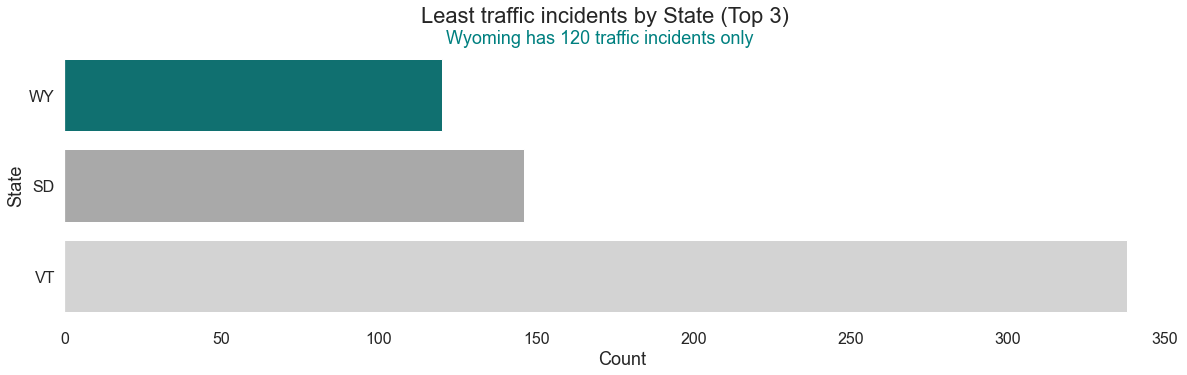

Rectangle(xy=(0, -0.4), width=120, height=0.8, angle=0) -> 0.0 %
Rectangle(xy=(0, 0.6), width=146, height=0.8, angle=0) -> 0.01 %
Rectangle(xy=(0, 1.6), width=338, height=0.8, angle=0) -> 0.01 %


In [11]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Define colors
palette = ["teal", "darkgray", "lightgray"]

# Generate countplot
order = us_accidents_preprocessed_insights["State"].value_counts().sort_values(ascending=True)[0:3].index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, y="State", order=order, palette=palette)

# Add and format description text
plt.suptitle("Least traffic incidents by State (Top 3)", y=1, fontsize=22)
plt.title("Wyoming has 120 traffic incidents only", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Count", fontsize=18)
plt.ylabel("State", fontsize=18)
plt.tick_params(labelsize=16)

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_width() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

With 120 in total the state *Wyoming* has the least traffic incidents, followed by *South Dakota* and *Vermont* with 146 and 338 incidents respectively.

### ❓ What street type is affected in most cases (Top 5)?

#### 🔎 Analysis

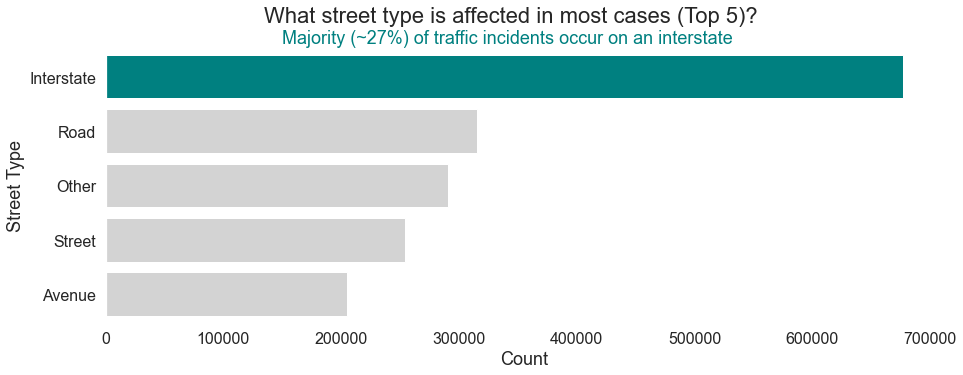

Rectangle(xy=(0, -0.4), width=676717, height=0.8, angle=0) -> 27.3 %
Rectangle(xy=(0, 0.6), width=315664, height=0.8, angle=0) -> 12.73 %
Rectangle(xy=(0, 1.6), width=290908, height=0.8, angle=0) -> 11.73 %
Rectangle(xy=(0, 2.6), width=254009, height=0.8, angle=0) -> 10.25 %
Rectangle(xy=(0, 3.6), width=204995, height=0.8, angle=0) -> 8.27 %


In [12]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Street_Type"].value_counts()[0:5].index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, y="Street_Type", order=order)

# Add and format description text
plt.suptitle("What street type is affected in most cases (Top 5)?", y=1, fontsize=22)
plt.title("Majority (~27%) of traffic incidents occur on an interstate", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Count", fontsize=18)
plt.ylabel("Street Type", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_y() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_width() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

__Background Knowledge__

- *Interstate:* A large, typically federally funded network of roads that are part of a highway system. It may go between states, but it doesn't have to.
- *Road:* The most general category, this is a way that connects two points.
- *Street:* A public way with buildings on both sides. Often, it runs perpendicular to an avenue.
- *Avenue:* A public way often in a city, usually with trees or buildings on the side. Frequently, it runs perpendicular to a street.

(Source: https://www.vox.com/2016/11/14/13275486/streets-roads-avenues-names-reasons)

__Result Intepretation__

The typical traffic incident occurs on interstates in case of about 27% of all traffic incidents with respect to the top 5 street types. The rest occurs on street type *road*, *others*, *street* and *avenues* in decsending order.


### ❓ How are traffic incidents geographically distributed regarding their severity?

#### 🔎 Analysis

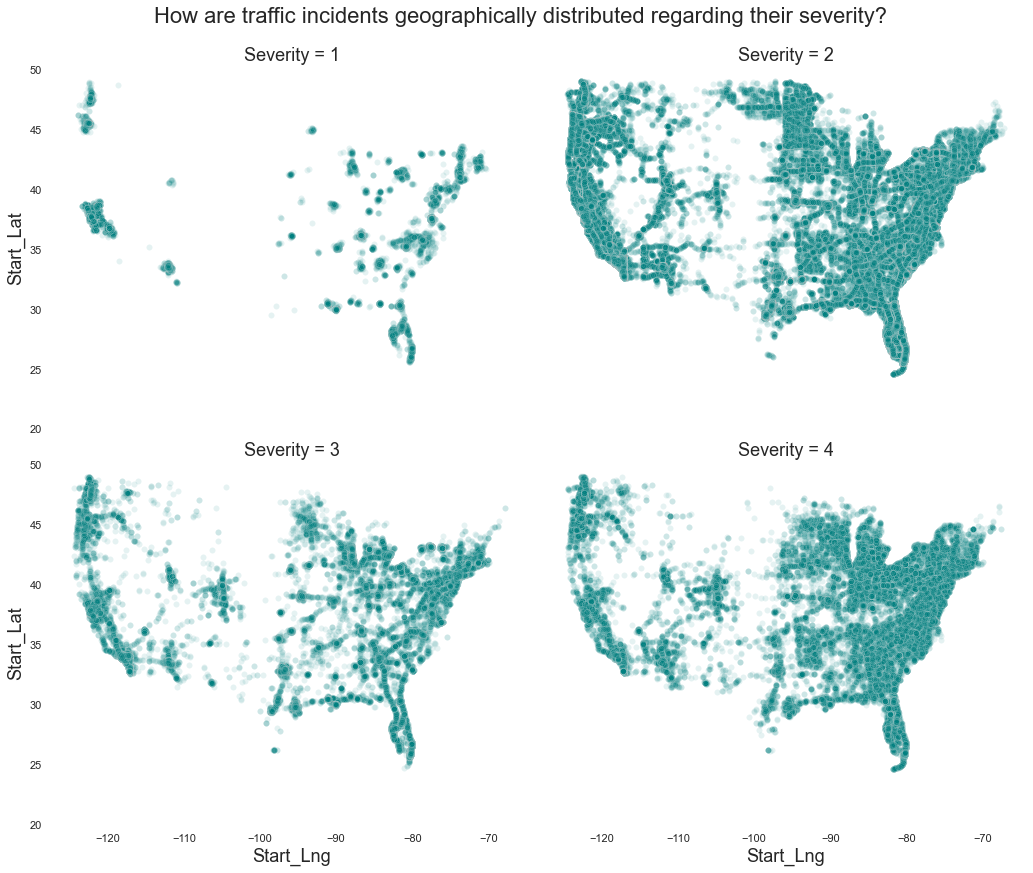

In [13]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate scatterplot
scatterplot = sns.relplot(kind="scatter", x="Start_Lng", y="Start_Lat", data=us_accidents_preprocessed_insights, 
            alpha=0.1, col="Severity", col_wrap=2,
            height=6, aspect=1.2, color="teal")

# Add and format description text
plt.suptitle("How are traffic incidents geographically distributed regarding their severity?", y=1, fontsize=22)
plt.ylim(20)

(scatterplot.map(plt.axhline, zorder=0)
  .set_axis_labels("Start_Lng", "Start_Lat", fontsize=18)
  .set_titles(size=18)
)

# Show figure
plt.show()


In [14]:
us_accidents_preprocessed_insights["Severity"].value_counts()

2    2199455
3     144605
4     113479
1      21445
Name: Severity, dtype: int64

#### 📌 __Result__

Traffic incidents are differently distributed regarding their severity. 

Traffic incidents with severity 1 have the lowest counts and occurs mainly in the margin of east and west. 

Severity 2 incidents are most common and distributed in north, east, south and west. 

Incidents with severity 3 occur secondly common and are more distributed in the margin of east and west, and less in north and south. 

Severity 4 traffic incidents occur third common and are mainly concentrated in the east and in the margin of west.

## <a id="analysis-3"></a>⌚️ Analysis Area 3: Time Analysis

👉🏼 __Provides insights about time-related aspects of traffic incidents.__

❓ The following questions will be investigated
- On which day of the week do most traffic incidents occur?
- At which hour do most of the traffic incidents occur?
- On which month do most of the traffic incidents occur?
- Does traffic incidents occur mostly by day, twilight or night?

### ❓ On which day of the week do most traffic incidents occur?

#### 🔎 Analysis

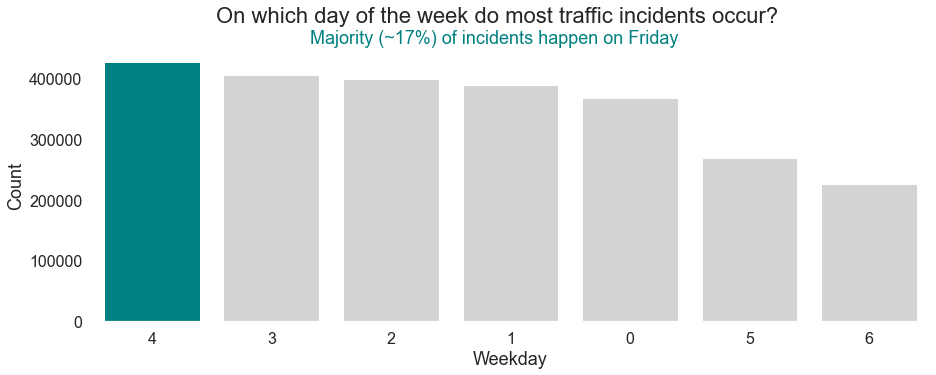

Rectangle(xy=(-0.4, 0), width=0.8, height=425764, angle=0) -> 17.17 %
Rectangle(xy=(0.6, 0), width=0.8, height=405402, angle=0) -> 16.35 %
Rectangle(xy=(1.6, 0), width=0.8, height=397856, angle=0) -> 16.05 %
Rectangle(xy=(2.6, 0), width=0.8, height=389071, angle=0) -> 15.69 %
Rectangle(xy=(3.6, 0), width=0.8, height=366762, angle=0) -> 14.79 %
Rectangle(xy=(4.6, 0), width=0.8, height=268876, angle=0) -> 10.85 %
Rectangle(xy=(5.6, 0), width=0.8, height=225253, angle=0) -> 9.09 %


In [15]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Weekday"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Weekday", order=order)

# Adjust scaling of axis
#plt.yscale("log")

# Add and format description text
plt.suptitle("On which day of the week do most traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~17%) of incidents happen on Friday", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Weekday", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

The typical traffic incident occurs on Friday in case of about 17% of all incidents. The rest occurs on Thursday, Wednesday, Tuesday, Monday, Saturday and Sunday in descending order.

Only about 20% of traffic incidents happen during weekend and about 80% during the week.

### ❓ At which hour do most of the traffic incidents occur?

#### 🔎 Analysis

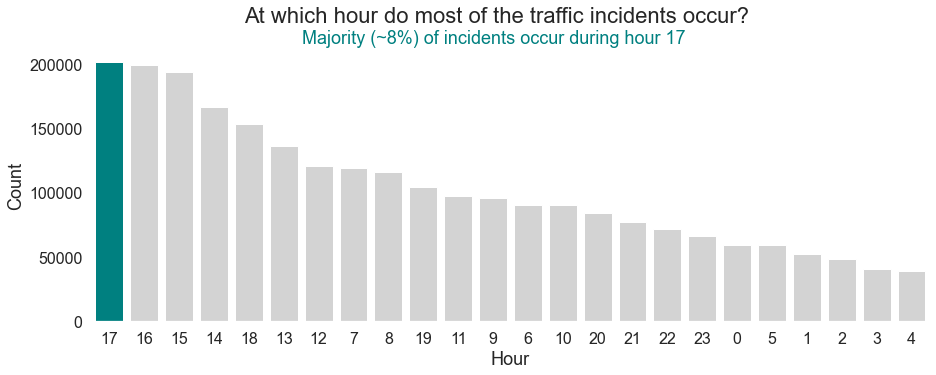

Rectangle(xy=(-0.4, 0), width=0.8, height=201002, angle=0) -> 8.11 %
Rectangle(xy=(0.6, 0), width=0.8, height=198667, angle=0) -> 8.01 %
Rectangle(xy=(1.6, 0), width=0.8, height=193878, angle=0) -> 7.82 %
Rectangle(xy=(2.6, 0), width=0.8, height=166106, angle=0) -> 6.7 %
Rectangle(xy=(3.6, 0), width=0.8, height=153217, angle=0) -> 6.18 %
Rectangle(xy=(4.6, 0), width=0.8, height=135970, angle=0) -> 5.48 %
Rectangle(xy=(5.6, 0), width=0.8, height=120555, angle=0) -> 4.86 %
Rectangle(xy=(6.6, 0), width=0.8, height=119196, angle=0) -> 4.81 %
Rectangle(xy=(7.6, 0), width=0.8, height=116084, angle=0) -> 4.68 %
Rectangle(xy=(8.6, 0), width=0.8, height=104270, angle=0) -> 4.21 %
Rectangle(xy=(9.6, 0), width=0.8, height=97318, angle=0) -> 3.93 %
Rectangle(xy=(10.6, 0), width=0.8, height=95375, angle=0) -> 3.85 %
Rectangle(xy=(11.6, 0), width=0.8, height=90187, angle=0) -> 3.64 %
Rectangle(xy=(12.6, 0), width=0.8, height=89991, angle=0) -> 3.63 %
Rectangle(xy=(13.6, 0), width=0.8, height=84062, 

In [16]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Hour"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Hour", order=order)

# Adjust scaling of axis
#plt.yscale("log")

# Add and format description text
plt.suptitle("At which hour do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~8%) of incidents occur during hour 17", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Hour", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

The typical traffic incident occurs during hour 17 in case of about 8% of all incidents, directly followed by hour 16 and 15 both also with about 8%.

### ❓ On which month do most of the traffic incidents occur?

#### 🔎 Analysis

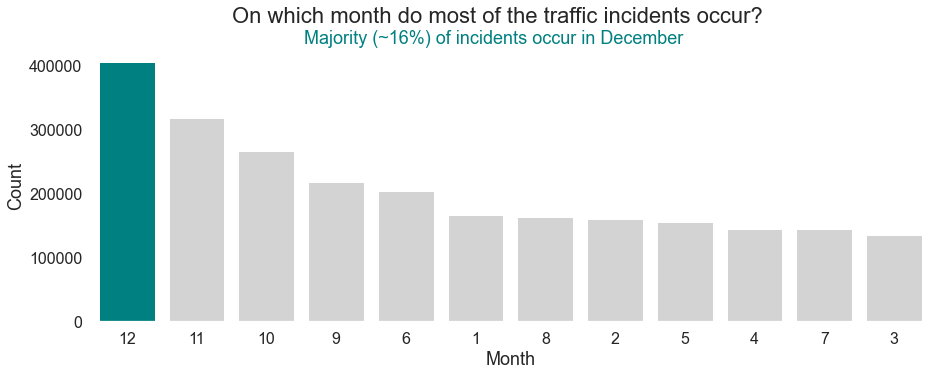

Rectangle(xy=(-0.4, 0), width=0.8, height=404934, angle=0) -> 16.33 %
Rectangle(xy=(0.6, 0), width=0.8, height=318056, angle=0) -> 12.83 %
Rectangle(xy=(1.6, 0), width=0.8, height=265679, angle=0) -> 10.72 %
Rectangle(xy=(2.6, 0), width=0.8, height=218401, angle=0) -> 8.81 %
Rectangle(xy=(3.6, 0), width=0.8, height=204168, angle=0) -> 8.24 %
Rectangle(xy=(4.6, 0), width=0.8, height=166199, angle=0) -> 6.7 %
Rectangle(xy=(5.6, 0), width=0.8, height=162731, angle=0) -> 6.56 %
Rectangle(xy=(6.6, 0), width=0.8, height=159772, angle=0) -> 6.45 %
Rectangle(xy=(7.6, 0), width=0.8, height=155422, angle=0) -> 6.27 %
Rectangle(xy=(8.6, 0), width=0.8, height=144730, angle=0) -> 5.84 %
Rectangle(xy=(9.6, 0), width=0.8, height=144563, angle=0) -> 5.83 %
Rectangle(xy=(10.6, 0), width=0.8, height=134329, angle=0) -> 5.42 %


In [17]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Month"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Month", order=order)

# Add and format description text
plt.suptitle("On which month do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~16%) of incidents occur in December", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Month", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

The typical traffic incident occurs in December in case of about 16% of all incidents, directly followed by November and October with about 13% and 11% respectively.

### ❓ Do traffic incidents occur mostly by day, twilight or night?

#### 🔎 Analysis

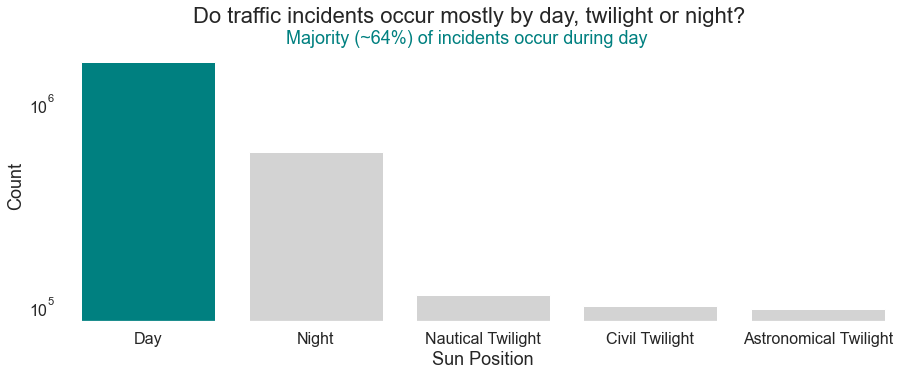

Rectangle(xy=(-0.4, 0), width=0.8, height=1.59732e+06, angle=0) -> 64.43 %
Rectangle(xy=(0.6, 0), width=0.8, height=571856, angle=0) -> 23.07 %
Rectangle(xy=(1.6, 0), width=0.8, height=113354, angle=0) -> 4.57 %
Rectangle(xy=(2.6, 0), width=0.8, height=100104, angle=0) -> 4.04 %
Rectangle(xy=(3.6, 0), width=0.8, height=96346, angle=0) -> 3.89 %


In [18]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Sun_Position"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Sun_Position", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("Do traffic incidents occur mostly by day, twilight or night?", y=1, fontsize=22)
plt.title("Majority (~64%) of incidents occur during day", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Sun Position", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

The typical traffic incident occurs during day in case of about 64% of all incidents, followed by night with about 23%. 

The overall twilight proportion is only about 12%, with about 4% per twilight type.

## <a id="analysis-4"></a>📈 Analysis Area 4: Trend Analysis

👉🏼 __Provides insights about the development of traffic incidents over an interval of time.__

❓ The following questions will be investigated
- Does the number of traffic incidents increase over the years?
- Is there a change of the proportion of the severity levels over the years?
- Does the traffic flow impact duration increase over the years? 

### ❓ Does the number of traffic incidents increase over the years?

#### 🔎 Analysis

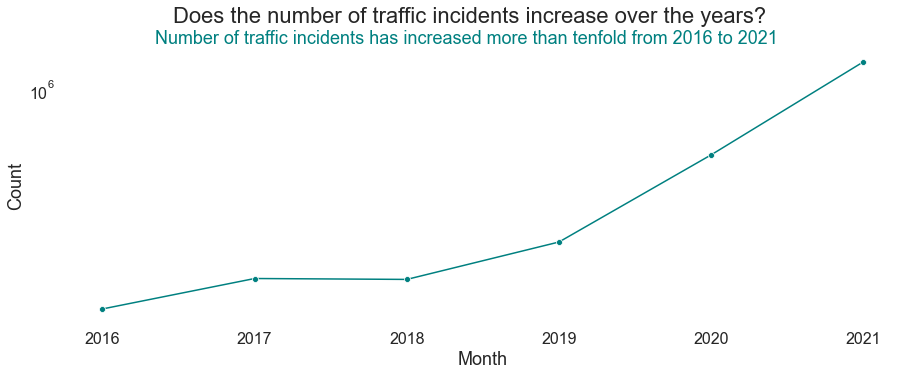

,Count absolute,Count relative (%)
2016,118232,4.76937
2018,157364,6.34792
2017,158745,6.40363
2019,226043,9.11837
2020,525639,21.20381
2021,1292961,52.15689


In [19]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
filtered = us_accidents_preprocessed_insights["Year"].value_counts()
lineplot = sns.lineplot(data=filtered, marker="o", color="teal")

# Add and format description text
plt.suptitle("Does the number of traffic incidents increase over the years?", y=1, fontsize=22)
plt.title("Number of traffic incidents has increased more than tenfold from 2016 to 2021", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Month", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Scale axis
plt.yscale("log")

# Show figure
plt.show()

# Show details
absolute = us_accidents_preprocessed_insights["Year"].value_counts().sort_values()
relative = us_accidents_preprocessed_insights["Year"].value_counts(normalize=True).sort_values()*100
pd.concat([absolute, relative], axis=1, keys=["Count absolute", "Count relative (%)"])

#### 📌 __Result__

The number of traffic incidents has increased more than tenfold from 2016 to 2021.

### ❓ Is there a change of the proportion of the severity levels over the years?

#### 🔎 Analysis

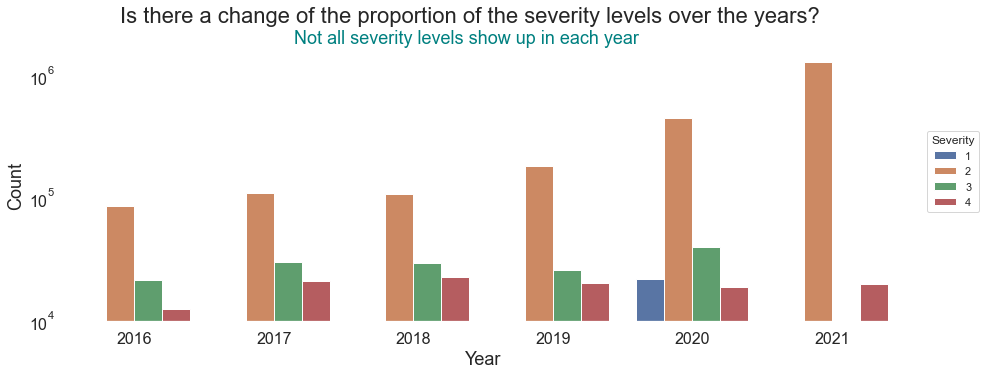

Year  Severity
2016  2             84963
      3             20980
      4             12289
2017  2            108331
      3             29641
      4             20773
2018  2            105832
      3             29331
      4             22201
2019  2            180609
      3             25377
      4             20057
2020  1             21445
      2            446362
      3             39276
      4             18556
2021  2           1273358
      4             19603
Name: Severity, dtype: int64


In [20]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Year", hue="Severity")

# Add and format description text
plt.suptitle("Is there a change of the proportion of the severity levels over the years?", y=1, fontsize=22)
plt.title("Not all severity levels show up in each year", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Year", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

#place legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.03, 0.7), loc='upper left', borderaxespad=0, title="Severity")

# Scale axis
plt.yscale("log")

# Show figure
plt.show()

# Show details
print(us_accidents_preprocessed_insights.groupby(by=["Year", "Severity"], dropna=False)["Severity"].count())

#### 📌 __Result__

Not all severity levels show up in each year, meaning severity level of 1 appears only in year 2020 and severity level 3 is missing in year 2021. 

Severity level 2 has remained at almost the same level for 2016 to 2018 but continuously increased from 2019 to 2021. In 2021 it is nearly fifteen times higher than in 2016.

Severity level 3 increased from 2016 to 2017, remains at nearly the same level in 2018 and 2019 and has been about doubled from 2016 to 2020.

Severity level 4 has been about doubled from 2016 to 2017 but has remained at almost the same level from 2017 to 2021.

### ❓ Does the traffic flow impact duration increase over the years? 

#### 🔎 Analysis

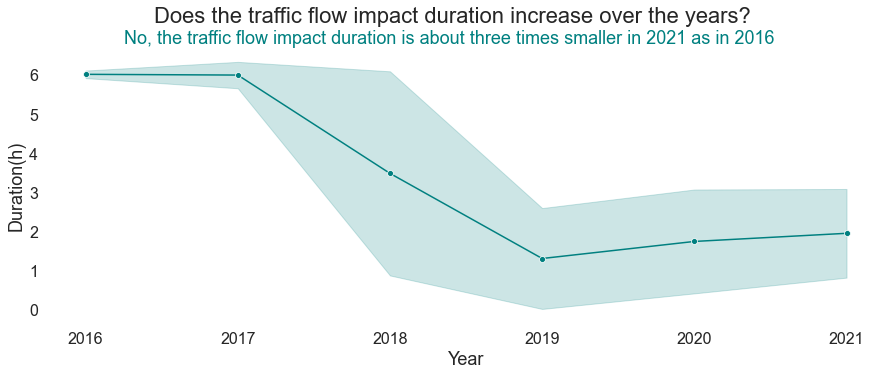

[2016. 2017. 2018. 2019. 2020. 2021.]
[6.00394352 5.98523059 3.47528711 1.30227532 1.73779712 1.94562845]
2016: std+/- 0.1 hours (CI between 0.1 hours and 0.1 hours)
2017: std+/- 0.34 hours (CI between 0.34 hours and 0.34 hours)
2018: std+/- 2.61 hours (CI between 2.59 hours and 2.62 hours)
2019: std+/- 1.29 hours (CI between 1.28 hours and 1.29 hours)
2020: std+/- 1.33 hours (CI between 1.32 hours and 1.33 hours)
2021: std+/- 1.13 hours (CI between 1.13 hours and 1.13 hours)


In [21]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate lineplot
lineplot = sns.lineplot(data=us_accidents_preprocessed_insights, x="Year", y="Duration(h)", color="teal", marker="o", ci="sd")

# Add and format description text
plt.suptitle("Does the traffic flow impact duration increase over the years?", y=1, fontsize=22)
plt.title("No, the traffic flow impact duration is about three times smaller in 2021 as in 2016", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Year", fontsize=18)
plt.ylabel("Duration(h)", fontsize=18)
plt.tick_params(labelsize=16)

# Show figure
plt.show()

# Show details
print(lineplot.get_lines()[0].get_data()[0])
print(lineplot.get_lines()[0].get_data()[1])
for year in [2016, 2017, 2018, 2019, 2020, 2021]:
    data = us_accidents_preprocessed_insights[
        (us_accidents_preprocessed_insights["Year"] == year)
    ]["Duration(h)"]

    data_std = us_accidents_preprocessed_insights[
        (us_accidents_preprocessed_insights["Year"] == year)
    ]["Duration(h)"].std()

    # create 95% confidence interval from normal-distribution
    # for estimated population standard deviation
    ci_n_distribution = stats.norm.interval(alpha=0.95, 
                                            loc=statistics.stdev(data),
                                            scale=stats.sem(data))

    # print
    print(f"{year}: std+/- {round(data_std, 2)} hours (CI between {round(ci_n_distribution[0], 2)} hours and {round(ci_n_distribution[1], 2)} hours)")

#### 📌 __Result__

The traffic flow impact duration is about three times smaller in 2021 than in 2016. 

In 2016 as well as in 2017 the typical traffic flow impact duration was about 6 hours (+/- 0.1 respectively 0.34 hours) and decreased in 2018 to about 3.5 hours (+/- 2.61 hours). Since 2019 it decreased again to 1.3 hours (+/- 1.29 hours) with a slight increase in 2020 and 2021 to about 1.7 hours (+/- 1.33 hours) and about 2 hours (+/- 1.13 hours) respectively.

## <a id="analysis-5"></a>📍 Analysis Area 5: Environment Analysis

👉🏼 __Provides insights about the environment around traffic incidents.__

❓ The following questions will be investigated
- Do traffic incidents happen more often near certain points of interest?
- On which relative streetside of the road do most traffic incidents happen?

### ❓ Do traffic incidents happen more often near certain points of interest?

#### 🔎 Analysis

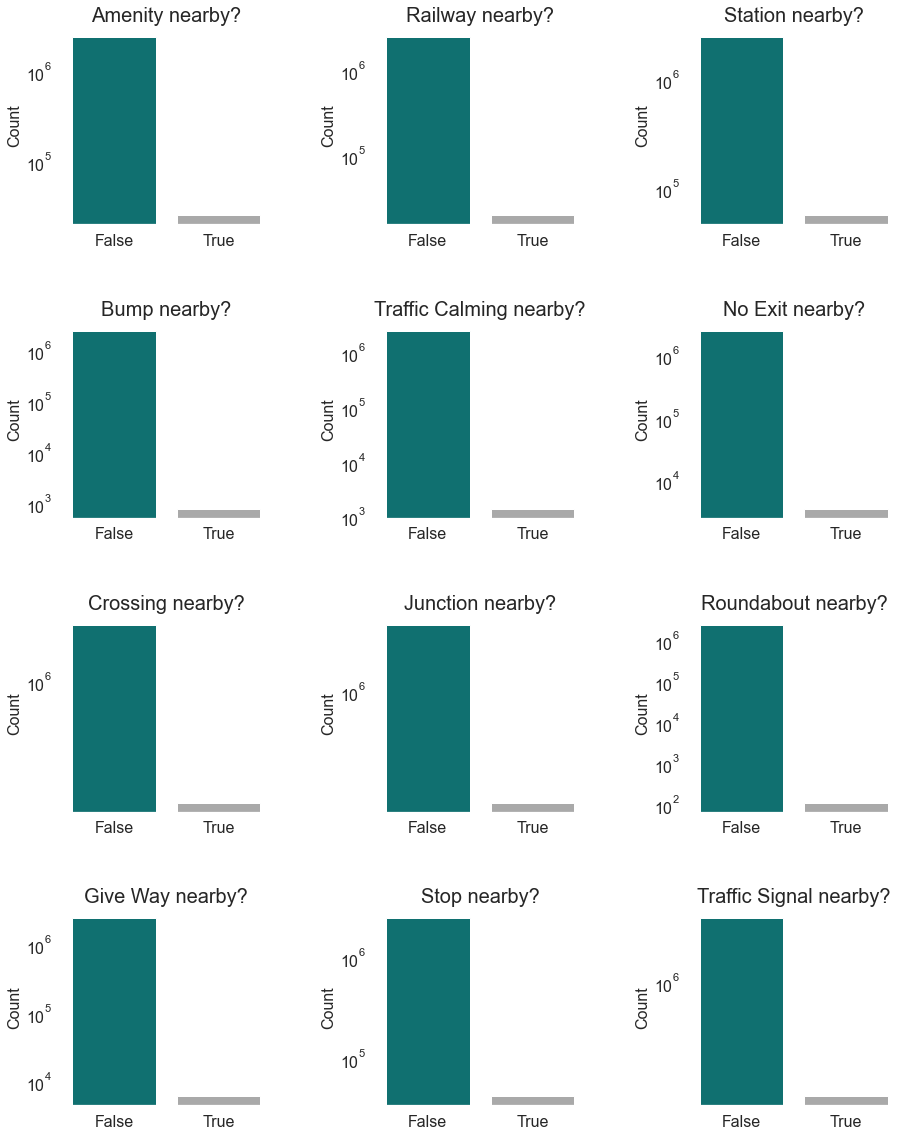

########## Amenity nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.45407e+06, angle=0) -> 98.99 %
Rectangle(xy=(0.6, 0), width=0.8, height=24917, angle=0) -> 1.01 %
########## Railway nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.45846e+06, angle=0) -> 99.17 %
Rectangle(xy=(0.6, 0), width=0.8, height=20519, angle=0) -> 0.83 %
########## Station nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.42118e+06, angle=0) -> 97.67 %
Rectangle(xy=(0.6, 0), width=0.8, height=57799, angle=0) -> 2.33 %
########## Bump nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.4782e+06, angle=0) -> 99.97 %
Rectangle(xy=(0.6, 0), width=0.8, height=784, angle=0) -> 0.03 %
########## Traffic Calming nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.47757e+06, angle=0) -> 99.94 %
Rectangle(xy=(0.6, 0), width=0.8, height=1417, angle=0) -> 0.06 %
########## No Exit nearby?
Rectangle(xy=(-0.4, 0), width=0.8, height=2.47536e+06, angle=0) -> 99.85 %
Rectangle(xy=(0.6, 0), width=0.8, height=3620, angle

In [22]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,22),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Define colors
palette = ["teal", "darkgray"]

# Create figure with subplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots (4, 3)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.5, hspace=0.5)

# Fill subplots
ax1.set_title("Amenity nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Amenity", ax=ax1, palette=palette)
ax1.set_xlabel("", fontsize=16)
ax1.set_ylabel("Count", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=16)
ax1.set_yscale("log")

ax2.set_title("Railway nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Railway", ax=ax2, palette=palette)
ax2.set_xlabel("", fontsize=16)
ax2.set_ylabel("Count", fontsize=16)
ax2.tick_params(axis="both", which="major", labelsize=16)
ax2.set_yscale("log")

ax3.set_title("Station nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Station", ax=ax3, palette=palette)
ax3.set_xlabel("", fontsize=16)
ax3.set_ylabel("Count", fontsize=16)
ax3.tick_params(axis="both", which="major", labelsize=16)
ax3.set_yscale("log")

ax4.set_title("Bump nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Bump", ax=ax4, palette=palette)
ax4.set_xlabel("", fontsize=16)
ax4.set_ylabel("Count", fontsize=16)
ax4.tick_params(axis="both", which="major", labelsize=16)
ax4.set_yscale("log")

ax5.set_title("Traffic Calming nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Traffic_Calming", ax=ax5, palette=palette)
ax5.set_xlabel("", fontsize=16)
ax5.set_ylabel("Count", fontsize=16)
ax5.tick_params(axis="both", which="major", labelsize=16)
ax5.set_yscale("log")

ax6.set_title("No Exit nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="No_Exit", ax=ax6, palette=palette)
ax6.set_xlabel("", fontsize=16)
ax6.set_ylabel("Count", fontsize=16)
ax6.tick_params(axis="both", which="major", labelsize=16)
ax6.set_yscale("log")

ax7.set_title("Crossing nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Crossing", ax=ax7, palette=palette)
ax7.set_xlabel("", fontsize=16)
ax7.set_ylabel("Count", fontsize=16)
ax7.tick_params(axis="both", which="major", labelsize=16)
ax7.set_yscale("log")

ax8.set_title("Junction nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Junction", ax=ax8, palette=palette)
ax8.set_xlabel("", fontsize=16)
ax8.set_ylabel("Count", fontsize=16)
ax8.tick_params(axis="both", which="major", labelsize=16)
ax8.set_yscale("log")

ax9.set_title("Roundabout nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Roundabout", ax=ax9, palette=palette)
ax9.set_xlabel("", fontsize=16)
ax9.set_ylabel("Count", fontsize=16)
ax9.tick_params(axis="both", which="major", labelsize=16)
ax9.set_yscale("log")

ax10.set_title("Give Way nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Give_Way", ax=ax10, palette=palette)
ax10.set_xlabel("", fontsize=16)
ax10.set_ylabel("Count", fontsize=16)
ax10.tick_params(axis="both", which="major", labelsize=16)
ax10.set_yscale("log")

ax11.set_title("Stop nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Stop", ax=ax11, palette=palette)
ax11.set_xlabel("", fontsize=16)
ax11.set_ylabel("Count", fontsize=16)
ax11.tick_params(axis="both", which="major", labelsize=16)
ax11.set_yscale("log")

ax12.set_title("Traffic Signal nearby?", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Traffic_Signal", ax=ax12, palette=palette)
ax12.set_xlabel("", fontsize=16)
ax12.set_ylabel("Count", fontsize=16)
ax12.tick_params(axis="both", which="major", labelsize=16)
ax12.set_yscale("log")

# Show figure
plt.show()

# Show details
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
for ax in axes:
    print("##########", ax.get_title())
    for bar in ax.patches:
        percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
        print(bar, "->", percentage, "%")

#### 📌 __Result__

The majority of traffic incidents do not happen more often nearby certain points of interest, most of them area about less than 2% true. 

Only the POI types *Crossing*, *Junction* and *Traffic Signal* show a little bit more positive proportion with about 7%, 11% and 10% respectively.

### ❓ On which relative streetside of the road does most traffic incidents happen?

#### 🔎 Analysis

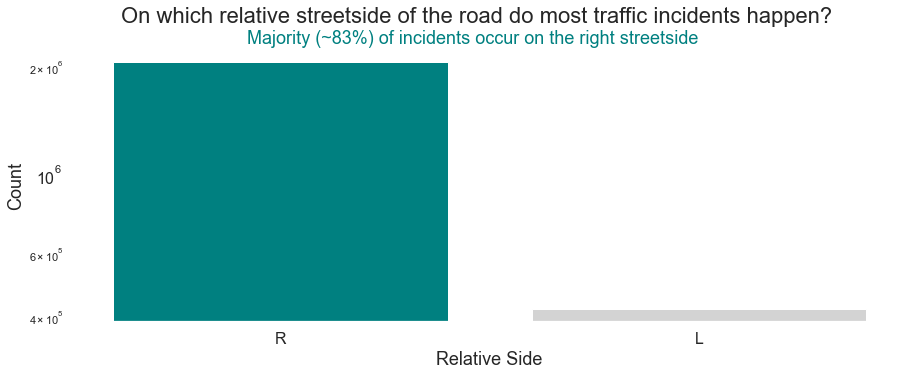

Rectangle(xy=(-0.4, 0), width=0.8, height=2.05789e+06, angle=0) -> 83.01 %
Rectangle(xy=(0.6, 0), width=0.8, height=421091, angle=0) -> 16.99 %


In [5]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Side")

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("On which relative streetside of the road do most traffic incidents happen?", y=1, fontsize=22)
plt.title("Majority (~83%) of incidents occur on the right streetside", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Relative Side", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")


# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

A typical traffic incident occurs on the right relative streetside with about 83% percent and only 17% on the left.


## <a id="analysis-6"></a>☀️ Analysis Area 6: Weather Analysis

👉🏼 __Provides insights about the weather conditions with respect to traffic incidents.__

❓ The following questions will be investigated
- Do traffic incidents mostly occur at low, normal or high barometric pressure?
- At which thermal sensation do most of the traffic incidents occur?
- At which wind force do most of the traffic incidents occur?
- At which rainfall grade do most of the traffic incidents occur?
- At which visibility grade do most of the traffic incidents occur?
- Do traffic incidents happen more often by rain, fog or snow?

### ❓ Do traffic incidents mostly occur at low, normal or high barometric pressure?

#### 🔎 Analysis

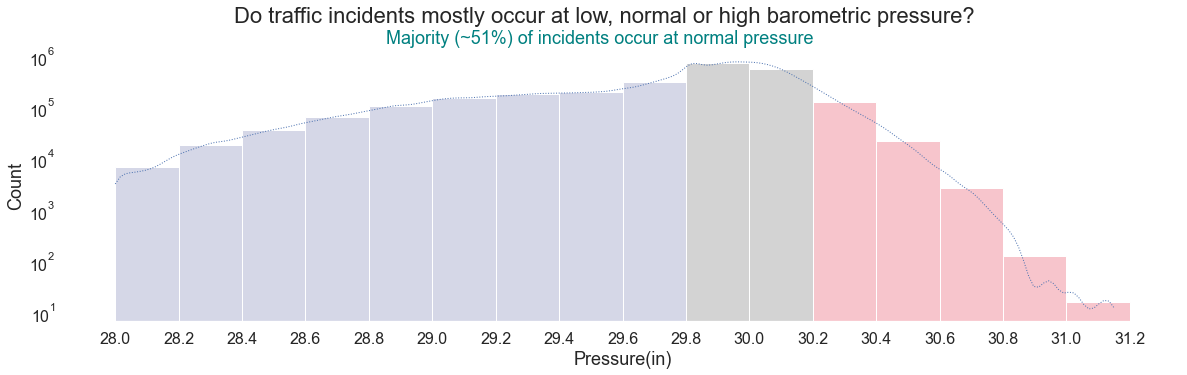

Rectangle(xy=(28, 0), width=0.2, height=6721, angle=0) -> 0.27 %
Rectangle(xy=(28.2, 0), width=0.2, height=18497, angle=0) -> 0.75 %
Rectangle(xy=(28.4, 0), width=0.2, height=36015, angle=0) -> 1.45 %
Rectangle(xy=(28.6, 0), width=0.2, height=64438, angle=0) -> 2.6 %
Rectangle(xy=(28.8, 0), width=0.2, height=106513, angle=0) -> 4.3 %
Rectangle(xy=(29, 0), width=0.2, height=149980, angle=0) -> 6.05 %
Rectangle(xy=(29.2, 0), width=0.2, height=175523, angle=0) -> 7.08 %
Rectangle(xy=(29.4, 0), width=0.2, height=196151, angle=0) -> 7.91 %
Rectangle(xy=(29.6, 0), width=0.2, height=313891, angle=0) -> 12.66 %
Rectangle(xy=(29.8, 0), width=0.2, height=717404, angle=0) -> 28.94 %
Rectangle(xy=(30, 0), width=0.2, height=544710, angle=0) -> 21.97 %
Rectangle(xy=(30.2, 0), width=0.2, height=124563, angle=0) -> 5.02 %
Rectangle(xy=(30.4, 0), width=0.2, height=21800, angle=0) -> 0.88 %
Rectangle(xy=(30.6, 0), width=0.2, height=2637, angle=0) -> 0.11 %
Rectangle(xy=(30.8, 0), width=0.2, height=125, 

In [24]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (20,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate histogram
hist = sns.histplot(data=us_accidents_preprocessed_insights, x="Pressure(in)", kde=True, binwidth=0.20,
                line_kws={"lw": 1, "ls": ":"}
            )

# Adjust scaling of axis
plt.yscale("log")
hist.xaxis.set_major_locator(ticker.MultipleLocator(0.20))

# Add and format description text
plt.suptitle("Do traffic incidents mostly occur at low, normal or high barometric pressure?", y=1, fontsize=22)
plt.title("Majority (~51%) of incidents occur at normal pressure", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Pressure(in)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in hist.patches:
    if  rectangle.get_x() <= 29.6:
        rectangle.set_facecolor("#D5D7E7")
    elif rectangle.get_x() >= 30:
        rectangle.set_facecolor("#F7C5CC")
    else:
        rectangle.set_facecolor("lightgray")

# Show figure
plt.show()

# Show histogram details
for bar in hist.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

# Calculate and show further information
mean_distance = us_accidents_preprocessed_insights["Pressure(in)"].mean()
median_distance = us_accidents_preprocessed_insights["Pressure(in)"].median()
std_distance = us_accidents_preprocessed_insights["Pressure(in)"].std()
q1_distance = us_accidents_preprocessed_insights["Pressure(in)"].quantile(0.25)
q3_distance = us_accidents_preprocessed_insights["Pressure(in)"].quantile(0.75)
iqr_distance = q3_distance-q1_distance
print("mean:", mean_distance)
print("median:", median_distance)
print("std:", std_distance)
print("iqr:", iqr_distance)
print("Distribution type:", check_distribution_type(us_accidents_preprocessed_insights, "Pressure(in)"))
data_info_num_ratio_attribute(us_accidents_preprocessed_insights, "Pressure(in)")

#### 📌 __Result__

__Background Knowledge__

- *Normal range:* The normal range of barometric pressure is denoted between 29 inHg and 31 inHg.
- *High Pressure:* A barometric reading over 30.20 inHg is generally considered high, and high pressure is associated with clear skies and calm weather. 
- *Normal Pressure:* A barometric reading in the range of 29.80 and 30.20 inHg can be considered normal, and normal pressure is associated with steady weather. 
- *Low Pressure:* A barometric reading below 29.80 inHg is generally considered low, and low pressure is associated with warm air and rainstorms. 


(Source 1: [Normal Range](https://www.masterclass.com/articles/how-barometric-pressure-works#learn-more),
Source 2: [High, Normal and Low Pressure](https://www.thoughtco.com/how-to-read-a-barometer-3444043))


__Result Interpretation__

About 51% (the majority) of incidents occur at normal barometric pressure, followed by low pressure with about 43%.
The taillight is the high barometric pressure, with only a proportion about 6%.

A typical traffic incident happens at normal barometric pressure with about 29.84 inHg.

### ❓ At which thermal sensation do most of the traffic incidents occur?

#### 🔎 Analysis

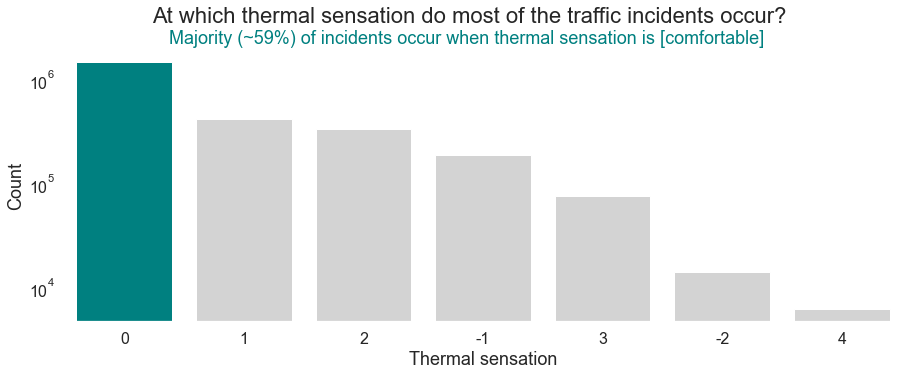

Rectangle(xy=(-0.4, 0), width=0.8, height=1.45895e+06, angle=0) -> 58.85 %
Rectangle(xy=(0.6, 0), width=0.8, height=411707, angle=0) -> 16.61 %
Rectangle(xy=(1.6, 0), width=0.8, height=329132, angle=0) -> 13.28 %
Rectangle(xy=(2.6, 0), width=0.8, height=184232, angle=0) -> 7.43 %
Rectangle(xy=(3.6, 0), width=0.8, height=75015, angle=0) -> 3.03 %
Rectangle(xy=(4.6, 0), width=0.8, height=13816, angle=0) -> 0.56 %
Rectangle(xy=(5.6, 0), width=0.8, height=6135, angle=0) -> 0.25 %


In [25]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Thermal_Sensation"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Thermal_Sensation", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("At which thermal sensation do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~59%) of incidents occur when thermal sensation is [comfortable]", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Thermal sensation", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

__Background Knowledge__

| Level | Description | Feels-like Temperature (Fahrenheit) | 
| :-: | :-: | :-: | 
| -4 | very cold |  <= -38.2 |
| -3 | cold |  > -38.2 and <= -14.8  |
| -2 | cool |  > -14.8 and <= 8.6 |
| -1 | slightly cool | > 8.6 and <= 32 |
| 0 | comfortable | > 32 and <= 68 |
| 1 | slightly warm | > 68 and <= 78.8 |
| 2 | warm | > 78.8 and <= 89.6 |
| 3 | hot | > 89.6 and <= 100.4 |
| 4 | very hot | > 100.4 |

(Source: https://de.wikipedia.org/wiki/Gef%C3%BChlte_Temperatur)

__Result Interpretation__

About 59% (the majority) of incidents occur when thermal sensation is *comfortable*, followed by *slightly warm* with about 17%.

The rest is distributed in descending order among thermal sensation of *warm*, *slightly cool*, *hot*, *cool*, and *very hot* with about 13%, 7%, 3%, 0.6% and 0.3% respectively. 

### ❓ At which wind force do most of the traffic incidents occur?

#### 🔎 Analysis

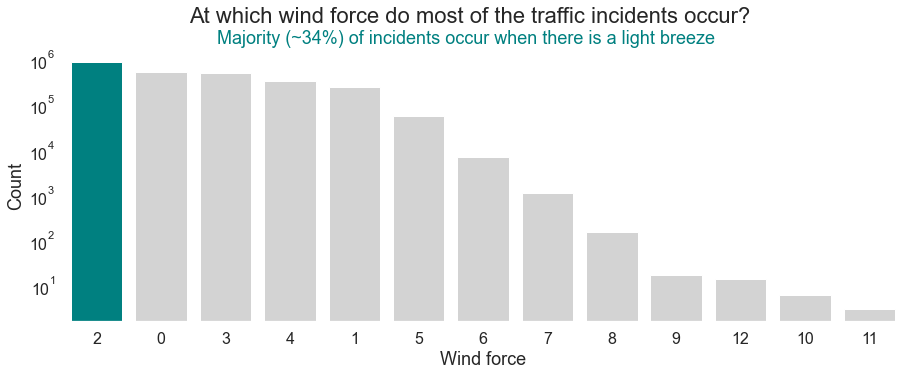

Rectangle(xy=(-0.4, 0), width=0.8, height=852534, angle=0) -> 34.39 %
Rectangle(xy=(0.6, 0), width=0.8, height=520511, angle=0) -> 21.0 %
Rectangle(xy=(1.6, 0), width=0.8, height=488556, angle=0) -> 19.71 %
Rectangle(xy=(2.6, 0), width=0.8, height=320018, angle=0) -> 12.91 %
Rectangle(xy=(3.6, 0), width=0.8, height=234797, angle=0) -> 9.47 %
Rectangle(xy=(4.6, 0), width=0.8, height=54496, angle=0) -> 2.2 %
Rectangle(xy=(5.6, 0), width=0.8, height=6821, angle=0) -> 0.28 %
Rectangle(xy=(6.6, 0), width=0.8, height=1062, angle=0) -> 0.04 %
Rectangle(xy=(7.6, 0), width=0.8, height=149, angle=0) -> 0.01 %
Rectangle(xy=(8.6, 0), width=0.8, height=17, angle=0) -> 0.0 %
Rectangle(xy=(9.6, 0), width=0.8, height=14, angle=0) -> 0.0 %
Rectangle(xy=(10.6, 0), width=0.8, height=6, angle=0) -> 0.0 %
Rectangle(xy=(11.6, 0), width=0.8, height=3, angle=0) -> 0.0 %


In [26]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Wind_Force"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Wind_Force", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("At which wind force do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~34%) of incidents occur when there is a light breeze", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Wind force", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

__Background Knowledge__

| Wind Force | Description | Wind Speed (mph) | 
| :-: | :-: | :-: | 
| 0 | Calm |  < 1 |
| 1 | Light Air | >= 1 and <= 3 |
| 2 | Light Breeze | >= 4 and <= 7 |
| 3 | Gentle Breeze | >= 8 and <= 12 |
| 4 | Moderate Breeze | >= 13 and <= 18 |
| 5 | Fresh Breeze | >= 19 and <= 24 |
| 6 | Strong Breeze | >= 25 and <= 31 |
| 7 | Near Gale | >= 32 and <= 38 |
| 8 | Gale | >= 39 and <= 46 |
| 9 | Strong Gale | >= 47 and <= 54 |
| 10 | Storm | >= 55 and <= 63 |
| 11 | Violent Storm | >= 64 and <= 72 |
| 12 | Hurricane | >= 73 |

(Source: https://de.wikipedia.org/wiki/Windgeschwindigkeit and https://www.rmets.org/metmatters/beaufort-scale)

__Result Interpretation__

About 34% (the majority) of incidents occur when wind force is *light breeze*, directly followed by *calm* with about 21%.

Traffic incidents during *strong gale*, *storm*, *violent storm* or *hurricane* are rather untypical.

### ❓ At which rainfall grade do most of the traffic incidents occur?

#### 🔎 Analysis

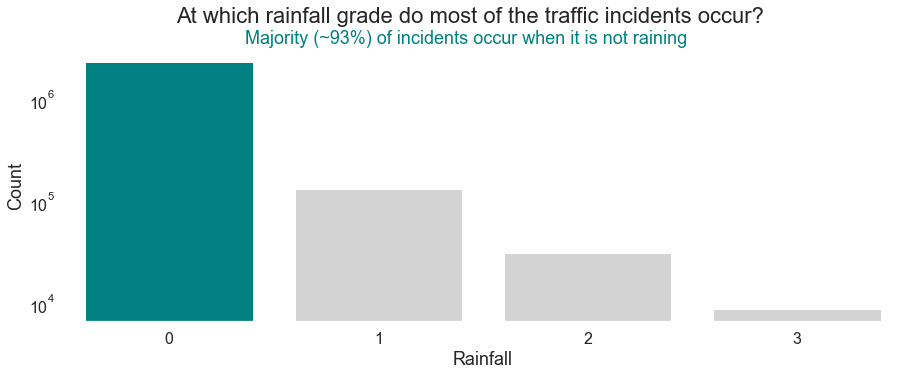

Rectangle(xy=(-0.4, 0), width=0.8, height=2.30838e+06, angle=0) -> 93.12 %
Rectangle(xy=(0.6, 0), width=0.8, height=131519, angle=0) -> 5.31 %
Rectangle(xy=(1.6, 0), width=0.8, height=30445, angle=0) -> 1.23 %
Rectangle(xy=(2.6, 0), width=0.8, height=8637, angle=0) -> 0.35 %


In [27]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Rainfall"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Rainfall", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("At which rainfall grade do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~93%) of incidents occur when it is not raining", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Rainfall", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")

# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

__Background Knowledge__

| Grade | Description | Precipitation(in) | 
| :-: | :-: | :-: | 
| 0 | No rain | = 0 |
| 1 | Light rain | > 0 and < 0.10 |
| 2 | Moderate rain | >= 0.10 and < 0.30 |
| 3 | Heady rain | >= 0.30 |

__Result Interpretation__

About 93% (the majority) of traffic incidents occur when it is not raining, directly followed by light and moderate rainfall with about 5% and 1% respectively.

Traffic incidents during heavy rainfall are rather untypical.


### ❓ At which visibility grade do most of the traffic incidents occur?

#### 🔎 Analysis

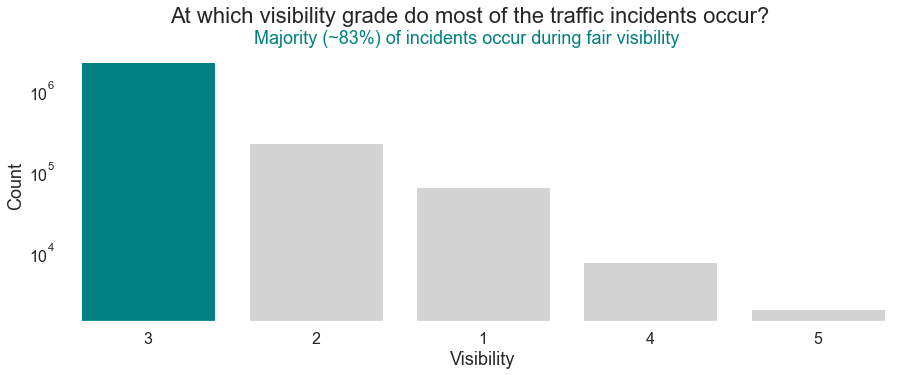

Rectangle(xy=(-0.4, 0), width=0.8, height=2.18596e+06, angle=0) -> 88.18 %
Rectangle(xy=(0.6, 0), width=0.8, height=221144, angle=0) -> 8.92 %
Rectangle(xy=(1.6, 0), width=0.8, height=62353, angle=0) -> 2.52 %
Rectangle(xy=(2.6, 0), width=0.8, height=7528, angle=0) -> 0.3 %
Rectangle(xy=(3.6, 0), width=0.8, height=1995, angle=0) -> 0.08 %


In [28]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Generate countplot
order = us_accidents_preprocessed_insights["Visibility"].value_counts().index
countplot = sns.countplot(data=us_accidents_preprocessed_insights, x="Visibility", order=order)

# Adjust scaling of axis
plt.yscale("log")

# Add and format description text
plt.suptitle("At which visibility grade do most of the traffic incidents occur?", y=1, fontsize=22)
plt.title("Majority (~83%) of incidents occur during fair visibility", x=0.48, y=1.00002, fontsize=18, color="teal")
plt.xlabel("Visibility", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.tick_params(labelsize=16)

# Color bars
for rectangle in countplot.patches:
    if rectangle.get_x() < 0.6 :
        rectangle.set_facecolor("teal")
    else:
        rectangle.set_facecolor("lightgrey")


# Show figure
plt.show()

# Show details
for bar in countplot.patches:
    percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
    print(bar, "->", percentage, "%")

#### 📌 __Result__

__Background Knowledge__

| Grade | Description | Visibility (mi) | 
| :-: | :-: | :-: | 
| 1 | Excellent visibility | > 31 |
| 2 | Good visibility | > 12 and <= 31 |
| 3 | Fair visibility | > 6 and <= 12 |
| 4 | Poor visibility | > 1 and <= 6 |
| 5 | Bad visibility | > 31 |

(Source: https://de.wikipedia.org/wiki/Sichtweite)

__Result Interpretation__

About 88% (the majority) of traffic incidents occur during fair visibility, directly followed by good and excellent visibility with about 9% and 3% respectively.

Traffic incidents during bad visibility are rather untypical.

### ❓ Do traffic incidents happen more often by rain, fog or snow?

#### 🔎 Analysis

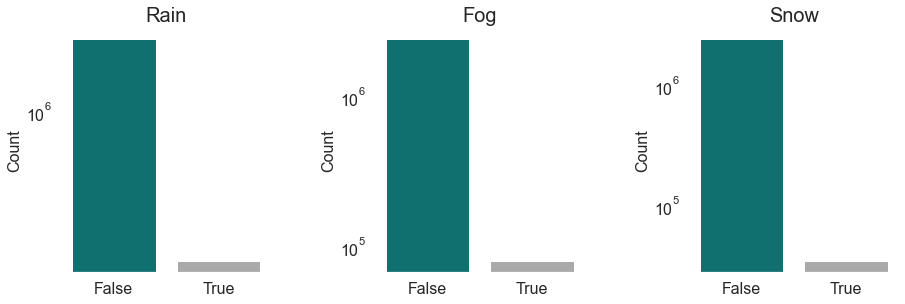

########## Rain
Rectangle(xy=(-0.4, 0), width=0.8, height=2.29999e+06, angle=0) -> 92.78 %
Rectangle(xy=(0.6, 0), width=0.8, height=178994, angle=0) -> 7.22 %
########## Fog
Rectangle(xy=(-0.4, 0), width=0.8, height=2.39999e+06, angle=0) -> 96.81 %
Rectangle(xy=(0.6, 0), width=0.8, height=78992, angle=0) -> 3.19 %
########## Snow
Rectangle(xy=(-0.4, 0), width=0.8, height=2.44506e+06, angle=0) -> 98.63 %
Rectangle(xy=(0.6, 0), width=0.8, height=33924, angle=0) -> 1.37 %


In [29]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (15,5),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Define colors
palette = ["teal", "darkgray"]

# Create figure with subplots
fig, ((ax1, ax2, ax3)) = plt.subplots (1, 3)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.5, hspace=0.5)

# Fill subplots
ax1.set_title("Rain", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Rain", ax=ax1, palette=palette)
ax1.set_xlabel("", fontsize=16)
ax1.set_ylabel("Count", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=16)
ax1.set_yscale("log")

ax2.set_title("Fog", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Fog", ax=ax2, palette=palette)
ax2.set_xlabel("", fontsize=16)
ax2.set_ylabel("Count", fontsize=16)
ax2.tick_params(axis="both", which="major", labelsize=16)
ax2.set_yscale("log")

ax3.set_title("Snow", fontsize=20)
sns.countplot(data=us_accidents_preprocessed_insights, x="Snow", ax=ax3, palette=palette)
ax3.set_xlabel("", fontsize=16)
ax3.set_ylabel("Count", fontsize=16)
ax3.tick_params(axis="both", which="major", labelsize=16)
ax3.set_yscale("log")

# Show figure
plt.show()

# Show details
axes = [ax1, ax2, ax3]
for ax in axes:
    print("##########", ax.get_title())
    for bar in ax.patches:
        percentage = round(bar.get_height() / us_accidents_preprocessed_insights.shape[0] * 100, 2)
        print(bar, "->", percentage, "%")

#### 📌 __Result__

The majority of traffic incidents do not happen more often by rain, fog or snow. Only about 7% happens during rain, about 3% during fog and about 1% during snow.

## <a id="analysis-7"></a>🔁 Analysis Area 7: Relationship Analysis

👉🏼 __Provides insights about possible relationships between features.__

❓ The following questions will be investigated
- What relations exist between the features (Covariance)?
- What relations exist between the features (Correlation / Pearson)?
- Which features have a positive relationship (Correlation / Pearson)?
- Which features have a negative relationship (Correlation / Pearson)?

### ❓ What relations exist between the features (Covariance)?

#### 🔎 Analysis

In [30]:
# Create empty data frame for subsequent processing
df_covariances = pd.DataFrame(columns=["Feature_1", "Feature_2", "Cov_Value", "Cov_Type"])
# Calculate covariances
covariances = us_accidents_preprocessed_insights.cov().round(2)
# Populate data frame with covariances values greater or less than threshold value +0.15 / -0.15
for col in covariances.columns:
    result = covariances[
        (covariances >= 0.15) |
        (covariances <= -0.15)
        ][col].dropna()

    for i, item in enumerate(result.index.to_numpy()):
        if not result.name == item:
            if result.values[i] > 0:
                type = "Positive"
            else:
                type = "Negative"

            # Check if combination already exists in data frame
            len = df_covariances[
                    ((df_covariances["Feature_1"] == result.name) &
                    (df_covariances["Feature_2"] == item)) 
                    |
                    ((df_covariances["Feature_1"] == item) &
                    (df_covariances["Feature_2"] == result.name))
                    ].shape[0]
            
            if len < 1:
                row_values = [result.name, item, result.values[i], type]
                row = pd.DataFrame([row_values], columns=["Feature_1", "Feature_2", "Cov_Value", "Cov_Type"])
                df_covariances = pd.concat([df_covariances, row], ignore_index=True)

# Print covariance matrix
pd.set_option('display.max_rows', None)
covariances

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Year,Month,Day,Weekday,Hour,Minute,Second,Duration(h),Rainfall,Visibility,Rain,Fog,Snow,Wind_Force,Thermal_Sensation
Severity,0.23000,0.23000,1.04000,0.03000,-0.38000,0.36000,0.02000,-0.00000,-0.00000,-0.00000,0.00000,0.01000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.22000,-0.13000,-0.02000,-0.01000,-0.07000,0.03000,1.29000,0.13000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.01000,-0.05000
Start_Lat,0.23000,27.51000,-10.52000,0.32000,-40.74000,0.74000,-0.46000,-0.00000,0.00000,-0.12000,0.00000,0.08000,-0.00000,0.00000,-0.00000,-0.08000,0.01000,-0.00000,-0.08000,-1.15000,-1.54000,0.04000,0.13000,-0.45000,0.17000,8.19000,0.67000,0.04000,-0.19000,0.04000,0.01000,0.09000,0.05000,-1.93000
Start_Lng,1.04000,-10.52000,340.03000,1.39000,2.94000,62.59000,0.52000,0.02000,-0.00000,0.27000,0.02000,-0.16000,0.00000,-0.03000,0.00000,0.08000,-0.09000,-0.00000,0.34000,2.04000,2.72000,1.89000,-0.74000,0.31000,-0.31000,79.98000,-0.36000,0.27000,0.22000,0.13000,-0.34000,0.10000,2.67000,0.83000
Distance(mi),0.03000,0.32000,1.39000,0.66000,-0.37000,0.46000,-0.02000,-0.00000,-0.00000,-0.03000,-0.00000,0.01000,-0.00000,-0.00000,-0.00000,-0.01000,-0.00000,-0.00000,-0.04000,0.07000,0.10000,0.05000,0.01000,-0.13000,-0.02000,0.71000,0.11000,0.00000,-0.01000,0.00000,-0.00000,0.00000,-0.00000,-0.01000
Temperature(F),-0.38000,-40.74000,2.94000,-0.37000,300.05000,-139.80000,0.18000,0.02000,0.00000,0.28000,-0.01000,-0.13000,0.01000,0.00000,0.00000,0.15000,-0.01000,0.00000,0.20000,0.92000,3.99000,1.40000,-0.41000,17.41000,-0.14000,7.85000,-0.76000,-0.42000,1.58000,-0.33000,-0.16000,-0.49000,2.98000,13.19000
Humidity(%),0.36000,0.74000,62.59000,0.46000,-139.80000,487.61000,0.80000,-0.02000,-0.00000,-0.12000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.02000,-0.00000,-0.18000,0.72000,3.44000,2.98000,0.95000,-28.44000,0.43000,5.18000,-0.15000,2.14000,-3.30000,1.64000,0.41000,0.29000,-5.76000,-6.61000
Pressure(in),0.02000,-0.46000,0.52000,-0.02000,0.18000,0.80000,0.20000,0.00000,-0.00000,0.00000,-0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.19000,-0.01000,-0.13000,-0.03000,-0.09000,0.02000,0.72000,0.19000,-0.01000,0.01000,-0.01000,-0.00000,-0.00000,-0.03000,-0.03000
Amenity,-0.00000,-0.00000,0.02000,-0.00000,0.02000,-0.02000,0.00000,0.01000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.01000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000
Bump,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000
Crossing,-0.00000,-0.12000,0.27000,-0.03000,0.28000,-0.12000,0.00000,0.00000,0.00000,0.06000,0.00000,-0.01000,0.00000,0.00000,-0.00000,0.01000,0.00000,0.00000,0.03000,0.02000,0.01000,0.01000,-0.00000,0.04000,-0.00000,0.08000,-0.02000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.01000,0.02000


In [31]:
# Print positive covariances
# Negative positive threshold >= 0.15
positive_covariances = df_covariances[df_covariances["Cov_Type"] == "Positive"].sort_values("Cov_Value", ascending=False)
print("Total positive covariances:", positive_covariances.shape[0])
pd.set_option('display.max_rows', 20)
positive_covariances

Total positive covariances: 70


,Feature_1,Feature_2,Cov_Value,Cov_Type
32,Start_Lng,Second,79.98000,Positive
21,Start_Lng,Humidity(%),62.59000,Positive
51,Temperature(F),Hour,17.41000,Positive
60,Temperature(F),Thermal_Sensation,13.19000,Positive
15,Start_Lat,Second,8.19000,Positive
...,...,...,...,...
43,Temperature(F),Pressure(in),0.18000,Positive
83,Year,Day,0.17000,Positive
14,Start_Lat,Minute,0.17000,Positive
100,Day,Thermal_Sensation,0.15000,Positive


In [32]:
# Print negative covariances
# Negative covariances threshold <= -0.15
negative_covariances = df_covariances[df_covariances["Cov_Type"] == "Negative"].sort_values("Cov_Value", ascending=True)
print("Total negative covariances:", negative_covariances.shape[0])
pd.set_option('display.max_rows', 20)
negative_covariances

Total negative covariances: 46


,Feature_1,Feature_2,Cov_Value,Cov_Type
42,Temperature(F),Humidity(%),-139.80000,Negative
8,Start_Lat,Temperature(F),-40.74000,Negative
67,Humidity(%),Hour,-28.44000,Negative
6,Start_Lat,Start_Lng,-10.52000,Negative
87,Year,Second,-7.24000,Negative
...,...,...,...,...
62,Humidity(%),Traffic_Signal,-0.18000,Negative
112,Second,Fog,-0.17000,Negative
24,Start_Lng,Junction,-0.16000,Negative
57,Temperature(F),Fog,-0.16000,Negative


<center><img src="https://raw.githubusercontent.com/anjakuchenbecker/eda_on_traffic_incidents/main/A_7_Q1.png" alt="Drawing" style="width: 800px;"/></center>

#### 📌 __Result__

The pairwise covariance data frame reveals that several positive linear relationships (about 70, greater than 0) as well as negative linear relationships (about 46, smaller than 0) between two features exist. 

No linear relationships are equal to zero (keep in mind that nevertheless non-linear relationships might exist).

The magnitude of the covariance is not easy to interpret because it is not normalized and hence depends on the magnitudes of the features. 

As a result, the further relationship analysis will be performed with support of the normalized version of the covariance, the Pearson Correlation Coefficient.

(With covariance threshold of at least / less than 0.15)

### ❓ What relations exist between the features (Correlation / Pearson)?

#### 🔎 Analysis

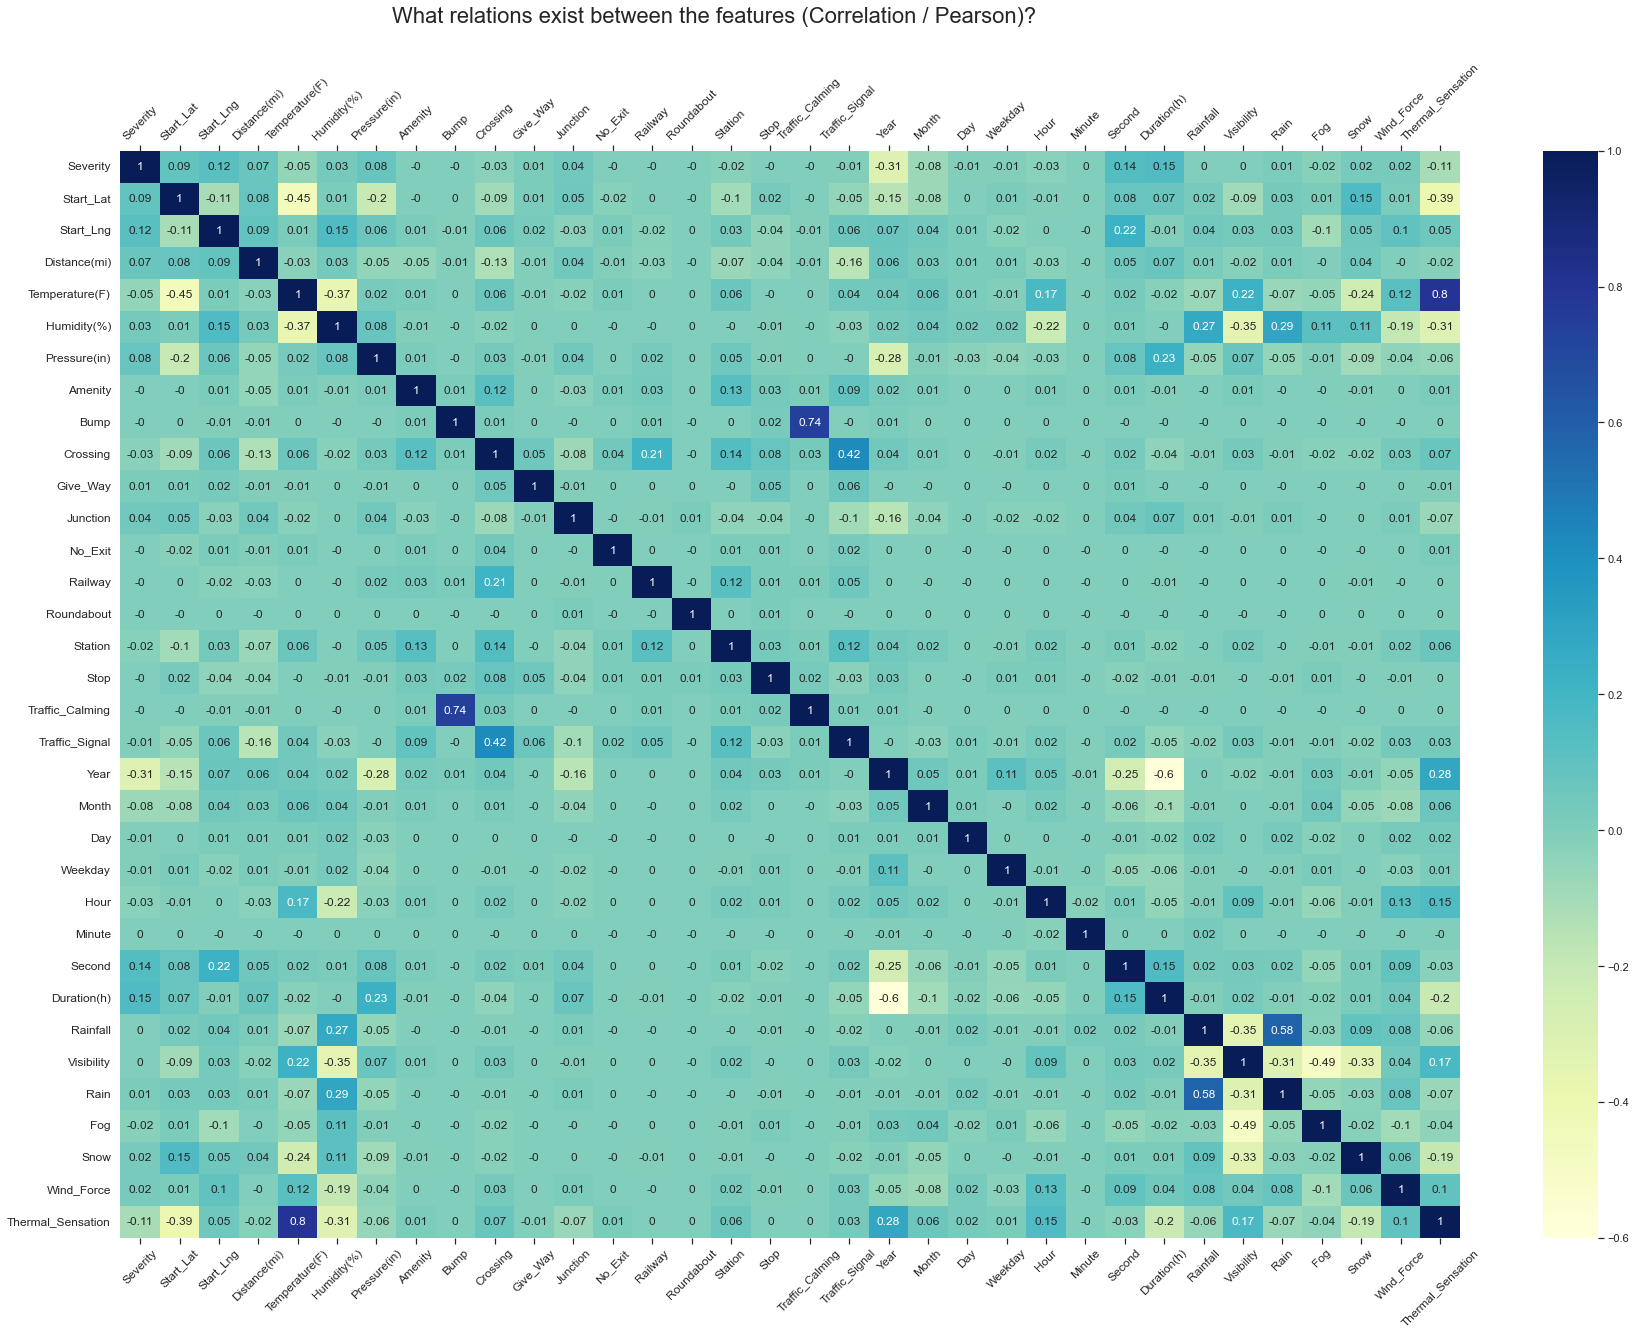

In [33]:
# Common figure settings
sns.set(
    rc={
        "figure.figsize": (30,20),
        "axes.facecolor": "white",
        "axes.grid": False,
        "font.family": "Arial",
    }
)

# Plot correlation heatmap
dataplot = sns.heatmap(us_accidents_preprocessed_insights.corr().round(2), cmap="YlGnBu", annot=True)

# Add and format description text
plt.suptitle("What relations exist between the features (Correlation / Pearson)?", x=0.4, fontsize=22)

# Customize ticks
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom=True, bottom=True, top=True, labeltop=True)
plt.xticks(rotation=45)
  
# Displaying heatmap
plt.show()

# Create empty data frame for subsequent processing
df_correlations = pd.DataFrame(columns=["Feature_1", "Feature_2", "Corr_Value", "Corr_Type"])
# Calculate correlations based on pearson correlation coefficient
pearson_correlation = us_accidents_preprocessed_insights.corr(method="pearson").round(2)
# Populate data frame with correlations values greater or less than threshold value +0.15 / -0.15
for col in pearson_correlation.columns:
    result = pearson_correlation[
        (pearson_correlation >= 0.15) |
        (pearson_correlation <= -0.15)
        ][col].dropna()

    for i, item in enumerate(result.index.to_numpy()):
        if not result.name == item:
            if result.values[i] > 0:
                type = "Positive"
            else:
                type = "Negative"

            # Check if combination already exists in data frame
            len = df_correlations[
                    ((df_correlations["Feature_1"] == result.name) &
                    (df_correlations["Feature_2"] == item)) 
                    |
                    ((df_correlations["Feature_1"] == item) &
                    (df_correlations["Feature_2"] == result.name))
                    ].shape[0]
            
            if len < 1:
                row_values = [result.name, item, result.values[i], type]
                row = pd.DataFrame([row_values], columns=["Feature_1", "Feature_2", "Corr_Value", "Corr_Type"])
                df_correlations = pd.concat([df_correlations, row], ignore_index=True)

#### 📌 __Result__

The correlation heatmap reveals that several positive linear relationships (blue gradient) as well as negative linear relationships (yellow gradient) between two features exist. 

No linear relationships are colored green (keep in mind that nevertheless non-linear relationships might exist).

⚠️ __Important__

Correlation does not imply causation! A correlation does not mean that the changes in one feature actually *cause* the changes in the other feature.

However, a suspected causal and linear relationship between two variables can be ruled out if the correlation coefficient is close to zero.

### ❓ Which features have a positive relationship (Correlation / Pearson)?

#### 🔎 Analysis

In [34]:
# Print positive correlations
# Positive correlation threshold >= -0.15
pd.set_option('display.max_rows', None)
positive_correlations = df_correlations[df_correlations["Corr_Type"] == "Positive"].sort_values("Corr_Value", ascending=False)
print("Total positive correlations:", positive_correlations.shape[0])
positive_correlations

Total positive correlations: 18


,Feature_1,Feature_2,Corr_Value,Corr_Type
14,Temperature(F),Thermal_Sensation,0.80000,Positive
23,Bump,Traffic_Calming,0.74000,Positive
34,Rainfall,Rain,0.58000,Positive
25,Crossing,Traffic_Signal,0.42000,Positive
18,Humidity(%),Rain,0.29000,Positive
29,Year,Thermal_Sensation,0.28000,Positive
16,Humidity(%),Rainfall,0.27000,Positive
22,Pressure(in),Duration(h),0.23000,Positive
8,Start_Lng,Second,0.22000,Positive
12,Temperature(F),Visibility,0.22000,Positive


#### 📌 __Result__

With correlation threshold of at least 0.15 there are 18 total positive correlations, meaning when one feature increases the other increases (the larger A, the larger B). 

As the magnitude is a measure of strength there are weaker and stronger positive correlations: There are 3 correlations of high degree, 1 of moderate degree and 14 with low degree.

__List of high degree / strong correlations (>= 0.50)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: | 
| Temperature(F) | Thermal_Sensation | 0.80 |
| Bump | Traffic_Calming | 0.74 |
| Rainfall | Rain | 0.58 |

__List of moderate degree / medium correlations (>= 0.30 and < 0.50)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: |
| Crossing | Traffic_Signal | 0.42 |

__List of low degree / small correlations (< 0.30)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: |
| Humidity(%) | Rain | 0.29 |
| Year | Thermal_Sensation | 0.28 |
| Humidity(%) | Rainfall | 0.27 |
| Pressure(in) | Duration(h) | 0.23 |
| Start_Lng | Second | 0.22 | 
| Temperature(F) | Visibility | 0.22 |
| Crossing | Railway | 0.21 |
| Visibility | Thermal_Sensation | 0.17 |
| Temperature(F) | Hour	| 0.17 |
| Start_Lat | Snow | 0.15 |
| Hour | Thermal_Sensation | 0.15 |
| Second | Duration(h)	| 0.15 | 
| Start_Lng | Humidity(%) | 0.15 |
| Severity | Duration(h) | 0.15 |

### ❓ Which features have a negative relationship (Correlation / Pearson)?

#### 🔎 Analysis

In [35]:
# Print negative correlations
# Negative correlation threshold <= -0.15
pd.set_option('display.max_rows', None)
negative_correlations = df_correlations[df_correlations["Corr_Type"] == "Negative"].sort_values("Corr_Value", ascending=True)
print("Total negative correlations:", negative_correlations.shape[0])
negative_correlations

Total negative correlations: 22


,Feature_1,Feature_2,Corr_Value,Corr_Type
28,Year,Duration(h),-0.60000,Negative
36,Visibility,Fog,-0.49000,Negative
2,Start_Lat,Temperature(F),-0.45000,Negative
6,Start_Lat,Thermal_Sensation,-0.39000,Negative
10,Temperature(F),Humidity(%),-0.37000,Negative
17,Humidity(%),Visibility,-0.35000,Negative
33,Rainfall,Visibility,-0.35000,Negative
37,Visibility,Snow,-0.33000,Negative
0,Severity,Year,-0.31000,Negative
35,Visibility,Rain,-0.31000,Negative


#### 📌 __Result__

With correlation threshold of less than -0.15 there are 22 total negative correlations, meaning when one feature decreases the other increases (the larger A, the smaller B). 

As the magnitude is a measure of strength there are weaker and stronger negative correlations: There are 1 correlation of high degree, 10 of moderate degree and 11 with low degree.

__List of high degree / strong correlations (>= -0.50)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: |
| Year | Duration(h) | -0.60 |

__List of moderate degree / medium correlations (>= -0.30 and < -0.50)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: |
| Visibility | Fog | -0.49	|
| Start_Lat | Temperature(F) | -0.45 |
| Start_Lat	| Thermal_Sensation | -0.39 |
| Temperature(F) | Humidity(%) | -0.37 |
| Humidity(%) | Visibility | -0.35 |
| Rainfall | Visibility	| -0.35 |
| Visibility | Snow	| -0.33 |
| Severity | Year | -0.31 |
| Visibility | Rain	| -0.31 |
| Humidity(%) | Thermal_Sensation | -0.31 |

__List of low degree / small correlations (< -0.30)__

| <div style="width:200px">Feature 1</div> | <div style="width:200px">Feature 2</div> | <div style="width:200px">Correlation Value</div> |
| :-: | :-: | :-: |
| Pressure(in) | Year | -0.28 |
| Year | Second	| -0.25 |
| Temperature(F) | Snow | -0.24 |
| Humidity(%) | Hour | -0.22 |
| Start_Lat | Pressure(in) | -0.20 |
| Duration(h) | Thermal_Sensation | -0.20 |
| Humidity(%) | Wind_Force | -0.19 |
| Snow | Thermal_Sensation | -0.19 |
| Distance(mi) | Traffic_Signal | -0.16 |
| Junction | Year | -0.16 |
| Start_Lat | Year | -0.15 |

# <a id="chapter-7"></a>Task 5: Communicate the Story

s scrolling to within an entire long Jupyter notebook can be tedious and cluttery, all insights are condensed into a separated handout file in PDF format which can be shared with the target audience. Questions and the analysis results are stacked closely together to get most of the insights.

Please download the handout here: https://raw.githubusercontent.com/anjakuchenbecker/eda_on_traffic_incidents/main/EDA_US_Traffic_Incidents_Handout.pdf

*Go to [TOC](#toc)*

# <a id="chapter-8"></a>Task 6: Perform Modeling

Not in scope of this notebook.

*Go to [TOC](#toc)*

# <a id="chapter-9"></a>Task 7: Perform Model Evaluation

Not in scope of this notebook.

*Go to [TOC](#toc)*

# <a id="chapter-10"></a>Appendix

*Go to [TOC](#toc)*

## <a id="acknowledgements"></a>Acknowledgements


- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019. https://arxiv.org/abs/1906.05409
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019. https://arxiv.org/abs/1909.09638
- GeoNames Postal Code files coming from http://www.geonames.org / http://download.geonames.org/export/dump/


## <a id="bibliography"></a>Bibliography

- Brown, M. S. (2014). *Data mining for dummies. For dummies.* John Wiley & Sons, Inc. 
- Jambu, M. (1991). *Exploratory and multivariate analysis. Statistical modeling and decision science.* Academic Press.
- Knaflic, C. N. (2015). *Storytelling with data: A data visualization guide for business professionals*. Wiley.
- Navlani, A., Fandango, A., & Idris, I. (2021). *Python Data Analysis - Third Edition (3rd edition)*. Packt Publishing; Safari. 
